In [2]:
# 1. config - 설정 및 상수 관리

"""
config.py - 채권 금리 분석 시스템 설정 파일

이 모듈의 역할:
1. 파일 경로 및 시트 정보 중앙 관리
2. 분석 파라미터 (윈도우 크기, 임계값 등) 정의
3. 시각화 스타일 설정 (금융권/논문 스타일)
4. 컬럼명 파싱 규칙 정의

설계 원칙:
- 하드코딩된 값을 최소화하고, 변경 가능성이 있는 모든 값은 여기서 관리
- 다른 모듈에서는 from config import * 로 설정값 참조
"""

from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt


# ============================================================================
# 1. 파일 및 데이터 설정
# ============================================================================

@dataclass
class DataConfig:
    """데이터 소스 관련 설정"""
    
    # 파일 경로
    file_path: Path = Path(r"D:\채권\작업중\금리_스프레드표.xlsb")
    
    # 시트 정보
    rates_sheet: str = "Rates"
    spread_sheet: str = "Spread"
    
    # 데이터 구조 (엑셀 기준 1-indexed → Python 0-indexed 변환)
    header_row: int = 4      # 엑셀 4행 = Python index 3
    data_start_row: int = 5  # 엑셀 5행 = Python index 4
    date_column: str = "A"   # 일자 컬럼
    
    # 날짜 형식
    date_format: str = "%Y-%m-%d"


# ============================================================================
# 2. 컬럼명 파싱 규칙
# ============================================================================

@dataclass
class ColumnParsingConfig:
    """
    컬럼명 파싱 규칙
    
    컬럼 형식: (섹터명)(신용등급)_(만기)
    예시:
    - 국고채RF_3M  → 섹터: 국고채, 등급: RF, 만기: 3M
    - 공사채AA+_9M → 섹터: 공사채, 등급: AA+, 만기: 9M
    - 은행채AAA_1Y → 섹터: 은행채, 등급: AAA, 만기: 1Y
    """
    
    # 알려진 섹터 목록 (파싱 시 섹터 구분에 사용)
    known_sectors: Tuple[str, ...] = (
        "국고채", "통안채", "공사채", "은행채", "회사채", 
        "카드채", "캐피탈", "여전채", "지방채", "특수채",
        "산금채", "수출입", "한전채", "도로공", "주금공",
        "CD", "CP", "콜", "REPO"
    )
    
    # 알려진 신용등급 (순서 중요: 긴 것부터 매칭)
    known_ratings: Tuple[str, ...] = (
        "AAA", "AA+", "AA0", "AA-", "AA",
        "A+", "A0", "A-", "A",
        "BBB+", "BBB0", "BBB-", "BBB",
        "BB+", "BB0", "BB-", "BB",
        "B+", "B0", "B-", "B",
        "RF",  # Risk-Free (국고채)
        "무등급"
    )
    
    # 만기 표현 패턴 (정규식에서 사용)
    # 3M, 6M, 9M, 1Y, 2Y, 3Y, 5Y, 10Y, 20Y, 30Y 등
    maturity_pattern: str = r"(\d+)(D|W|M|Y)"
    
    # 만기를 연 단위로 변환하는 계수
    maturity_to_years: Dict[str, float] = field(default_factory=lambda: {
        "D": 1/365,   # 일
        "W": 1/52,    # 주
        "M": 1/12,    # 월
        "Y": 1.0      # 연
    })


# ============================================================================
# 3. 분석 파라미터
# ============================================================================

@dataclass 
class AnalysisConfig:
    """시계열 분석 관련 파라미터"""
    
    # ----- Rolling 분석 윈도우 -----
    # 단기/중기/장기 세 가지 시계를 동시에 분석
    rolling_windows: Dict[str, int] = field(default_factory=lambda: {
        "short": 20,    # 약 1개월 (영업일 기준)
        "medium": 60,   # 약 3개월
        "long": 120     # 약 6개월
    })
    
    # ----- 상관관계 분석 -----
    correlation_threshold: float = 0.7      # 유의미한 상관관계 기준
    min_observations: int = 30              # 최소 관측치 수
    
    # ----- 공적분 검정 (Cointegration) -----
    coint_significance: float = 0.05        # 유의수준
    adf_max_lags: int = 12                  # ADF 검정 최대 시차
    
    # ----- 스프레드 분석 -----
    zscore_entry_threshold: float = 2.0     # 진입 시그널 (Z-score)
    zscore_exit_threshold: float = 0.5      # 청산 시그널
    lookback_period: int = 60               # Z-score 계산 기간
    
    # ----- Regime Detection -----
    regime_window: int = 60                 # 레짐 탐지 윈도우
    volatility_percentile: float = 0.75     # 고변동성 레짐 기준
    
    # ----- Cross-correlation -----
    max_lag: int = 20                       # 최대 시차 (Lead-Lag 분석)


# ============================================================================
# 4. 시각화 설정 (금융권/논문 스타일)
# ============================================================================

@dataclass
class VisualizationConfig:
    """
    금융권 및 학술 논문에서 사용하는 건조하고 전문적인 스타일
    
    특징:
    - 최소한의 장식 (no grid 또는 subtle grid)
    - 흑백 기반, 필요시 제한된 색상
    - 명확한 축 레이블과 범례
    - 적절한 여백과 가독성
    """
    
    # ----- 기본 Figure 설정 -----
    figure_dpi: int = 100
    figure_facecolor: str = "white"
    
    # 표준 Figure 크기 (inch)
    figsize_single: Tuple[float, float] = (10, 6)      # 단일 차트
    figsize_double: Tuple[float, float] = (12, 8)      # 2개 패널
    figsize_multi: Tuple[float, float] = (14, 10)      # 다중 패널
    figsize_heatmap: Tuple[float, float] = (12, 10)    # 히트맵
    
    # ----- 색상 팔레트 (금융권 표준) -----
    colors: Dict[str, str] = field(default_factory=lambda: {
        "primary": "#1f77b4",      # 파란색 (메인)
        "secondary": "#ff7f0e",    # 주황색 (비교)
        "positive": "#2ca02c",     # 녹색 (상승/매수)
        "negative": "#d62728",     # 빨강 (하락/매도)
        "neutral": "#7f7f7f",      # 회색 (중립)
        "highlight": "#9467bd",    # 보라 (강조)
        "background": "#f0f0f0",   # 배경
        "grid": "#d0d0d0",         # 그리드
    })
    
    # 다중 시계열용 색상 (구분이 쉬운 8색)
    line_colors: Tuple[str, ...] = (
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
        "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"
    )
    
    # ----- 폰트 설정 -----
    font_family: str = "Malgun Gothic"  # 한글 지원
    font_size_title: int = 14
    font_size_label: int = 11
    font_size_tick: int = 9
    font_size_legend: int = 9
    font_size_annotation: int = 8
    
    # ----- 선 스타일 -----
    linewidth_main: float = 1.5
    linewidth_secondary: float = 1.0
    linewidth_reference: float = 0.8
    linestyle_reference: str = "--"
    
    # ----- 그리드 설정 -----
    grid_alpha: float = 0.3
    grid_linestyle: str = "-"
    grid_linewidth: float = 0.5
    
    # ----- 범례 설정 -----
    legend_loc: str = "best"
    legend_frameon: bool = True
    legend_framealpha: float = 0.9
    
    # ----- 여백 설정 -----
    tight_layout_pad: float = 2.0
    subplot_hspace: float = 0.3
    subplot_wspace: float = 0.3


def apply_professional_style():
    """
    matplotlib에 금융권/논문 스타일 적용
    
    이 함수를 프로그램 시작 시 한 번 호출하면
    이후 모든 플롯에 일관된 스타일이 적용됨
    """
    viz = VisualizationConfig()
    
    plt.rcParams.update({
        # 폰트
        "font.family": viz.font_family,
        "font.size": viz.font_size_tick,
        "axes.titlesize": viz.font_size_title,
        "axes.labelsize": viz.font_size_label,
        "xtick.labelsize": viz.font_size_tick,
        "ytick.labelsize": viz.font_size_tick,
        "legend.fontsize": viz.font_size_legend,
        
        # Figure
        "figure.dpi": viz.figure_dpi,
        "figure.facecolor": viz.figure_facecolor,
        "figure.autolayout": False,
        
        # Axes
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "axes.axisbelow": True,  # 그리드를 데이터 아래로
        
        # Grid
        "grid.alpha": viz.grid_alpha,
        "grid.linestyle": viz.grid_linestyle,
        "grid.linewidth": viz.grid_linewidth,
        "grid.color": viz.colors["grid"],
        
        # Lines
        "lines.linewidth": viz.linewidth_main,
        "lines.markersize": 4,
        
        # Legend
        "legend.frameon": viz.legend_frameon,
        "legend.framealpha": viz.legend_framealpha,
        "legend.edgecolor": "black",
        
        # Ticks
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        
        # 마이너스 기호 표시
        "axes.unicode_minus": False,
    })



# ============================================================================
# 4b. 기술적 지표 설정 (확장)
# ============================================================================

@dataclass
class IndicatorConfig:
    """기술적 지표 계산 파라미터"""
    
    # ----- 이동평균 -----
    sma_periods: List[int] = field(default_factory=lambda: [5, 10, 20, 60, 120])
    ema_periods: List[int] = field(default_factory=lambda: [12, 26])
    
    # ----- 볼린저 밴드 -----
    bb_period: int = 20
    bb_std: float = 2.0
    
    # ----- MACD -----
    macd_fast: int = 12
    macd_slow: int = 26
    macd_signal: int = 9
    
    # ----- RSI -----
    rsi_period: int = 14
    
    # ----- Stochastic -----
    stoch_k: int = 14
    stoch_d: int = 3
    stoch_smooth: int = 3
    
    # ----- Williams %R -----
    williams_period: int = 14
    
    # ----- CCI -----
    cci_period: int = 20
    
    # ----- DMI / ADX -----
    dmi_period: int = 14
    
    # ----- ATR -----
    atr_period: int = 14
    
    # ----- Chaikin Volatility -----
    chaikin_ema_period: int = 10
    chaikin_roc_period: int = 10
    
    # ----- Ichimoku -----
    ichimoku_tenkan: int = 9
    ichimoku_kijun: int = 26
    ichimoku_senkou_b: int = 52
    
    # ----- Parabolic SAR -----
    sar_af_init: float = 0.02
    sar_af_step: float = 0.02
    sar_af_max: float = 0.20
    
    # ----- DEMA / T3 / VIDYA -----
    dema_period: int = 20
    t3_period: int = 5
    t3_vfactor: float = 0.7
    vidya_period: int = 20
    
    # ----- SONAR -----
    sonar_period: int = 14
    
    # ----- CMF (Chaikin Money Flow) -----
    cmf_period: int = 21
    
    # ----- McClellan -----
    mcclellan_short: int = 19
    mcclellan_long: int = 39
    
    # ----- 삼선전환도 -----
    three_line_break_lines: int = 3
    
    # ----- P&F -----
    pnf_box_size: float = 0.01   # 수익률 기준 1bp
    pnf_reversal: int = 3
    
    # ----- 시그널 분류 기준 (채권 관점) -----
    # 채권: 금리 하락 = 매수 → 전통 주식 시그널 방향 반전
    rsi_overbought: float = 70.0    # 금리 기준 과매수 → 채권 매수
    rsi_oversold: float = 30.0      # 금리 기준 과매도 → 채권 매도
    stoch_overbought: float = 80.0
    stoch_oversold: float = 20.0
    cci_overbought: float = 100.0
    cci_oversold: float = -100.0
    williams_overbought: float = -20.0
    williams_oversold: float = -80.0
    
    # ----- 상대 게이지 기간 (영업일) -----
    gauge_short: int = 20       # 약 1개월
    gauge_medium: int = 120     # 약 6개월
    gauge_long: int = 250       # 약 1년


@dataclass
class OHLCVConfig:
    """국고지표정보 (국채 OHLCV 수익률) 데이터 설정"""
    
    file_path: Path = Path(r"D:\채권\작업중\국고지표정보.xlsx")
    
    # 종목명 → Row 2 위치 매핑 (1-indexed column)
    instruments: Dict[str, int] = field(default_factory=lambda: {
        "국고 2Y": 1,
        "국고 3Y": 27,
        "국고 5Y": 52,
        "국고 10Y": 77,
        "국고 20Y": 102,
        "국고 30Y": 127,
        "국고 50Y": 152,
        "통안 2Y": 177,
        "통안 3Y": 202,
    })
    
    # 첫 블록은 col 1=일자 + 25 데이터 컬럼
    # 이후 블록은 25 데이터 컬럼 (일자 없음)
    date_col_offset: int = 0          # 블록 1에서 일자 위치 (0-based from block start)
    block_size_first: int = 26        # 첫 블록 크기 (일자 포함)
    block_size_rest: int = 25         # 나머지 블록 크기
    
    # 주요 컬럼 오프셋 (블록 내, 0-based, 일자 제외 → 블록1은 +1, 나머지는 +0)
    # 블록1: col 8=장외-시 → offset 7 from col 1
    # 블록2+: col 33=장외-시 → offset 6 from col 27
    col_map_first: Dict[str, int] = field(default_factory=lambda: {
        "open": 7,       # 장외-시 수익률 (col 8 from col 1)
        "high": 8,       # 장외-고 수익률
        "low": 9,        # 장외-저 수익률
        "close": 10,     # 장외-현재수익률
        "close_eval": 1, # 민평3사 수익률(산출일)
        "price": 2,      # 민평3사 가격
        "duration": 3,   # 민평3사 듀레이션
        "net_volume": 11, # 전체 순매수 거래량
    })
    col_map_rest: Dict[str, int] = field(default_factory=lambda: {
        "open": 6,       # 장외-시 수익률
        "high": 7,       # 장외-고 수익률
        "low": 8,        # 장외-저 수익률
        "close": 9,      # 장외-현재수익률
        "close_eval": 0, # 민평3사 수익률(산출일)
        "price": 1,      # 민평3사 가격
        "duration": 2,   # 민평3사 듀레이션
        "net_volume": 10, # 전체 순매수 거래량
    })
    
    header_row: int = 3
    data_start_row: int = 4


@dataclass
class FuturesConfig:
    """국고선물정보 (선물 OHLCV 가격) 데이터 설정"""
    
    file_path: Path = Path(r"D:\채권\작업중\국고선물정보.xlsx")
    
    # 종목명 → Row 2 위치 매핑 (1-indexed column)
    instruments: Dict[str, int] = field(default_factory=lambda: {
        "3년국채 연결": 1,
        "5년국채 연결": 52,
        "10년국채 연결": 102,
        "30년국채 연결": 152,
    })
    
    # 첫 블록: col 1=일자 + 50 데이터, 이후: 50 데이터
    block_size_first: int = 51
    block_size_rest: int = 50
    
    # 주요 컬럼 오프셋 (0-based from block start, 일자 제외)
    col_map_first: Dict[str, int] = field(default_factory=lambda: {
        "close": 1,      # 현재가 (col 2)
        "open": 2,       # 시가 (col 3)
        "high": 3,       # 고가 (col 4)
        "low": 4,        # 저가 (col 5)
        "volume": 5,     # 거래량(장전협의포함) (col 6)
        "yield": 6,      # 선물내재수익률 (col 7)
        "settle": 7,     # 정산가 (col 8)
        "volatility": 10, # 변동성 (col 11)
        "oi": 21,        # 미결제약정수량 (col 22)
        "duration": 18,  # 수정듀레이션 (col 19)
    })
    col_map_rest: Dict[str, int] = field(default_factory=lambda: {
        "close": 0,      # 현재가
        "open": 1,       # 시가
        "high": 2,       # 고가
        "low": 3,        # 저가
        "volume": 4,     # 거래량(장전협의포함)
        "yield": 5,      # 선물내재수익률
        "settle": 6,     # 정산가
        "volatility": 9, # 변동성
        "oi": 20,        # 미결제약정수량
        "duration": 17,  # 수정듀레이션
    })
    
    header_row: int = 3
    data_start_row: int = 4


@dataclass
class MarketBreadthConfig:
    """시장 너비 데이터 설정 (별도 확보 예정)"""
    
    file_path: Path = Path(r"D:\채권\작업중\시장너비.xlsx")
    available: bool = False   # 데이터 확보 전 False
    
    # 예상 컬럼
    date_col: str = "일자"
    advancing_col: str = "상승종목수"
    declining_col: str = "하락종목수"
    advancing_volume_col: str = "상승거래량"
    declining_volume_col: str = "하락거래량"


# ============================================================================
# 5. 전역 설정 인스턴스 (싱글톤 패턴)
# ============================================================================

# 다른 모듈에서 import하여 사용
DATA_CONFIG = DataConfig()
COLUMN_CONFIG = ColumnParsingConfig()
ANALYSIS_CONFIG = AnalysisConfig()
VIZ_CONFIG = VisualizationConfig()
INDICATOR_CONFIG = IndicatorConfig()
OHLCV_CONFIG = OHLCVConfig()
FUTURES_CONFIG = FuturesConfig()
BREADTH_CONFIG = MarketBreadthConfig()


# ============================================================================
# 6. 유틸리티: 설정 출력 (디버깅용)
# ============================================================================

def print_config_summary():
    """현재 설정 요약 출력"""
    print("=" * 60)
    print("채권 금리 분석 시스템 - 현재 설정")
    print("=" * 60)
    
    print(f"\n[데이터 소스]")
    print(f"  파일: {DATA_CONFIG.file_path}")
    print(f"  금리 시트: {DATA_CONFIG.rates_sheet}")
    print(f"  스프레드 시트: {DATA_CONFIG.spread_sheet}")
    
    print(f"\n[분석 파라미터]")
    print(f"  Rolling 윈도우: {ANALYSIS_CONFIG.rolling_windows}")
    print(f"  상관관계 임계값: {ANALYSIS_CONFIG.correlation_threshold}")
    print(f"  Z-score 진입: ±{ANALYSIS_CONFIG.zscore_entry_threshold}")
    print(f"  Z-score 청산: ±{ANALYSIS_CONFIG.zscore_exit_threshold}")
    
    print(f"\n[시각화]")
    print(f"  폰트: {VIZ_CONFIG.font_family}")
    print(f"  Figure DPI: {VIZ_CONFIG.figure_dpi}")
    print("=" * 60)


# ============================================================
# 테스트 코드 (Jupyter에서는 별도 셀에 복사하여 실행)
# ============================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    # 설정 테스트
    print_config_summary()
    
    # 스타일 적용 테스트
    apply_professional_style()
    print("\n✓ 금융권 스타일 적용 완료")

In [3]:
# 2. 데이터 파일 로드 (DRM 암호화파일)

"""
data_loader.py - DRM 암호화된 Excel 파일 로딩 모듈

이 모듈의 역할:
1. MarkAny DRM으로 암호화된 xlsb 파일을 win32com으로 읽기
2. 엑셀 애플리케이션 생명주기 관리 (열기/닫기)
3. 시트별 데이터를 pandas DataFrame으로 변환

핵심 개념:
- 일반 pandas.read_excel()은 DRM 파일을 읽지 못함
- win32com은 실제 Excel 프로그램을 자동화하여 DRM 복호화 우회
- Excel이 설치되어 있고, DRM 권한이 있어야 동작

주의사항:
- Windows 전용 (win32com은 Windows API 사용)
- Excel 프로그램이 반드시 설치되어 있어야 함
- 파일 사용 중 예외 발생 시 Excel 프로세스가 남을 수 있음 → 명시적 정리 필요
"""

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Dict, List, Union, Any, Callable
from datetime import datetime
import warnings
import logging
import time

# Windows COM 인터페이스
try:
    import win32com.client as win32
    import pythoncom
    HAS_WIN32COM = True
except ImportError:
    HAS_WIN32COM = False
    warnings.warn(
        "win32com을 찾을 수 없습니다. "
        "pip install pywin32 후 다시 시도하세요."
    )


# ============================================================================
# COM 재시도 헬퍼 (Excel busy 에러 대응)
# ============================================================================

def com_retry(
    func: Callable,
    max_retries: int = 10,
    initial_delay: float = 1.0,
    backoff_factor: float = 1.5,
    error_codes: tuple = (-2146777998,)  # 0x800ac472 = Excel busy
) -> Any:
    """
    COM 호출을 재시도하는 헬퍼 함수
    
    Excel이 대용량 파일을 처리 중일 때 'busy' 상태가 되어
    COM 에러(0x800ac472)가 발생할 수 있음. 이 함수는 지수 백오프로
    재시도하여 안정적인 COM 통신을 보장함.
    
    Args:
        func: 실행할 함수 (lambda로 전달)
        max_retries: 최대 재시도 횟수 (기본 10회)
        initial_delay: 첫 재시도 전 대기 시간 (초)
        backoff_factor: 대기 시간 증가 배율
        error_codes: 재시도할 COM 에러 코드 튜플
        
    Returns:
        func의 반환값
        
    Raises:
        마지막 시도의 예외 (재시도 횟수 초과 시)
        
    사용 예시:
        # 일반적인 COM 호출
        value = sheet.UsedRange.Value
        
        # 재시도 적용
        value = com_retry(lambda: sheet.UsedRange.Value)
    """
    delay = initial_delay
    last_exception = None
    
    for attempt in range(max_retries):
        try:
            # COM 메시지 펌프 (다른 COM 이벤트 처리)
            if HAS_WIN32COM:
                pythoncom.PumpWaitingMessages()
            
            return func()
            
        except Exception as e:
            last_exception = e
            
            # COM 에러인지 확인
            is_com_busy = False
            if hasattr(e, 'args') and len(e.args) > 0:
                if isinstance(e.args[0], int) and e.args[0] in error_codes:
                    is_com_busy = True
            
            # COM busy 에러가 아니면 즉시 예외 발생
            if not is_com_busy:
                raise
            
            # 마지막 시도였으면 예외 발생
            if attempt == max_retries - 1:
                logger.error(f"COM 재시도 {max_retries}회 초과. 포기합니다.")
                raise
            
            # 대기 후 재시도
            logger.warning(
                f"Excel busy (attempt {attempt + 1}/{max_retries}), "
                f"{delay:.1f}초 후 재시도..."
            )
            time.sleep(delay)
            delay *= backoff_factor  # 지수 백오프
    
    raise last_exception

# Jupyter Notebook 사용 시: config 셀을 먼저 실행하세요
# DATA_CONFIG가 전역 네임스페이스에 이미 정의되어 있어야 합니다
# (독립 .py 실행 시에는 아래 주석 해제)
# from config import DATA_CONFIG

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# ============================================================================
# 1. Excel COM 컨텍스트 매니저
# ============================================================================

class ExcelApplication:
    """
    Excel COM 객체를 안전하게 관리하는 컨텍스트 매니저
    
    사용 예시:
        with ExcelApplication() as excel:
            workbook = excel.open_workbook("path/to/file.xlsb")
            data = excel.read_sheet(workbook, "Sheet1")
    
    설계 원칙:
    - 리소스 누수 방지: __exit__에서 반드시 Excel 종료
    - 에러 발생 시에도 정리 보장 (try-finally 패턴)
    - 화면 갱신 비활성화로 성능 최적화
    """
    
    def __init__(self, visible: bool = False):
        """
        Args:
            visible: Excel 창 표시 여부 (디버깅 시 True)
        """
        self.visible = visible
        self.app = None
        self.workbooks: List[Any] = []  # 열린 워크북 추적
        
    def __enter__(self) -> "ExcelApplication":
        """컨텍스트 진입: Excel 애플리케이션 시작"""
        if not HAS_WIN32COM:
            raise ImportError("win32com이 설치되어 있지 않습니다.")
        
        # COM 라이브러리 초기화 (멀티스레드 환경 대비)
        pythoncom.CoInitialize()
        
        try:
            # Excel 애플리케이션 생성
            self.app = win32.gencache.EnsureDispatch("Excel.Application")
            
            # 성능 최적화 설정
            self.app.Visible = self.visible          # 창 숨김
            self.app.DisplayAlerts = False           # 알림 비활성화
            self.app.ScreenUpdating = False          # 화면 갱신 비활성화
            self.app.EnableEvents = False            # 이벤트 비활성화
            self.app.AskToUpdateLinks = False        # 링크 업데이트 질문 비활성화
            
            logger.info("Excel 애플리케이션 시작됨")
            return self
            
        except Exception as e:
            # 초기화 실패 시 정리
            pythoncom.CoUninitialize()
            raise RuntimeError(f"Excel 시작 실패: {e}")
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        """컨텍스트 종료: Excel 애플리케이션 정리"""
        try:
            # 1. 열린 워크북 모두 닫기 (저장 안 함)
            for wb in self.workbooks:
                try:
                    wb.Close(SaveChanges=False)
                except:
                    pass
            
            # 2. Excel 종료
            if self.app:
                try:
                    self.app.Quit()
                except:
                    pass
                
            logger.info("Excel 애플리케이션 종료됨")
            
        finally:
            # 3. COM 라이브러리 해제 (반드시 실행)
            pythoncom.CoUninitialize()
        
        # 예외를 다시 발생시키지 않음 (False 반환 또는 None)
        return False
    
    def open_workbook(self, file_path: Union[str, Path], 
                      read_only: bool = True,
                      wait_after_open: float = 3.0) -> Any:
        """
        워크북 열기
        
        Args:
            file_path: 엑셀 파일 경로
            read_only: 읽기 전용 모드 (DRM 파일은 True 권장)
            wait_after_open: 파일 열기 후 대기 시간(초). 대용량 파일은 3~5초 권장
            
        Returns:
            Workbook COM 객체
        """
        file_path = Path(file_path).resolve()
        
        if not file_path.exists():
            raise FileNotFoundError(f"파일을 찾을 수 없습니다: {file_path}")
        
        logger.info(f"워크북 열기: {file_path.name}")
        
        # DRM 파일 열기
        # UpdateLinks=0: 외부 링크 업데이트 안 함
        # ReadOnly=True: 읽기 전용
        workbook = self.app.Workbooks.Open(
            str(file_path),
            UpdateLinks=0,
            ReadOnly=read_only
        )
        
        # 대용량 파일 로딩 대기
        # Excel이 백그라운드에서 데이터를 로딩하는 시간 확보
        if wait_after_open > 0:
            logger.info(f"  파일 로딩 대기 중... ({wait_after_open}초)")
            time.sleep(wait_after_open)
            
            # COM 메시지 처리 (Excel이 응답할 수 있도록)
            if HAS_WIN32COM:
                pythoncom.PumpWaitingMessages()
        
        self.workbooks.append(workbook)
        return workbook
    
    def read_sheet_to_dataframe(
        self,
        workbook: Any,
        sheet_name: str,
        header_row: int = 4,
        data_start_row: int = 5
    ) -> pd.DataFrame:
        """
        시트 데이터를 DataFrame으로 변환
        
        Args:
            workbook: Workbook COM 객체
            sheet_name: 시트 이름
            header_row: 헤더 행 번호 (1-indexed, 엑셀 기준)
            data_start_row: 데이터 시작 행 (1-indexed)
            
        Returns:
            pandas DataFrame
            
        동작 방식:
        1. UsedRange로 데이터 범위 파악 (COM 재시도 적용)
        2. 헤더와 데이터 영역 분리
        3. **datetime 객체를 문자열로 변환 (timezone 문제 회피)**
        4. DataFrame 생성
        
        Note:
            대용량 파일에서 Excel busy 에러(0x800ac472) 발생 시
            자동으로 재시도합니다. 최대 10회, 지수 백오프 적용.
        """
        logger.info(f"시트 읽기: {sheet_name}")
        
        # 시트 접근 (재시도 적용)
        try:
            sheet = com_retry(lambda: workbook.Sheets(sheet_name))
        except Exception as e:
            # 시트 목록 조회도 재시도 적용
            available = com_retry(lambda: [s.Name for s in workbook.Sheets])
            raise ValueError(
                f"시트 '{sheet_name}'을 찾을 수 없습니다. "
                f"사용 가능한 시트: {available}"
            )
        
        # 데이터 범위 파악 (COM 재시도 적용 - 핵심!)
        # Excel이 대용량 파일 처리 중일 때 가장 자주 실패하는 부분
        logger.info("  UsedRange 접근 중...")
        used_range = com_retry(lambda: sheet.UsedRange)
        
        n_rows = com_retry(lambda: used_range.Rows.Count)
        n_cols = com_retry(lambda: used_range.Columns.Count)
        
        logger.info(f"  데이터 범위: {n_rows}행 × {n_cols}열")
        
        # 전체 데이터를 한 번에 읽기 (COM 재시도 적용)
        # Value는 가장 큰 데이터 전송이므로 실패 확률 높음
        logger.info("  데이터 읽기 중... (대용량 파일은 시간이 걸릴 수 있습니다)")
        raw_data = com_retry(lambda: used_range.Value)
        
        # 단일 셀인 경우 튜플로 변환
        if not isinstance(raw_data, tuple):
            raw_data = ((raw_data,),)
        
        # =========================================================
        # 핵심: datetime 객체를 문자열로 변환 (pandas timezone 버그 회피)
        # =========================================================
        def sanitize_cell(val):
            """셀 값에서 datetime을 문자열로 변환"""
            if val is None:
                return None
            # pywintypes.datetime 또는 datetime.datetime 처리
            if hasattr(val, 'strftime'):
                try:
                    return val.strftime("%Y-%m-%d")
                except:
                    return str(val)
            return val
        
        def sanitize_row(row):
            """행 전체 처리"""
            if row is None:
                return row
            return tuple(sanitize_cell(cell) for cell in row)
        
        # 모든 행에 적용
        sanitized_data = tuple(sanitize_row(row) for row in raw_data)
        # =========================================================
        
        # ----- 헤더 추출 -----
        header_idx = header_row - 1  # 0-indexed
        headers = list(sanitized_data[header_idx]) if header_idx < len(sanitized_data) else []
        
        # None 헤더를 빈 문자열로 대체
        headers = [str(h) if h is not None else f"Unnamed_{i}" 
                   for i, h in enumerate(headers)]
        
        # ----- 데이터 추출 -----
        data_start_idx = data_start_row - 1  # 0-indexed
        data_rows = sanitized_data[data_start_idx:]
        
        # DataFrame 생성 (이제 datetime이 없으므로 안전)
        df = pd.DataFrame(list(data_rows), columns=headers)
        
        logger.info(f"  DataFrame 생성 완료: {len(df)}행 × {len(df.columns)}열")
        
        return df
    
    def get_sheet_names(self, workbook: Any) -> List[str]:
        """워크북의 모든 시트 이름 반환"""
        return com_retry(lambda: [sheet.Name for sheet in workbook.Sheets])


# ============================================================================
# 2. 날짜 변환 유틸리티
# ============================================================================

def excel_serial_to_datetime(serial: Union[int, float]) -> Optional[datetime]:
    """
    Excel 시리얼 넘버를 datetime으로 변환
    
    Excel의 날짜 체계:
    - 1900년 1월 1일 = 1
    - 1900년 1월 2일 = 2
    - ...
    - 2024년 1월 1일 = 45292
    
    주의: Excel은 1900년을 윤년으로 잘못 처리 (Lotus 1-2-3 호환성)
         따라서 1900/2/28 이전 날짜는 1일 오차 발생
    """
    from datetime import timedelta  # 순수 Python timedelta 사용
    
    if serial is None or (isinstance(serial, float) and np.isnan(serial)):
        return None
    
    try:
        serial = float(serial)
        
        # Excel epoch: 1899-12-30 (시리얼 0 = 1899-12-30)
        excel_epoch = datetime(1899, 12, 30)
        
        # 정수부 = 일수, 소수부 = 시간
        days = int(serial)
        time_fraction = serial - days
        
        # 날짜 계산 (순수 Python timedelta 사용 - timezone 문제 회피)
        result = excel_epoch + timedelta(days=days)
        
        # 시간 추가 (필요시)
        if time_fraction > 0:
            seconds = time_fraction * 24 * 60 * 60
            result += timedelta(seconds=seconds)
            
        return result
        
    except (ValueError, TypeError):
        return None


def convert_date_column(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    DataFrame의 날짜 컬럼 확인 및 정리
    
    read_sheet_to_dataframe에서 이미 datetime → 문자열 변환됨.
    이 함수는 혹시 남아있을 수 있는 케이스만 처리.
    """
    df = df.copy()
    
    if date_col not in df.columns:
        raise ValueError(f"날짜 컬럼 '{date_col}'을 찾을 수 없습니다.")
    
    # 이미 문자열이면 그대로 반환
    if df[date_col].dtype == object:
        return df
    
    # 혹시 다른 타입이면 문자열로 변환
    df[date_col] = df[date_col].astype(str)
    
    return df


# ============================================================================
# 3. 메인 로더 클래스
# ============================================================================

class BondDataLoader:
    """
    채권 금리 데이터 로더
    
    사용 예시:
        loader = BondDataLoader()
        rates_df = loader.load_rates()
        spread_df = loader.load_spreads()
        
    또는 한 번에:
        rates_df, spread_df = loader.load_all()
    """
    
    def __init__(self, config: DataConfig = None):
        """
        Args:
            config: 데이터 설정 (None이면 기본값 사용)
        """
        self.config = config or DATA_CONFIG
        
        # 캐시 (동일 파일 반복 로딩 방지)
        self._cache: Dict[str, pd.DataFrame] = {}
    
    def _load_sheet(self, sheet_name: str) -> pd.DataFrame:
        """내부 메서드: 특정 시트 로딩"""
        
        cache_key = f"{self.config.file_path}:{sheet_name}"
        
        # 캐시 확인
        if cache_key in self._cache:
            logger.info(f"캐시에서 로딩: {sheet_name}")
            return self._cache[cache_key].copy()
        
        # 파일 로딩
        with ExcelApplication(visible=False) as excel:
            workbook = excel.open_workbook(self.config.file_path)
            
            df = excel.read_sheet_to_dataframe(
                workbook,
                sheet_name,
                header_row=self.config.header_row,
                data_start_row=self.config.data_start_row
            )
        
        # 첫 번째 컬럼을 날짜 문자열로 변환
        date_col = df.columns[0]
        df = convert_date_column(df, date_col)
        
        # None 날짜 행 제거
        df = df[df[date_col].notna()]
        
        # 날짜를 인덱스로 설정 (문자열 인덱스 - timezone 문제 없음)
        df = df.set_index(date_col)
        df.index.name = "Date"
        
        # 숫자 컬럼 변환 (문자열 → float)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        # NaN만 있는 행 제거
        df = df.dropna(how="all")
        
        # 캐시 저장
        self._cache[cache_key] = df
        
        return df.copy()
    
    def load_rates(self) -> pd.DataFrame:
        """금리 데이터 로딩"""
        return self._load_sheet(self.config.rates_sheet)
    
    def load_spreads(self) -> pd.DataFrame:
        """스프레드 데이터 로딩"""
        return self._load_sheet(self.config.spread_sheet)
    
    def load_all(self) -> Dict[str, pd.DataFrame]:
        """
        모든 데이터 로딩
        
        Returns:
            {"rates": rates_df, "spreads": spread_df}
        """
        return {
            "rates": self.load_rates(),
            "spreads": self.load_spreads()
        }
    
    def clear_cache(self):
        """캐시 초기화"""
        self._cache.clear()
        logger.info("캐시 초기화됨")
    
    def get_available_columns(self, sheet: str = "rates") -> List[str]:
        """사용 가능한 컬럼 목록 반환"""
        if sheet == "rates":
            df = self.load_rates()
        else:
            df = self.load_spreads()
        return list(df.columns)
    
    def get_date_range(self) -> Dict[str, datetime]:
        """데이터의 날짜 범위 반환"""
        df = self.load_rates()
        return {
            "start": df.index.min(),
            "end": df.index.max()
        }


# ============================================================================
# 4. 테스트 및 예시
# ============================================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    """
    사용 예시 및 테스트
    """
    
    print("=" * 60)
    print("채권 데이터 로더 테스트")
    print("=" * 60)
    
    # 로더 생성
    loader = BondDataLoader()
    
    try:
        # 금리 데이터 로딩
        print("\n[금리 데이터 로딩 중...]")
        rates = loader.load_rates()
        
        print(f"\n로딩 완료!")
        print(f"  - 기간: {rates.index.min()} ~ {rates.index.max()}")
        print(f"  - 행 수: {len(rates):,}")
        print(f"  - 컬럼 수: {len(rates.columns)}")
        print(f"\n처음 5개 컬럼:")
        for col in rates.columns[:5]:
            print(f"  - {col}")
        
        print(f"\n데이터 미리보기:")
        print(rates.head())
        
    except FileNotFoundError as e:
        print(f"\n⚠️ 파일을 찾을 수 없습니다: {e}")
        print("  config.py의 file_path를 확인하세요.")
        
    except ImportError as e:
        print(f"\n⚠️ win32com을 사용할 수 없습니다: {e}")
        print("  pip install pywin32 로 설치하세요.")
        
    except Exception as e:
        print(f"\n❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()

In [4]:
# 3. 데이터 전처리 및 컬럼 파싱

"""
preprocessor.py - 데이터 전처리 및 컬럼 파싱 모듈

이 모듈의 역할:
1. 컬럼명 파싱: "국고채RF_3M" → (섹터=국고채, 등급=RF, 만기=3M)
2. 채권 분류 체계 구축: 섹터별, 등급별, 만기별 그룹핑
3. 데이터 필터링: 특정 조건에 맞는 금리만 추출
4. 데이터 품질 관리: 결측치 처리, 이상치 탐지

설계 원칙:
- 컬럼명 파싱 로직을 분리하여 형식 변경 시 유연하게 대응
- 불변(immutable) 원본 데이터 보존: 모든 변환은 복사본에서 수행
- 체이닝 가능한 API: filter().select().dropna() 형태 지원
"""

import re
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Tuple, Union, Set
from functools import cached_property
import logging

# Jupyter Notebook 사용 시: config 셀을 먼저 실행하세요
# COLUMN_CONFIG, ColumnParsingConfig가 전역 네임스페이스에 이미 정의되어 있어야 합니다
# (독립 .py 실행 시에는 아래 주석 해제)
# from config import COLUMN_CONFIG, ColumnParsingConfig

logger = logging.getLogger(__name__)


# ============================================================================
# 1. 컬럼 파싱 결과 데이터 클래스
# ============================================================================

@dataclass
class BondInfo:
    """
    채권 정보를 담는 데이터 클래스
    
    컬럼명 "국고채RF_3M"을 파싱한 결과를 저장
    
    Attributes:
        raw_name: 원본 컬럼명
        sector: 섹터 (국고채, 통안채, 공사채 등)
        rating: 신용등급 (AAA, AA+, RF 등)
        maturity: 만기 문자열 (3M, 1Y, 10Y 등)
        maturity_years: 만기를 연 단위로 환산 (0.25, 1.0, 10.0 등)
        is_bond: 채권 금리 여부 (파싱 성공 시 True)
    """
    raw_name: str
    sector: Optional[str] = None
    rating: Optional[str] = None
    maturity: Optional[str] = None
    maturity_years: Optional[float] = None
    is_bond: bool = False
    
    def __str__(self) -> str:
        if self.is_bond:
            return f"{self.sector}({self.rating}) {self.maturity}"
        return self.raw_name
    
    def __repr__(self) -> str:
        return (f"BondInfo(sector={self.sector!r}, rating={self.rating!r}, "
                f"maturity={self.maturity!r})")
    
    def to_dict(self) -> Dict:
        """딕셔너리 변환 (DataFrame 생성용)"""
        return {
            "raw_name": self.raw_name,
            "sector": self.sector,
            "rating": self.rating,
            "maturity": self.maturity,
            "maturity_years": self.maturity_years,
            "is_bond": self.is_bond
        }


# ============================================================================
# 2. 컬럼명 파서
# ============================================================================

class ColumnParser:
    """
    채권 컬럼명 파서
    
    파싱 규칙:
    1. 컬럼명에서 알려진 섹터를 찾음 (앞부분에서)
    2. 섹터 뒤에서 알려진 등급을 찾음
    3. '_' 뒤의 부분을 만기로 파싱
    
    예시:
        "국고채RF_3M"  → 국고채 / RF / 3M
        "공사채AA+_9M" → 공사채 / AA+ / 9M
        "은행채AAA_1Y" → 은행채 / AAA / 1Y
        "CD91D"        → CD / 무등급 / 91D
    
    파싱 실패 시:
        is_bond=False로 표시되며, 분석에서 제외됨
        (예: "F3Y_Vol" 같은 비금리 데이터)
    """
    
    def __init__(self, config: ColumnParsingConfig = None):
        self.config = config or COLUMN_CONFIG
        
        # 정규식 컴파일 (성능 최적화)
        self._maturity_regex = re.compile(self.config.maturity_pattern)
        
        # 섹터와 등급을 길이 역순 정렬 (긴 것부터 매칭)
        # "AA+"가 "AA"보다 먼저 매칭되어야 함
        self._sorted_sectors = sorted(
            self.config.known_sectors, 
            key=len, 
            reverse=True
        )
        self._sorted_ratings = sorted(
            self.config.known_ratings,
            key=len,
            reverse=True
        )
    
    def parse(self, column_name: str) -> BondInfo:
        """
        단일 컬럼명 파싱
        
        Args:
            column_name: 원본 컬럼명
            
        Returns:
            BondInfo 객체
        """
        info = BondInfo(raw_name=column_name)
        
        # 공백 제거
        name = column_name.strip()
        
        # ----- Step 1: 섹터 추출 -----
        sector = None
        remaining = name
        
        for s in self._sorted_sectors:
            if name.startswith(s):
                sector = s
                remaining = name[len(s):]
                break
        
        if sector is None:
            # 섹터를 찾지 못함 → 채권 금리가 아닐 가능성
            return info
        
        info.sector = sector
        
        # ----- Step 2: 만기 추출 (_로 구분) -----
        if "_" in remaining:
            parts = remaining.split("_", 1)
            rating_part = parts[0]
            maturity_part = parts[1]
        else:
            # CD91D 같은 경우: 숫자가 시작되는 지점에서 분리
            match = re.search(r'\d', remaining)
            if match:
                rating_part = remaining[:match.start()]
                maturity_part = remaining[match.start():]
            else:
                rating_part = remaining
                maturity_part = ""
        
        # ----- Step 3: 등급 추출 -----
        rating = None
        for r in self._sorted_ratings:
            if rating_part.upper() == r.upper() or rating_part.startswith(r):
                rating = r
                break
        
        if rating is None and rating_part == "":
            # 등급 표기 없음 → 기본값
            rating = "무등급"
        elif rating is None:
            # 알 수 없는 등급
            rating = rating_part if rating_part else "무등급"
        
        info.rating = rating
        
        # ----- Step 4: 만기 파싱 -----
        maturity_match = self._maturity_regex.search(maturity_part)
        
        if maturity_match:
            num = int(maturity_match.group(1))
            unit = maturity_match.group(2).upper()
            
            info.maturity = f"{num}{unit}"
            
            # 연 단위 환산
            multiplier = self.config.maturity_to_years.get(unit, 1.0)
            info.maturity_years = num * multiplier
            
            info.is_bond = True
        else:
            # 만기 파싱 실패
            info.maturity = maturity_part if maturity_part else None
        
        return info
    
    def parse_all(self, columns: List[str]) -> Dict[str, BondInfo]:
        """
        모든 컬럼명 파싱
        
        Returns:
            {컬럼명: BondInfo} 딕셔너리
        """
        return {col: self.parse(col) for col in columns}
    
    def parse_to_dataframe(self, columns: List[str]) -> pd.DataFrame:
        """
        파싱 결과를 DataFrame으로 반환
        
        분석/필터링에 유용한 형태로 변환
        """
        parsed = self.parse_all(columns)
        records = [info.to_dict() for info in parsed.values()]
        return pd.DataFrame(records)


# ============================================================================
# 3. 데이터 전처리기
# ============================================================================

class BondDataPreprocessor:
    """
    채권 데이터 전처리기
    
    기능:
    1. 채권 금리 컬럼만 필터링 (비금리 데이터 제외)
    2. 섹터/등급/만기별 필터링
    3. 결측치 처리
    4. 수익률 커브 구성
    
    사용 예시:
        preprocessor = BondDataPreprocessor(rates_df)
        
        # 국고채만 추출
        ktb = preprocessor.filter_sector("국고채")
        
        # 3년물만 추출
        y3 = preprocessor.filter_maturity("3Y")
        
        # 체이닝
        result = (preprocessor
                  .filter_sector(["국고채", "통안채"])
                  .filter_rating("RF")
                  .get_data())
    """
    
    def __init__(self, data: pd.DataFrame):
        """
        Args:
            data: 금리 데이터 DataFrame (인덱스: 날짜, 컬럼: 채권)
        """
        self._original_data = data.copy()
        self._data = data.copy()
        
        # 컬럼 파싱
        self._parser = ColumnParser()
        self._column_info = self._parser.parse_all(data.columns.tolist())
        
        # 파싱 결과 DataFrame
        self._info_df = self._parser.parse_to_dataframe(data.columns.tolist())
    
    # -------------------------------------------------------------------------
    # 속성
    # -------------------------------------------------------------------------
    
    @property
    def data(self) -> pd.DataFrame:
        """현재 필터링된 데이터"""
        return self._data.copy()
    
    @property
    def columns(self) -> List[str]:
        """현재 데이터의 컬럼 목록"""
        return self._data.columns.tolist()
    
    @property
    def column_info(self) -> pd.DataFrame:
        """컬럼 파싱 정보 DataFrame"""
        return self._info_df.copy()
    
    @cached_property
    def sectors(self) -> List[str]:
        """데이터에 존재하는 섹터 목록"""
        return sorted(self._info_df[self._info_df["is_bond"]]["sector"].unique())
    
    @cached_property
    def ratings(self) -> List[str]:
        """데이터에 존재하는 등급 목록"""
        return sorted(self._info_df[self._info_df["is_bond"]]["rating"].unique())
    
    @cached_property
    def maturities(self) -> List[str]:
        """데이터에 존재하는 만기 목록 (연 단위 오름차순)"""
        df = self._info_df[self._info_df["is_bond"]].copy()
        df = df.sort_values("maturity_years")
        return df["maturity"].unique().tolist()
    
    # -------------------------------------------------------------------------
    # 필터링 메서드 (체이닝 지원)
    # -------------------------------------------------------------------------
    
    def reset(self) -> "BondDataPreprocessor":
        """필터 초기화 (원본으로 복원)"""
        self._data = self._original_data.copy()
        return self
    
    def filter_bonds_only(self) -> "BondDataPreprocessor":
        """채권 금리 컬럼만 남기기 (비금리 데이터 제외)"""
        bond_cols = [
            col for col, info in self._column_info.items() 
            if info.is_bond
        ]
        self._data = self._data[bond_cols]
        return self
    
    def filter_sector(
        self, 
        sectors: Union[str, List[str]]
    ) -> "BondDataPreprocessor":
        """
        섹터별 필터링
        
        Args:
            sectors: 섹터명 또는 섹터명 리스트
        """
        if isinstance(sectors, str):
            sectors = [sectors]
        
        cols = [
            col for col, info in self._column_info.items()
            if info.sector in sectors and col in self._data.columns
        ]
        
        if not cols:
            logger.warning(f"해당 섹터를 찾을 수 없습니다: {sectors}")
        
        self._data = self._data[cols]
        return self
    
    def filter_rating(
        self, 
        ratings: Union[str, List[str]]
    ) -> "BondDataPreprocessor":
        """등급별 필터링"""
        if isinstance(ratings, str):
            ratings = [ratings]
        
        cols = [
            col for col, info in self._column_info.items()
            if info.rating in ratings and col in self._data.columns
        ]
        
        self._data = self._data[cols]
        return self
    
    def filter_maturity(
        self,
        maturities: Union[str, List[str]] = None,
        min_years: float = None,
        max_years: float = None
    ) -> "BondDataPreprocessor":
        """
        만기별 필터링
        
        Args:
            maturities: 특정 만기 (예: "3Y", ["1Y", "3Y", "10Y"])
            min_years: 최소 만기 (연 단위)
            max_years: 최대 만기 (연 단위)
        """
        if maturities is not None:
            if isinstance(maturities, str):
                maturities = [maturities]
            
            cols = [
                col for col, info in self._column_info.items()
                if info.maturity in maturities and col in self._data.columns
            ]
        else:
            cols = []
            for col, info in self._column_info.items():
                if col not in self._data.columns or not info.is_bond:
                    continue
                
                if info.maturity_years is None:
                    continue
                    
                if min_years is not None and info.maturity_years < min_years:
                    continue
                    
                if max_years is not None and info.maturity_years > max_years:
                    continue
                    
                cols.append(col)
        
        self._data = self._data[cols]
        return self
    
    def filter_date_range(
        self,
        start: str = None,
        end: str = None
    ) -> "BondDataPreprocessor":
        """
        날짜 범위 필터링
        
        Args:
            start: 시작 날짜 (YYYY-MM-DD 형식 문자열)
            end: 종료 날짜 (YYYY-MM-DD 형식 문자열)
        """
        # 문자열 인덱스 비교 (YYYY-MM-DD 형식이면 문자열 비교로 정상 동작)
        if start is not None:
            self._data = self._data[self._data.index >= str(start)[:10]]
        if end is not None:
            self._data = self._data[self._data.index <= str(end)[:10]]
        return self
    
    def select_columns(self, columns: List[str]) -> "BondDataPreprocessor":
        """특정 컬럼만 선택"""
        valid_cols = [c for c in columns if c in self._data.columns]
        self._data = self._data[valid_cols]
        return self
    
    # -------------------------------------------------------------------------
    # 결측치 처리
    # -------------------------------------------------------------------------
    
    def dropna(
        self, 
        how: str = "any",
        thresh: int = None
    ) -> "BondDataPreprocessor":
        """
        결측치가 있는 행 제거
        
        Args:
            how: "any" (하나라도 결측) 또는 "all" (모두 결측)
            thresh: 최소 유효값 개수 (지정 시 how는 무시됨)
        """
        # pandas 최신 버전에서는 how와 thresh를 동시에 전달하면 에러 발생
        # thresh가 지정되면 how는 무시되므로, 조건 분기 처리
        if thresh is not None:
            self._data = self._data.dropna(thresh=thresh)
        else:
            self._data = self._data.dropna(how=how)
        return self
    
    def fillna(
        self,
        method: str = "ffill",
        limit: int = None
    ) -> "BondDataPreprocessor":
        """
        결측치 채우기
        
        Args:
            method: "ffill" (전일 값), "bfill" (다음 값), "interpolate" (보간)
            limit: 최대 연속 채우기 횟수
        """
        # pandas 2.0+에서는 fillna(method=...)가 deprecated
        # ffill(), bfill() 메서드를 직접 사용
        if method == "interpolate":
            self._data = self._data.interpolate(method="linear", limit=limit)
        elif method == "ffill":
            self._data = self._data.ffill(limit=limit)
        elif method == "bfill":
            self._data = self._data.bfill(limit=limit)
        else:
            # 다른 경우 (상수 값 등)
            self._data = self._data.fillna(value=method)
        return self
    
    # -------------------------------------------------------------------------
    # 데이터 추출 및 변환
    # -------------------------------------------------------------------------
    
    def get_data(self) -> pd.DataFrame:
        """필터링된 데이터 반환"""
        return self._data.copy()
    
    def get_yield_curve(
        self,
        sector: str,
        rating: str = None,
        date: Union[str, pd.Timestamp] = None
    ) -> pd.Series:
        """
        특정 일자의 수익률 커브 추출
        
        Args:
            sector: 섹터명
            rating: 등급 (None이면 해당 섹터 전체)
            date: 날짜 (None이면 최신)
            
        Returns:
            인덱스=만기(연), 값=금리인 Series
        """
        # 필터링
        prep = BondDataPreprocessor(self._original_data)
        prep.filter_sector(sector)
        
        if rating:
            prep.filter_rating(rating)
        
        data = prep.get_data()
        
        # 날짜 선택 (문자열 인덱스 사용)
        if date is None:
            date = data.index.max()
        else:
            date = str(date)[:10]  # YYYY-MM-DD 형식으로 변환
            if date not in data.index:
                # 가장 가까운 날짜 찾기 (문자열 비교)
                dates = sorted(data.index.tolist())
                closest = min(dates, key=lambda x: abs(x.replace('-','') > date.replace('-','')))
                date = closest
        
        # 해당 일자 데이터
        row = data.loc[date]
        
        # 만기별 정렬
        result = {}
        for col in row.index:
            info = self._column_info.get(col)
            if info and info.maturity_years is not None:
                result[info.maturity_years] = row[col]
        
        curve = pd.Series(result).sort_index()
        curve.name = f"{sector} Yield Curve ({date})"
        
        return curve
    
    def get_spread(
        self,
        col1: str,
        col2: str
    ) -> pd.Series:
        """
        두 금리 간 스프레드 계산
        
        Args:
            col1, col2: 컬럼명
            
        Returns:
            col1 - col2 스프레드 시계열
        """
        if col1 not in self._original_data.columns:
            raise ValueError(f"컬럼을 찾을 수 없음: {col1}")
        if col2 not in self._original_data.columns:
            raise ValueError(f"컬럼을 찾을 수 없음: {col2}")
        
        spread = self._original_data[col1] - self._original_data[col2]
        spread.name = f"{col1} - {col2}"
        
        return spread
    
    def get_summary(self) -> pd.DataFrame:
        """현재 데이터 요약 통계"""
        return self._data.describe()
    
    def print_info(self):
        """데이터 정보 출력"""
        print(f"\n{'='*60}")
        print("채권 데이터 요약")
        print(f"{'='*60}")
        print(f"기간: {self._data.index.min()} ~ {self._data.index.max()}")
        print(f"관측치: {len(self._data):,}일")
        print(f"컬럼 수: {len(self._data.columns)}")
        print(f"\n섹터: {', '.join(self.sectors)}")
        print(f"등급: {', '.join(self.ratings)}")
        print(f"만기: {', '.join(self.maturities)}")
        print(f"{'='*60}\n")


# ============================================================================
# 4. 유틸리티 함수
# ============================================================================

def create_spread_matrix(
    data: pd.DataFrame,
    base_column: str
) -> pd.DataFrame:
    """
    기준 금리 대비 스프레드 매트릭스 생성
    
    Args:
        data: 금리 DataFrame
        base_column: 기준 금리 컬럼
        
    Returns:
        각 컬럼에서 base_column을 뺀 스프레드 DataFrame
    """
    if base_column not in data.columns:
        raise ValueError(f"기준 컬럼을 찾을 수 없음: {base_column}")
    
    spread_df = data.sub(data[base_column], axis=0)
    spread_df = spread_df.drop(columns=[base_column])
    
    return spread_df


def calculate_changes(
    data: pd.DataFrame,
    periods: int = 1
) -> pd.DataFrame:
    """
    금리 변화 계산
    
    Args:
        data: 금리 DataFrame
        periods: 변화 기간 (1=일간, 5=주간, 20=월간)
        
    Returns:
        금리 변화 DataFrame (bp 단위)
    """
    # bp 단위 변환 (금리가 % 단위라고 가정)
    changes = data.diff(periods) * 100
    return changes


# ============================================================================
# 5. 테스트
# ============================================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    """파서 테스트"""
    
    parser = ColumnParser()
    
    # 테스트 케이스
    test_columns = [
        "국고채RF_3M",
        "국고채RF_3Y",
        "국고채RF_10Y",
        "통안채RF_91D",
        "공사채AA+_9M",
        "은행채AAA_1Y",
        "회사채AA-_3Y",
        "CD91D",
        "F3Y_Vol",  # 비금리 데이터
        "콜_1D",
    ]
    
    print("컬럼 파싱 테스트")
    print("=" * 70)
    
    for col in test_columns:
        info = parser.parse(col)
        status = "✓" if info.is_bond else "✗"
        print(f"{status} {col:20} → 섹터:{info.sector:6} "
              f"등급:{str(info.rating):6} 만기:{str(info.maturity):5} "
              f"({info.maturity_years}년)")
    
    print("\n" + "=" * 70)
    print("파싱 결과 DataFrame:")
    df = parser.parse_to_dataframe(test_columns)
    print(df.to_string())

In [5]:
# 4. 상관관계 분석 툴

"""
correlation.py - 상관관계 분석 엔진

이 모듈의 역할:
1. 정적 상관관계: 전체 기간 피어슨/스피어만 상관계수
2. 동적 상관관계: Rolling 상관계수로 시간에 따른 변화 추적
3. Cross-correlation: 시차(lag) 분석으로 선행/후행 관계 파악
4. 클러스터링: 유사한 움직임을 보이는 금리 그룹 발견

핵심 개념:

[정적 상관관계]
- 두 시계열 간의 선형 관계 강도와 방향
- 피어슨: 선형 관계, 스피어만: 순위 기반 (비선형 포함)
- 한계: 시간에 따른 변화를 포착하지 못함

[동적 상관관계 (Rolling Correlation)]
- 이동 윈도우로 국소 상관관계 계산
- 금융위기, 정책 변화 등의 구조적 변화 탐지
- 윈도우 크기: 20일(단기), 60일(중기), 120일(장기)

[Cross-Correlation]
- 시차를 두고 상관관계 측정
- 양의 lag: 첫 번째 시계열이 선행 (lead)
- 음의 lag: 첫 번째 시계열이 후행 (lag)
- 채권시장에서 특정 섹터가 다른 섹터에 선행하는지 파악

[클러스터링]
- 계층적 클러스터링으로 금리 그룹 발견
- 상관관계 기반 거리 행렬 사용: distance = 1 - correlation
"""

import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
import warnings

# Jupyter Notebook 사용 시: config 셀을 먼저 실행하세요
# ANALYSIS_CONFIG가 전역 네임스페이스에 이미 정의되어 있어야 합니다
# (독립 .py 실행 시에는 아래 주석 해제)
# from config import ANALYSIS_CONFIG


# ============================================================================
# 1. 분석 결과 데이터 클래스
# ============================================================================

@dataclass
class CorrelationResult:
    """상관관계 분석 결과"""
    
    # 상관계수 행렬
    correlation_matrix: pd.DataFrame
    
    # p-value 행렬 (유의성 검정)
    pvalue_matrix: pd.DataFrame
    
    # 분석 메타데이터
    method: str  # "pearson" or "spearman"
    n_observations: int
    start_date: pd.Timestamp
    end_date: pd.Timestamp
    
    def get_significant_pairs(
        self, 
        threshold: float = 0.7,
        pvalue_threshold: float = 0.05
    ) -> pd.DataFrame:
        """
        유의미한 상관관계 쌍 추출
        
        Args:
            threshold: 상관계수 절대값 임계값
            pvalue_threshold: p-value 임계값
            
        Returns:
            상관관계가 높은 쌍의 DataFrame
        """
        pairs = []
        
        cols = self.correlation_matrix.columns
        n = len(cols)
        
        for i in range(n):
            for j in range(i + 1, n):
                corr = self.correlation_matrix.iloc[i, j]
                pval = self.pvalue_matrix.iloc[i, j]
                
                if abs(corr) >= threshold and pval <= pvalue_threshold:
                    pairs.append({
                        "pair_1": cols[i],
                        "pair_2": cols[j],
                        "correlation": corr,
                        "p_value": pval
                    })
        
        result = pd.DataFrame(pairs)
        if not result.empty:
            result = result.sort_values("correlation", key=abs, ascending=False)
        
        return result


@dataclass
class CrossCorrelationResult:
    """Cross-correlation 분석 결과"""
    
    series1_name: str
    series2_name: str
    
    # lag별 상관계수
    correlations: pd.Series  # index = lag
    
    # 최적 lag
    optimal_lag: int  # 상관계수가 최대인 lag
    max_correlation: float
    
    def interpret(self) -> str:
        """결과 해석"""
        if self.optimal_lag > 0:
            return (f"'{self.series1_name}'이 '{self.series2_name}'를 "
                    f"{self.optimal_lag}일 선행 (lead)")
        elif self.optimal_lag < 0:
            return (f"'{self.series1_name}'이 '{self.series2_name}'를 "
                    f"{abs(self.optimal_lag)}일 후행 (lag)")
        else:
            return "동시 움직임 (no lead/lag)"


# ============================================================================
# 2. 정적 상관관계 분석
# ============================================================================

class StaticCorrelationAnalyzer:
    """
    정적 상관관계 분석기
    
    전체 기간에 대한 상관관계 계산
    """
    
    def __init__(self, data: pd.DataFrame):
        """
        Args:
            data: 금리 DataFrame (인덱스: 날짜, 컬럼: 채권)
        """
        self.data = data.copy()
    
    def calculate(
        self, 
        method: str = "pearson",
        min_periods: int = None
    ) -> CorrelationResult:
        """
        상관계수 행렬 계산
        
        Args:
            method: "pearson" 또는 "spearman"
            min_periods: 최소 관측치 수 (None이면 설정값 사용)
            
        Returns:
            CorrelationResult
        """
        if min_periods is None:
            min_periods = ANALYSIS_CONFIG.min_observations
        
        # 결측치 처리: 쌍별(pairwise) 완전 데이터만 사용
        corr_matrix = self.data.corr(method=method, min_periods=min_periods)
        
        # p-value 계산
        pval_matrix = self._calculate_pvalues(method)
        
        return CorrelationResult(
            correlation_matrix=corr_matrix,
            pvalue_matrix=pval_matrix,
            method=method,
            n_observations=len(self.data),
            start_date=self.data.index.min(),
            end_date=self.data.index.max()
        )
    
    def _calculate_pvalues(self, method: str) -> pd.DataFrame:
        """p-value 행렬 계산"""
        cols = self.data.columns
        n = len(cols)
        pvals = np.ones((n, n))
        
        for i in range(n):
            for j in range(i + 1, n):
                # 쌍별 완전 데이터
                mask = self.data[[cols[i], cols[j]]].notna().all(axis=1)
                x = self.data.loc[mask, cols[i]]
                y = self.data.loc[mask, cols[j]]
                
                if len(x) < 3:
                    continue
                
                if method == "pearson":
                    _, pval = stats.pearsonr(x, y)
                else:
                    _, pval = stats.spearmanr(x, y)
                
                pvals[i, j] = pval
                pvals[j, i] = pval
        
        return pd.DataFrame(pvals, index=cols, columns=cols)
    
    def find_most_correlated(
        self, 
        column: str, 
        n: int = 5,
        method: str = "pearson"
    ) -> pd.DataFrame:
        """
        특정 컬럼과 가장 상관관계가 높은 컬럼 찾기
        
        Args:
            column: 기준 컬럼
            n: 반환할 컬럼 수
            method: 상관계수 종류
            
        Returns:
            상위 n개 컬럼과 상관계수
        """
        if column not in self.data.columns:
            raise ValueError(f"컬럼을 찾을 수 없음: {column}")
        
        result = self.calculate(method)
        corrs = result.correlation_matrix[column].drop(column)
        
        # 절대값 기준 정렬
        top_n = corrs.abs().nlargest(n).index
        
        return pd.DataFrame({
            "correlation": corrs[top_n],
            "abs_correlation": corrs[top_n].abs()
        }).sort_values("abs_correlation", ascending=False)


# ============================================================================
# 3. 동적 상관관계 분석 (Rolling)
# ============================================================================

class RollingCorrelationAnalyzer:
    """
    동적 상관관계 분석기
    
    Rolling window를 사용하여 시간에 따른 상관관계 변화 추적
    
    활용 사례:
    - 금융위기 시 상관관계 급등 (flight to quality)
    - 정책 변화 후 상관관계 구조 변화
    - 계절성 패턴 탐지
    """
    
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
    
    def calculate_pairwise(
        self,
        col1: str,
        col2: str,
        window: int = None,
        min_periods: int = None
    ) -> pd.Series:
        """
        두 시계열 간 rolling 상관관계
        
        Args:
            col1, col2: 컬럼명
            window: 윈도우 크기 (None이면 medium 사용)
            min_periods: 최소 관측치
            
        Returns:
            rolling 상관계수 시계열
        """
        if window is None:
            window = ANALYSIS_CONFIG.rolling_windows["medium"]
        if min_periods is None:
            min_periods = window // 2
        
        rolling_corr = self.data[col1].rolling(
            window=window,
            min_periods=min_periods
        ).corr(self.data[col2])
        
        rolling_corr.name = f"Corr({col1}, {col2})"
        
        return rolling_corr
    
    def calculate_multi_window(
        self,
        col1: str,
        col2: str
    ) -> pd.DataFrame:
        """
        여러 윈도우 크기로 rolling 상관관계 계산
        
        단기/중기/장기 세 가지 관점에서 동시 분석
        
        Returns:
            컬럼이 윈도우별 상관계수인 DataFrame
        """
        result = pd.DataFrame(index=self.data.index)
        
        for name, window in ANALYSIS_CONFIG.rolling_windows.items():
            corr = self.calculate_pairwise(col1, col2, window)
            result[f"{name}_{window}d"] = corr
        
        return result
    
    def find_regime_changes(
        self,
        col1: str,
        col2: str,
        window: int = None,
        threshold: float = 0.3
    ) -> pd.DataFrame:
        """
        상관관계 레짐 변화 탐지
        
        상관관계가 급격히 변한 시점 찾기
        
        Args:
            threshold: 변화 임계값 (예: 0.3 = 30%p 이상 변화)
            
        Returns:
            레짐 변화 시점과 변화량
        """
        corr = self.calculate_pairwise(col1, col2, window)
        
        # 1일 변화와 5일 변화
        daily_change = corr.diff()
        weekly_change = corr.diff(5)
        
        # 급격한 변화 탐지
        regime_changes = []
        
        for date in corr.index:
            d_change = abs(daily_change.get(date, 0))
            w_change = abs(weekly_change.get(date, 0))
            
            if d_change >= threshold or w_change >= threshold * 1.5:
                regime_changes.append({
                    "date": date,
                    "correlation": corr[date],
                    "daily_change": daily_change.get(date, np.nan),
                    "weekly_change": weekly_change.get(date, np.nan)
                })
        
        return pd.DataFrame(regime_changes)


# ============================================================================
# 4. Cross-Correlation 분석 (Lead-Lag)
# ============================================================================

class CrossCorrelationAnalyzer:
    """
    Cross-correlation 분석기
    
    시차(lag)를 두고 상관관계를 측정하여 선행/후행 관계 파악
    
    채권시장 활용 예:
    - 국고채가 회사채에 선행하는가?
    - 미국 금리가 한국 금리에 선행하는가?
    - 단기 금리가 장기 금리를 선행하는가?
    """
    
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
    
    def calculate(
        self,
        col1: str,
        col2: str,
        max_lag: int = None
    ) -> CrossCorrelationResult:
        """
        Cross-correlation 계산
        
        Args:
            col1, col2: 컬럼명
            max_lag: 최대 시차 (None이면 설정값 사용)
            
        Returns:
            CrossCorrelationResult
            
        해석:
        - lag > 0: col1이 col2를 선행
        - lag < 0: col1이 col2를 후행
        - lag = 0: 동시 움직임
        """
        if max_lag is None:
            max_lag = ANALYSIS_CONFIG.max_lag
        
        s1 = self.data[col1].dropna()
        s2 = self.data[col2].dropna()
        
        # 공통 인덱스
        common_idx = s1.index.intersection(s2.index)
        s1 = s1.loc[common_idx]
        s2 = s2.loc[common_idx]
        
        # 각 lag에 대해 상관계수 계산
        correlations = {}
        
        for lag in range(-max_lag, max_lag + 1):
            if lag > 0:
                # s1이 lag만큼 과거 (s1 선행)
                x = s1.iloc[:-lag]
                y = s2.iloc[lag:]
            elif lag < 0:
                # s1이 lag만큼 미래 (s1 후행)
                x = s1.iloc[-lag:]
                y = s2.iloc[:lag]
            else:
                x = s1
                y = s2
            
            if len(x) > 2:
                corr, _ = stats.pearsonr(x, y)
                correlations[lag] = corr
            else:
                correlations[lag] = np.nan
        
        corr_series = pd.Series(correlations)
        
        # 최적 lag 찾기
        optimal_lag = corr_series.abs().idxmax()
        max_corr = corr_series[optimal_lag]
        
        return CrossCorrelationResult(
            series1_name=col1,
            series2_name=col2,
            correlations=corr_series,
            optimal_lag=optimal_lag,
            max_correlation=max_corr
        )
    
    def analyze_lead_lag_matrix(
        self,
        columns: List[str] = None,
        max_lag: int = None
    ) -> pd.DataFrame:
        """
        여러 시계열 간 lead-lag 관계 행렬
        
        Args:
            columns: 분석할 컬럼 (None이면 전체)
            
        Returns:
            optimal_lag 행렬 (양수: 행이 선행, 음수: 열이 선행)
        """
        if columns is None:
            columns = self.data.columns.tolist()
        
        if max_lag is None:
            max_lag = ANALYSIS_CONFIG.max_lag
        
        n = len(columns)
        lag_matrix = pd.DataFrame(
            np.zeros((n, n)),
            index=columns,
            columns=columns
        )
        
        for i, col1 in enumerate(columns):
            for j, col2 in enumerate(columns):
                if i >= j:
                    continue
                
                result = self.calculate(col1, col2, max_lag)
                lag_matrix.iloc[i, j] = result.optimal_lag
                lag_matrix.iloc[j, i] = -result.optimal_lag
        
        return lag_matrix


# ============================================================================
# 5. 상관관계 기반 클러스터링
# ============================================================================

class CorrelationClusterer:
    """
    상관관계 기반 클러스터링
    
    유사한 움직임을 보이는 금리를 그룹으로 분류
    
    활용:
    - 포트폴리오 분산 효과 분석
    - 유사 자산군 식별
    - 이상 패턴 탐지 (갑자기 다른 클러스터로 이동하는 경우)
    """
    
    def __init__(self, correlation_matrix: pd.DataFrame):
        """
        Args:
            correlation_matrix: 상관계수 행렬
        """
        self.corr_matrix = correlation_matrix.copy()
        
        # 거리 행렬: distance = 1 - correlation
        # (상관관계가 높을수록 거리가 가까움)
        self.distance_matrix = 1 - self.corr_matrix.abs()
    
    def hierarchical_clustering(
        self,
        method: str = "ward",
        n_clusters: int = None,
        distance_threshold: float = None
    ) -> Dict[str, int]:
        """
        계층적 클러스터링
        
        Args:
            method: 연결 방법 ("ward", "complete", "average", "single")
            n_clusters: 클러스터 수 (None이면 자동)
            distance_threshold: 거리 임계값 (n_clusters가 None일 때 사용)
            
        Returns:
            {컬럼: 클러스터_번호} 딕셔너리
        """
        # 거리 행렬을 condensed form으로 변환
        # (scipy.cluster.hierarchy 입력 형식)
        dist_array = squareform(self.distance_matrix.values)
        
        # 계층적 클러스터링
        linkage_matrix = hierarchy.linkage(dist_array, method=method)
        
        # 클러스터 할당
        if n_clusters is not None:
            labels = hierarchy.fcluster(
                linkage_matrix, 
                n_clusters, 
                criterion="maxclust"
            )
        elif distance_threshold is not None:
            labels = hierarchy.fcluster(
                linkage_matrix,
                distance_threshold,
                criterion="distance"
            )
        else:
            # 자동 결정: Elbow method 간소화
            # 가장 긴 거리 점프를 기준으로 분할
            labels = hierarchy.fcluster(
                linkage_matrix,
                0.7,  # 상관관계 0.3 이상이면 같은 클러스터
                criterion="distance"
            )
        
        columns = self.corr_matrix.columns.tolist()
        return dict(zip(columns, labels))
    
    def get_cluster_summary(
        self,
        cluster_labels: Dict[str, int]
    ) -> pd.DataFrame:
        """
        클러스터별 요약
        
        Args:
            cluster_labels: {컬럼: 클러스터} 딕셔너리
            
        Returns:
            클러스터별 구성원과 평균 내부 상관관계
        """
        df = pd.DataFrame({
            "column": list(cluster_labels.keys()),
            "cluster": list(cluster_labels.values())
        })
        
        summaries = []
        
        for cluster_id in df["cluster"].unique():
            members = df[df["cluster"] == cluster_id]["column"].tolist()
            
            # 클러스터 내부 평균 상관관계
            if len(members) > 1:
                sub_corr = self.corr_matrix.loc[members, members]
                # 대각선(1.0) 제외 평균
                mask = ~np.eye(len(members), dtype=bool)
                avg_corr = sub_corr.values[mask].mean()
            else:
                avg_corr = 1.0
            
            summaries.append({
                "cluster": cluster_id,
                "n_members": len(members),
                "avg_internal_corr": avg_corr,
                "members": ", ".join(members[:5]) + ("..." if len(members) > 5 else "")
            })
        
        return pd.DataFrame(summaries).sort_values("cluster")


# ============================================================================
# 6. 통합 분석기
# ============================================================================

class CorrelationAnalysisSuite:
    """
    상관관계 분석 통합 클래스
    
    모든 분석 기능을 하나의 인터페이스로 제공
    
    사용 예시:
        suite = CorrelationAnalysisSuite(rates_data)
        
        # 정적 상관관계
        static_result = suite.static_correlation()
        
        # 동적 상관관계
        rolling_corr = suite.rolling_correlation("국고채RF_3Y", "국고채RF_10Y")
        
        # Lead-lag 분석
        lead_lag = suite.cross_correlation("국고채RF_3Y", "회사채AA-_3Y")
        
        # 클러스터링
        clusters = suite.cluster_analysis()
    """
    
    def __init__(self, data: pd.DataFrame):
        """
        Args:
            data: 금리 DataFrame
        """
        self.data = data.copy()
        
        # 분석기 초기화
        self._static_analyzer = StaticCorrelationAnalyzer(data)
        self._rolling_analyzer = RollingCorrelationAnalyzer(data)
        self._cross_analyzer = CrossCorrelationAnalyzer(data)
    
    def static_correlation(
        self,
        method: str = "pearson"
    ) -> CorrelationResult:
        """정적 상관관계 분석"""
        return self._static_analyzer.calculate(method)
    
    def rolling_correlation(
        self,
        col1: str,
        col2: str,
        window: int = None
    ) -> pd.Series:
        """동적 상관관계 분석"""
        return self._rolling_analyzer.calculate_pairwise(col1, col2, window)
    
    def multi_window_correlation(
        self,
        col1: str,
        col2: str
    ) -> pd.DataFrame:
        """다중 윈도우 상관관계"""
        return self._rolling_analyzer.calculate_multi_window(col1, col2)
    
    def cross_correlation(
        self,
        col1: str,
        col2: str,
        max_lag: int = None
    ) -> CrossCorrelationResult:
        """Cross-correlation 분석"""
        return self._cross_analyzer.calculate(col1, col2, max_lag)
    
    def lead_lag_matrix(
        self,
        columns: List[str] = None
    ) -> pd.DataFrame:
        """Lead-lag 관계 행렬"""
        return self._cross_analyzer.analyze_lead_lag_matrix(columns)
    
    def cluster_analysis(
        self,
        n_clusters: int = None,
        method: str = "ward"
    ) -> Tuple[Dict[str, int], pd.DataFrame]:
        """
        클러스터 분석
        
        Returns:
            (클러스터 레이블, 클러스터 요약)
        """
        static = self.static_correlation()
        clusterer = CorrelationClusterer(static.correlation_matrix)
        
        labels = clusterer.hierarchical_clustering(method, n_clusters)
        summary = clusterer.get_cluster_summary(labels)
        
        return labels, summary
    
    def comprehensive_analysis(
        self,
        pairs: List[Tuple[str, str]] = None
    ) -> Dict:
        """
        종합 분석 리포트
        
        Args:
            pairs: 분석할 페어 리스트 (None이면 자동 선택)
            
        Returns:
            분석 결과 딕셔너리
        """
        results = {}
        
        # 1. 정적 상관관계
        static = self.static_correlation()
        results["static_correlation"] = static
        results["significant_pairs"] = static.get_significant_pairs()
        
        # 2. 클러스터링
        labels, summary = self.cluster_analysis()
        results["clusters"] = labels
        results["cluster_summary"] = summary
        
        # 3. 페어별 상세 분석
        if pairs is None:
            # 상관관계 높은 상위 5쌍 자동 선택
            sig_pairs = static.get_significant_pairs(threshold=0.8)
            if not sig_pairs.empty:
                pairs = list(zip(sig_pairs["pair_1"][:5], sig_pairs["pair_2"][:5]))
            else:
                pairs = []
        
        pair_analyses = {}
        for col1, col2 in pairs:
            pair_analyses[f"{col1}_vs_{col2}"] = {
                "rolling": self.multi_window_correlation(col1, col2),
                "cross_corr": self.cross_correlation(col1, col2)
            }
        
        results["pair_analyses"] = pair_analyses
        
        return results


# ============================================================================
# 7. 테스트
# ============================================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    """상관관계 분석 테스트 (더미 데이터)"""
    
    print("상관관계 분석 모듈 테스트")
    print("=" * 60)
    
    # 테스트용 더미 데이터 생성
    np.random.seed(42)
    dates = pd.date_range("2020-01-01", periods=500, freq="B")
    
    # 기본 금리 (Random Walk)
    base_rate = np.cumsum(np.random.randn(500) * 0.01) + 3.0
    
    # 상관관계가 다른 여러 시계열
    data = pd.DataFrame({
        "국고채RF_3Y": base_rate + np.random.randn(500) * 0.1,
        "국고채RF_10Y": base_rate * 1.1 + np.random.randn(500) * 0.15,  # 높은 상관
        "회사채AA-_3Y": base_rate + 0.5 + np.random.randn(500) * 0.2,  # 스프레드
        "은행채AAA_1Y": base_rate * 0.8 + np.random.randn(500) * 0.3,  # 중간 상관
        "독립시리즈": np.random.randn(500) * 0.5 + 2.5  # 낮은 상관
    }, index=dates)
    
    # 분석 실행
    suite = CorrelationAnalysisSuite(data)
    
    # 정적 상관관계
    print("\n[정적 상관관계]")
    static = suite.static_correlation()
    print(static.correlation_matrix.round(3))
    
    # 유의미한 쌍
    print("\n[유의미한 상관관계 쌍 (|r| >= 0.5)]")
    sig_pairs = static.get_significant_pairs(threshold=0.5)
    print(sig_pairs.to_string())
    
    # Cross-correlation
    print("\n[Cross-correlation: 국고채RF_3Y vs 회사채AA-_3Y]")
    cross = suite.cross_correlation("국고채RF_3Y", "회사채AA-_3Y")
    print(f"최적 lag: {cross.optimal_lag}일")
    print(f"최대 상관관계: {cross.max_correlation:.4f}")
    print(f"해석: {cross.interpret()}")
    
    # 클러스터링
    print("\n[클러스터 분석]")
    labels, summary = suite.cluster_analysis()
    print(summary.to_string())

In [6]:
# 5. 공적분 검정 및 페어트레이딩

"""
cointegration.py - 공적분 검정 및 페어트레이딩 모듈

이 모듈의 역할:
1. 공적분(Cointegration) 검정: 장기 균형 관계 존재 여부 확인
2. 스프레드 분석: 균형 이탈 정도 측정
3. 페어트레이딩 신호: 진입/청산 시점 결정
4. 백테스팅 기초 데이터 생성

핵심 개념:

[공적분 (Cointegration)]
- 두 비정상(non-stationary) 시계열이 선형 결합을 통해 정상(stationary)이 되는 관계
- 단순 상관관계와 다름: 상관관계는 가짜 상관(spurious correlation)일 수 있음
- 공적분 관계가 있으면 장기적으로 균형을 유지하며, 이탈 시 회귀 경향

[Engle-Granger 2단계 검정]
1단계: 두 시계열 회귀분석 → 잔차(residual) 추출
2단계: 잔차에 대해 ADF 검정 → 정상성 확인
- 잔차가 정상이면 공적분 관계 존재

[페어트레이딩 전략]
- 공적분 관계를 활용한 평균회귀(mean-reversion) 전략
- 스프레드가 평균에서 벗어나면 진입, 평균으로 돌아오면 청산
- Z-score 기반 시그널: 
  - |Z| > 2: 진입 (스프레드가 비정상적으로 확대)
  - |Z| < 0.5: 청산 (스프레드가 정상화)

채권시장 적용 예:
- 국고 3년 vs 10년: 수익률 곡선 스프레드 거래
- 동일 만기 다른 섹터: 크레딧 스프레드 거래
- 한국 vs 미국 금리: 금리 차익거래
"""

import numpy as np
import pandas as pd
from scipy import stats
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
from enum import Enum
import warnings

# statsmodels 필요
try:
    from statsmodels.tsa.stattools import adfuller, coint
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools import add_constant
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    warnings.warn(
        "statsmodels를 찾을 수 없습니다. "
        "pip install statsmodels 후 다시 시도하세요."
    )

# Jupyter Notebook 사용 시: config 셀을 먼저 실행하세요
# ANALYSIS_CONFIG가 전역 네임스페이스에 이미 정의되어 있어야 합니다
# (독립 .py 실행 시에는 아래 주석 해제)
# from config import ANALYSIS_CONFIG


# ============================================================================
# 1. 데이터 클래스 및 Enum
# ============================================================================

class SignalType(Enum):
    """트레이딩 신호 종류"""
    LONG_SPREAD = "long_spread"    # 스프레드 매수 (col1 매수, col2 매도)
    SHORT_SPREAD = "short_spread"  # 스프레드 매도 (col1 매도, col2 매수)
    EXIT = "exit"                  # 청산
    HOLD = "hold"                  # 유지


@dataclass
class CointegrationTestResult:
    """공적분 검정 결과"""
    
    series1_name: str
    series2_name: str
    
    # 검정 통계량
    test_statistic: float
    p_value: float
    critical_values: Dict[str, float]  # 1%, 5%, 10%
    
    # 회귀 계수 (y = alpha + beta * x)
    alpha: float  # 절편
    beta: float   # 기울기 (헤지 비율)
    
    # 결론
    is_cointegrated: bool
    confidence_level: str  # "1%", "5%", "10%", "not significant"
    
    def __str__(self) -> str:
        status = "✓ 공적분 관계 존재" if self.is_cointegrated else "✗ 공적분 없음"
        return (f"{self.series1_name} vs {self.series2_name}: {status}\n"
                f"  검정통계량: {self.test_statistic:.4f}, "
                f"p-value: {self.p_value:.4f}\n"
                f"  헤지비율(β): {self.beta:.4f}")


@dataclass
class SpreadAnalysis:
    """스프레드 분석 결과"""
    
    # 스프레드 시계열
    spread: pd.Series
    
    # 정규화된 스프레드 (Z-score)
    zscore: pd.Series
    
    # 통계량
    mean: float
    std: float
    current_zscore: float
    
    # 반감기 (Half-life): 평균으로 돌아오는 데 걸리는 기간
    half_life: Optional[float] = None
    
    # 신호
    current_signal: SignalType = SignalType.HOLD


@dataclass
class TradingSignal:
    """개별 트레이딩 신호"""
    
    date: pd.Timestamp
    signal_type: SignalType
    zscore: float
    spread: float
    
    # 포지션 정보
    position_1: str  # "long" or "short"
    position_2: str  # "long" or "short"
    
    # 메모
    reason: str = ""


# ============================================================================
# 2. 정상성 검정 (ADF Test)
# ============================================================================

def adf_test(
    series: pd.Series,
    max_lags: int = None,
    significance: float = 0.05
) -> Dict:
    """
    Augmented Dickey-Fuller (ADF) 단위근 검정
    
    귀무가설(H0): 단위근 존재 (비정상 시계열)
    대립가설(H1): 단위근 없음 (정상 시계열)
    
    Args:
        series: 검정할 시계열
        max_lags: 최대 시차 (None이면 자동)
        significance: 유의수준
        
    Returns:
        검정 결과 딕셔너리
    """
    if not HAS_STATSMODELS:
        raise ImportError("statsmodels가 필요합니다.")
    
    # 결측치 제거
    series = series.dropna()
    
    if max_lags is None:
        max_lags = ANALYSIS_CONFIG.adf_max_lags
    
    # ADF 검정 수행
    result = adfuller(series, maxlag=max_lags, autolag="AIC")
    
    test_stat, p_value, used_lag, nobs, crit_values, icbest = result
    
    # 결과 해석
    is_stationary = p_value < significance
    
    if p_value < 0.01:
        confidence = "1%"
    elif p_value < 0.05:
        confidence = "5%"
    elif p_value < 0.10:
        confidence = "10%"
    else:
        confidence = "not significant"
    
    return {
        "test_statistic": test_stat,
        "p_value": p_value,
        "used_lag": used_lag,
        "n_observations": nobs,
        "critical_values": dict(crit_values),
        "is_stationary": is_stationary,
        "confidence": confidence
    }


# ============================================================================
# 3. 공적분 검정
# ============================================================================

class CointegrationTester:
    """
    공적분 검정 클래스
    
    Engle-Granger 2단계 방법 사용:
    1. OLS 회귀: y = α + β*x + ε
    2. 잔차 ε에 대해 ADF 검정
    
    사용 예:
        tester = CointegrationTester()
        result = tester.test(rates["국고채RF_3Y"], rates["국고채RF_10Y"])
        
        if result.is_cointegrated:
            print(f"헤지 비율: {result.beta:.4f}")
    """
    
    def __init__(self, significance: float = None):
        """
        Args:
            significance: 유의수준 (None이면 설정값 사용)
        """
        if not HAS_STATSMODELS:
            raise ImportError("statsmodels가 필요합니다.")
        
        self.significance = significance or ANALYSIS_CONFIG.coint_significance
    
    def test(
        self,
        series1: pd.Series,
        series2: pd.Series
    ) -> CointegrationTestResult:
        """
        두 시계열 간 공적분 검정
        
        Args:
            series1: 첫 번째 시계열 (종속변수 y)
            series2: 두 번째 시계열 (독립변수 x)
            
        Returns:
            CointegrationTestResult
        """
        # 공통 인덱스
        common_idx = series1.dropna().index.intersection(series2.dropna().index)
        y = series1.loc[common_idx].values
        x = series2.loc[common_idx].values
        
        # ---- Step 1: OLS 회귀 ----
        # y = alpha + beta * x + epsilon
        X = add_constant(x)
        model = OLS(y, X).fit()
        
        alpha = model.params[0]  # 절편
        beta = model.params[1]   # 기울기 (헤지 비율)
        
        # 잔차 (스프레드)
        residuals = y - (alpha + beta * x)
        
        # ---- Step 2: 잔차 ADF 검정 ----
        adf_result = adf_test(pd.Series(residuals), significance=self.significance)
        
        # 결과 해석
        is_cointegrated = adf_result["is_stationary"]
        
        return CointegrationTestResult(
            series1_name=series1.name or "Series1",
            series2_name=series2.name or "Series2",
            test_statistic=adf_result["test_statistic"],
            p_value=adf_result["p_value"],
            critical_values=adf_result["critical_values"],
            alpha=alpha,
            beta=beta,
            is_cointegrated=is_cointegrated,
            confidence_level=adf_result["confidence"]
        )
    
    def test_multiple(
        self,
        data: pd.DataFrame,
        columns: List[str] = None
    ) -> pd.DataFrame:
        """
        여러 페어에 대해 공적분 검정
        
        Args:
            data: 금리 DataFrame
            columns: 검정할 컬럼 (None이면 전체)
            
        Returns:
            공적분 검정 결과 행렬 (p-value)
        """
        if columns is None:
            columns = data.columns.tolist()
        
        n = len(columns)
        results = pd.DataFrame(
            np.ones((n, n)),
            index=columns,
            columns=columns
        )
        
        for i in range(n):
            for j in range(i + 1, n):
                try:
                    result = self.test(data[columns[i]], data[columns[j]])
                    results.iloc[i, j] = result.p_value
                    results.iloc[j, i] = result.p_value
                except Exception:
                    results.iloc[i, j] = np.nan
                    results.iloc[j, i] = np.nan
        
        return results
    
    def find_cointegrated_pairs(
        self,
        data: pd.DataFrame,
        columns: List[str] = None
    ) -> List[Tuple[str, str, CointegrationTestResult]]:
        """
        공적분 관계가 있는 페어 찾기
        
        Returns:
            (col1, col2, 검정결과) 튜플 리스트
        """
        if columns is None:
            columns = data.columns.tolist()
        
        pairs = []
        
        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                try:
                    result = self.test(data[columns[i]], data[columns[j]])
                    if result.is_cointegrated:
                        pairs.append((columns[i], columns[j], result))
                except Exception:
                    continue
        
        # p-value 기준 정렬
        pairs.sort(key=lambda x: x[2].p_value)
        
        return pairs


# ============================================================================
# 4. 스프레드 분석
# ============================================================================

class SpreadAnalyzer:
    """
    스프레드 분석 및 Z-score 계산
    
    공적분 관계가 확인된 페어의 스프레드를 분석
    평균회귀 특성을 활용한 트레이딩 시그널 생성
    """
    
    def __init__(
        self,
        lookback: int = None,
        entry_threshold: float = None,
        exit_threshold: float = None
    ):
        """
        Args:
            lookback: Z-score 계산 기간
            entry_threshold: 진입 임계값 (|Z| > threshold)
            exit_threshold: 청산 임계값 (|Z| < threshold)
        """
        self.lookback = lookback or ANALYSIS_CONFIG.lookback_period
        self.entry_threshold = entry_threshold or ANALYSIS_CONFIG.zscore_entry_threshold
        self.exit_threshold = exit_threshold or ANALYSIS_CONFIG.zscore_exit_threshold
    
    def calculate_spread(
        self,
        series1: pd.Series,
        series2: pd.Series,
        beta: float = None
    ) -> pd.Series:
        """
        스프레드 계산
        
        Args:
            series1, series2: 가격 시계열
            beta: 헤지 비율 (None이면 1.0, 즉 단순 차이)
            
        Returns:
            spread = series1 - beta * series2
        """
        if beta is None:
            beta = 1.0
        
        # 공통 인덱스
        common_idx = series1.dropna().index.intersection(series2.dropna().index)
        
        spread = series1.loc[common_idx] - beta * series2.loc[common_idx]
        spread.name = f"Spread({series1.name}, {series2.name})"
        
        return spread
    
    def analyze(
        self,
        series1: pd.Series,
        series2: pd.Series,
        coint_result: CointegrationTestResult = None
    ) -> SpreadAnalysis:
        """
        스프레드 분석 수행
        
        Args:
            series1, series2: 가격 시계열
            coint_result: 공적분 검정 결과 (베타 사용)
            
        Returns:
            SpreadAnalysis
        """
        # 헤지 비율 결정
        if coint_result is not None:
            beta = coint_result.beta
            alpha = coint_result.alpha
        else:
            beta = 1.0
            alpha = 0.0
        
        # 스프레드 계산 (잔차 = y - alpha - beta*x)
        common_idx = series1.dropna().index.intersection(series2.dropna().index)
        spread = series1.loc[common_idx] - alpha - beta * series2.loc[common_idx]
        spread.name = "Spread"
        
        # Rolling 통계량
        rolling_mean = spread.rolling(window=self.lookback).mean()
        rolling_std = spread.rolling(window=self.lookback).std()
        
        # Z-score 계산
        zscore = (spread - rolling_mean) / rolling_std
        zscore.name = "Z-score"
        
        # 현재 값
        current_zscore = zscore.iloc[-1] if not zscore.empty else np.nan
        
        # 반감기 계산 (평균회귀 속도)
        half_life = self._calculate_half_life(spread)
        
        # 현재 신호 판단
        current_signal = self._determine_signal(current_zscore)
        
        return SpreadAnalysis(
            spread=spread,
            zscore=zscore,
            mean=spread.mean(),
            std=spread.std(),
            current_zscore=current_zscore,
            half_life=half_life,
            current_signal=current_signal
        )
    
    def _calculate_half_life(self, spread: pd.Series) -> Optional[float]:
        """
        Ornstein-Uhlenbeck 과정 기반 반감기 계산
        
        spread(t) - spread(t-1) = λ * (spread(t-1) - mean) + ε
        half_life = -log(2) / log(1 + λ)
        
        반감기: 스프레드가 평균으로 절반 회귀하는 데 걸리는 기간
        짧을수록 빠른 평균회귀 = 좋은 트레이딩 기회
        """
        try:
            spread = spread.dropna()
            if len(spread) < 20:
                return None
            
            # 시차 1의 회귀
            y = spread.diff().dropna()
            x = spread.shift(1).dropna()
            
            # 인덱스 정렬
            common_idx = y.index.intersection(x.index)
            y = y.loc[common_idx]
            x = x.loc[common_idx] - spread.mean()
            
            # OLS
            X = add_constant(x)
            model = OLS(y, X).fit()
            
            # λ 추출
            lambda_param = model.params[1]
            
            if lambda_param >= 0:
                # 평균회귀 없음
                return None
            
            half_life = -np.log(2) / lambda_param
            
            return half_life if half_life > 0 else None
            
        except Exception:
            return None
    
    def _determine_signal(self, zscore: float) -> SignalType:
        """현재 Z-score 기반 신호 결정"""
        if np.isnan(zscore):
            return SignalType.HOLD
        
        if zscore > self.entry_threshold:
            # Z-score가 높음 = 스프레드 과대 = 스프레드 숏
            return SignalType.SHORT_SPREAD
        elif zscore < -self.entry_threshold:
            # Z-score가 낮음 = 스프레드 과소 = 스프레드 롱
            return SignalType.LONG_SPREAD
        elif abs(zscore) < self.exit_threshold:
            # 평균 근처 = 청산
            return SignalType.EXIT
        else:
            return SignalType.HOLD
    
    def generate_signals(
        self,
        spread_analysis: SpreadAnalysis
    ) -> pd.DataFrame:
        """
        전체 기간 트레이딩 신호 생성
        
        Returns:
            날짜별 신호 DataFrame
        """
        zscore = spread_analysis.zscore.dropna()
        spread = spread_analysis.spread
        
        signals = []
        
        for date in zscore.index:
            z = zscore[date]
            signal_type = self._determine_signal(z)
            
            # 포지션 결정
            if signal_type == SignalType.LONG_SPREAD:
                pos1, pos2 = "long", "short"
                reason = f"Z-score ({z:.2f}) < -{self.entry_threshold}"
            elif signal_type == SignalType.SHORT_SPREAD:
                pos1, pos2 = "short", "long"
                reason = f"Z-score ({z:.2f}) > {self.entry_threshold}"
            elif signal_type == SignalType.EXIT:
                pos1, pos2 = "exit", "exit"
                reason = f"|Z-score| ({abs(z):.2f}) < {self.exit_threshold}"
            else:
                pos1, pos2 = "hold", "hold"
                reason = "No signal"
            
            signals.append({
                "date": date,
                "signal": signal_type.value,
                "zscore": z,
                "spread": spread.get(date, np.nan),
                "position_1": pos1,
                "position_2": pos2,
                "reason": reason
            })
        
        return pd.DataFrame(signals).set_index("date")


# ============================================================================
# 5. 페어트레이딩 전략 클래스
# ============================================================================

class PairTradingStrategy:
    """
    페어트레이딩 전략 통합 클래스
    
    1. 공적분 검정 → 페어 선정
    2. 스프레드 분석 → Z-score 계산
    3. 신호 생성 → 진입/청산 시점
    
    사용 예:
        strategy = PairTradingStrategy(rates_data)
        
        # 특정 페어 분석
        result = strategy.analyze_pair("국고채RF_3Y", "국고채RF_10Y")
        
        # 모든 공적분 페어 탐색
        pairs = strategy.find_opportunities()
    """
    
    def __init__(
        self,
        data: pd.DataFrame,
        lookback: int = None,
        entry_threshold: float = None,
        exit_threshold: float = None
    ):
        """
        Args:
            data: 금리 DataFrame
            lookback: Z-score 계산 기간
            entry_threshold: 진입 Z-score 임계값
            exit_threshold: 청산 Z-score 임계값
        """
        self.data = data.copy()
        
        self.coint_tester = CointegrationTester()
        self.spread_analyzer = SpreadAnalyzer(
            lookback=lookback,
            entry_threshold=entry_threshold,
            exit_threshold=exit_threshold
        )
    
    def analyze_pair(
        self,
        col1: str,
        col2: str
    ) -> Dict:
        """
        단일 페어 분석
        
        Returns:
            {
                "cointegration": 공적분 검정 결과,
                "spread_analysis": 스프레드 분석 결과,
                "signals": 트레이딩 신호,
                "summary": 요약 정보
            }
        """
        series1 = self.data[col1]
        series2 = self.data[col2]
        
        # 1. 공적분 검정
        coint_result = self.coint_tester.test(series1, series2)
        
        # 2. 스프레드 분석
        spread_analysis = self.spread_analyzer.analyze(
            series1, series2, coint_result
        )
        
        # 3. 신호 생성
        signals = self.spread_analyzer.generate_signals(spread_analysis)
        
        # 4. 요약
        summary = {
            "pair": f"{col1} vs {col2}",
            "is_cointegrated": coint_result.is_cointegrated,
            "p_value": coint_result.p_value,
            "hedge_ratio": coint_result.beta,
            "half_life": spread_analysis.half_life,
            "current_zscore": spread_analysis.current_zscore,
            "current_signal": spread_analysis.current_signal.value,
            "n_entry_signals": len(signals[
                signals["signal"].isin(["long_spread", "short_spread"])
            ])
        }
        
        return {
            "cointegration": coint_result,
            "spread_analysis": spread_analysis,
            "signals": signals,
            "summary": summary
        }
    
    def find_opportunities(
        self,
        columns: List[str] = None,
        require_cointegration: bool = True,
        min_half_life: float = 5,
        max_half_life: float = 60
    ) -> pd.DataFrame:
        """
        트레이딩 기회 탐색
        
        Args:
            columns: 분석할 컬럼 (None이면 전체)
            require_cointegration: 공적분 필수 여부
            min_half_life: 최소 반감기 (너무 짧으면 노이즈)
            max_half_life: 최대 반감기 (너무 길면 실효성 없음)
            
        Returns:
            트레이딩 기회 DataFrame
        """
        if columns is None:
            columns = self.data.columns.tolist()
        
        opportunities = []
        
        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                try:
                    result = self.analyze_pair(columns[i], columns[j])
                    summary = result["summary"]
                    
                    # 필터링
                    if require_cointegration and not summary["is_cointegrated"]:
                        continue
                    
                    half_life = summary["half_life"]
                    if half_life is None:
                        continue
                    if half_life < min_half_life or half_life > max_half_life:
                        continue
                    
                    opportunities.append(summary)
                    
                except Exception as e:
                    continue
        
        df = pd.DataFrame(opportunities)
        
        if not df.empty:
            # 반감기 기준 정렬 (짧을수록 좋음)
            df = df.sort_values("half_life")
        
        return df
    
    def get_current_signals(
        self,
        columns: List[str] = None
    ) -> pd.DataFrame:
        """
        현재 시점 모든 페어의 신호 조회
        
        Returns:
            현재 진입 가능한 페어 목록
        """
        if columns is None:
            columns = self.data.columns.tolist()
        
        signals = []
        
        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                try:
                    result = self.analyze_pair(columns[i], columns[j])
                    
                    if result["summary"]["current_signal"] not in ["hold", "exit"]:
                        signals.append({
                            "pair": f"{columns[i]} / {columns[j]}",
                            "signal": result["summary"]["current_signal"],
                            "zscore": result["summary"]["current_zscore"],
                            "is_cointegrated": result["summary"]["is_cointegrated"],
                            "half_life": result["summary"]["half_life"]
                        })
                        
                except Exception:
                    continue
        
        df = pd.DataFrame(signals)
        
        if not df.empty:
            df = df.sort_values("zscore", key=abs, ascending=False)
        
        return df


# ============================================================================
# 6. 테스트
# ============================================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    """공적분 분석 테스트 (더미 데이터)"""
    
    if not HAS_STATSMODELS:
        print("statsmodels가 필요합니다. pip install statsmodels")
    else:
        print("공적분 분석 모듈 테스트")
        print("=" * 60)
        
        # 테스트용 공적분 데이터 생성
        np.random.seed(42)
        n = 500
        
        # 공통 요인 (Random Walk)
        common_factor = np.cumsum(np.random.randn(n) * 0.1)
        
        # 공적분 관계가 있는 두 시계열
        # y = 0.5 + 1.2 * x + 정상성 노이즈
        x = common_factor + np.random.randn(n) * 0.5
        y = 0.5 + 1.2 * x + np.cumsum(np.random.randn(n) * 0.01)  # 약한 비정상성
        
        dates = pd.date_range("2020-01-01", periods=n, freq="B")
        data = pd.DataFrame({
            "국고채RF_3Y": y,
            "국고채RF_10Y": x,
            "독립시리즈": np.cumsum(np.random.randn(n) * 0.2)  # 공적분 없음
        }, index=dates)
        
        # 공적분 검정
        print("\n[공적분 검정]")
        tester = CointegrationTester()
        
        result = tester.test(data["국고채RF_3Y"], data["국고채RF_10Y"])
        print(result)
        
        result2 = tester.test(data["국고채RF_3Y"], data["독립시리즈"])
        print(f"\n국고채RF_3Y vs 독립시리즈: ", end="")
        print("✓ 공적분" if result2.is_cointegrated else "✗ 공적분 없음")
        
        # 스프레드 분석
        print("\n[스프레드 분석]")
        analyzer = SpreadAnalyzer()
        spread_result = analyzer.analyze(
            data["국고채RF_3Y"], 
            data["국고채RF_10Y"],
            result
        )
        
        print(f"평균: {spread_result.mean:.4f}")
        print(f"표준편차: {spread_result.std:.4f}")
        print(f"현재 Z-score: {spread_result.current_zscore:.4f}")
        print(f"반감기: {spread_result.half_life:.1f}일" if spread_result.half_life else "반감기: N/A")
        print(f"현재 신호: {spread_result.current_signal.value}")
        
        # 페어트레이딩 전략
        print("\n[페어트레이딩 신호 (최근 10일)]")
        signals = analyzer.generate_signals(spread_result)
        print(signals.tail(10).to_string())

In [7]:
# 6. 시각화

"""
visualization.py - 금융권/논문 스타일 시각화 모듈

이 모듈의 역할:
1. 상관관계 히트맵: 전체 금리 간 관계 한눈에 파악
2. 시계열 차트: 금리 추이, 스프레드 변화
3. 분석 결과 차트: Rolling correlation, Z-score, 신호
4. 다중 패널 대시보드: 종합 분석 리포트

디자인 원칙 (금융권/학술 논문 스타일):
- 최소한의 장식: 불필요한 그리드, 배경색 제거
- 명확한 레이블: 축, 범례, 제목의 가독성 확보
- 일관된 색상: 제한된 팔레트로 전문성 유지
- 적절한 여백: 데이터에 집중할 수 있는 레이아웃

matplotlib 구조 이해:
- Figure: 전체 그림 (캔버스)
- Axes: 개별 차트 (subplot)
- Artist: 선, 점, 텍스트 등 그래픽 요소
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from typing import Dict, List, Tuple, Optional, Union
import warnings

# Jupyter Notebook 사용 시: config 셀을 먼저 실행하세요
# VIZ_CONFIG, apply_professional_style이 전역 네임스페이스에 이미 정의되어 있어야 합니다
# (독립 .py 실행 시에는 아래 주석 해제)
# from config import VIZ_CONFIG, apply_professional_style

# 스타일 적용
apply_professional_style()


# ============================================================================
# 1. 색상 및 스타일 유틸리티
# ============================================================================

def get_diverging_cmap(
    center_color: str = "white",
    low_color: str = "#3b4cc0",   # 파랑
    high_color: str = "#b40426"   # 빨강
) -> LinearSegmentedColormap:
    """
    발산형 컬러맵 생성 (상관관계 히트맵용)
    
    -1 (파랑) ← 0 (흰색) → +1 (빨강)
    """
    return LinearSegmentedColormap.from_list(
        "diverging",
        [low_color, center_color, high_color],
        N=256
    )


def format_axis_date(ax: plt.Axes, rotation: int = 45):
    """날짜 축 포맷 설정"""
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=rotation, ha="right")


def add_recession_bands(
    ax: plt.Axes,
    recessions: List[Tuple[str, str]],
    color: str = "gray",
    alpha: float = 0.2
):
    """경기침체 기간 음영 추가 (문자열 날짜 지원)"""
    for start, end in recessions:
        # 문자열을 직접 사용 (matplotlib이 자동 처리)
        ax.axvspan(
            start,
            end,
            color=color,
            alpha=alpha,
            zorder=0
        )


# ============================================================================
# 2. 상관관계 히트맵
# ============================================================================

def plot_correlation_heatmap(
    corr_matrix: pd.DataFrame,
    title: str = "Correlation Matrix",
    figsize: Tuple[float, float] = None,
    annot: bool = True,
    cmap: str = None,
    vmin: float = -1,
    vmax: float = 1,
    mask_diagonal: bool = True,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    상관관계 히트맵
    
    Args:
        corr_matrix: 상관계수 행렬
        title: 차트 제목
        figsize: Figure 크기
        annot: 수치 표시 여부
        cmap: 컬러맵 ("diverging" 또는 matplotlib cmap)
        vmin, vmax: 색상 범위
        mask_diagonal: 대각선 마스킹
        save_path: 저장 경로 (None이면 저장 안 함)
        
    Returns:
        (Figure, Axes)
    """
    if figsize is None:
        figsize = VIZ_CONFIG.figsize_heatmap
    
    # 컬러맵 설정
    if cmap is None or cmap == "diverging":
        cmap = get_diverging_cmap()
    
    # Figure 생성
    fig, ax = plt.subplots(figsize=figsize)
    
    # 데이터 준비
    data = corr_matrix.values.copy()
    
    if mask_diagonal:
        np.fill_diagonal(data, np.nan)
    
    # 히트맵 그리기
    im = ax.imshow(
        data,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        aspect="auto"
    )
    
    # 축 설정
    n = len(corr_matrix)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr_matrix.index)
    
    # 수치 표시
    if annot and n <= 15:  # 너무 많으면 표시 안 함
        for i in range(n):
            for j in range(n):
                if mask_diagonal and i == j:
                    continue
                val = corr_matrix.iloc[i, j]
                color = "white" if abs(val) > 0.5 else "black"
                ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                       color=color, fontsize=VIZ_CONFIG.font_size_annotation)
    
    # 컬러바
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation", fontsize=VIZ_CONFIG.font_size_label)
    
    # 제목
    ax.set_title(title, fontsize=VIZ_CONFIG.font_size_title, pad=15)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


# ============================================================================
# 3. 시계열 차트
# ============================================================================

def plot_time_series(
    data: pd.DataFrame,
    columns: List[str] = None,
    title: str = "Interest Rates",
    ylabel: str = "Rate (%)",
    figsize: Tuple[float, float] = None,
    colors: List[str] = None,
    highlight_periods: List[Tuple[str, str, str]] = None,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    시계열 차트
    
    Args:
        data: 시계열 DataFrame (인덱스: 날짜)
        columns: 표시할 컬럼 (None이면 전체)
        title: 차트 제목
        ylabel: Y축 레이블
        figsize: Figure 크기
        colors: 선 색상 리스트
        highlight_periods: 강조할 기간 [(start, end, label), ...]
        save_path: 저장 경로
        
    Returns:
        (Figure, Axes)
    """
    if figsize is None:
        figsize = VIZ_CONFIG.figsize_single
    
    if columns is None:
        columns = data.columns.tolist()
    
    if colors is None:
        colors = list(VIZ_CONFIG.line_colors)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 시계열 플롯
    for i, col in enumerate(columns):
        color = colors[i % len(colors)]
        ax.plot(
            data.index,
            data[col],
            label=col,
            color=color,
            linewidth=VIZ_CONFIG.linewidth_main
        )
    
    # 강조 기간 (문자열 날짜 직접 사용)
    if highlight_periods:
        for start, end, label in highlight_periods:
            ax.axvspan(
                start,
                end,
                alpha=0.2,
                color="gray",
                label=label
            )
    
    # 축 설정
    format_axis_date(ax)
    ax.set_ylabel(ylabel, fontsize=VIZ_CONFIG.font_size_label)
    ax.set_title(title, fontsize=VIZ_CONFIG.font_size_title)
    
    # 범례
    ax.legend(
        loc=VIZ_CONFIG.legend_loc,
        fontsize=VIZ_CONFIG.font_size_legend,
        frameon=VIZ_CONFIG.legend_frameon,
        framealpha=VIZ_CONFIG.legend_framealpha
    )
    
    # 그리드
    ax.grid(
        True,
        alpha=VIZ_CONFIG.grid_alpha,
        linestyle=VIZ_CONFIG.grid_linestyle,
        linewidth=VIZ_CONFIG.grid_linewidth
    )
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


def plot_spread(
    spread: pd.Series,
    title: str = "Spread",
    ylabel: str = "Spread (%p)",
    mean_line: bool = True,
    std_bands: int = 2,
    figsize: Tuple[float, float] = None,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    스프레드 차트 (평균선, 표준편차 밴드 포함)
    
    Args:
        spread: 스프레드 시계열
        title: 차트 제목
        mean_line: 평균선 표시 여부
        std_bands: 표준편차 밴드 개수 (0이면 표시 안 함)
        
    Returns:
        (Figure, Axes)
    """
    if figsize is None:
        figsize = VIZ_CONFIG.figsize_single
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 스프레드 플롯
    ax.plot(
        spread.index,
        spread.values,
        color=VIZ_CONFIG.colors["primary"],
        linewidth=VIZ_CONFIG.linewidth_main,
        label="Spread"
    )
    
    # 평균선
    mean_val = spread.mean()
    std_val = spread.std()
    
    if mean_line:
        ax.axhline(
            mean_val,
            color=VIZ_CONFIG.colors["neutral"],
            linestyle="--",
            linewidth=VIZ_CONFIG.linewidth_reference,
            label=f"Mean ({mean_val:.2f})"
        )
    
    # 표준편차 밴드
    if std_bands > 0:
        for i in range(1, std_bands + 1):
            ax.axhline(
                mean_val + i * std_val,
                color=VIZ_CONFIG.colors["negative"],
                linestyle=":",
                linewidth=VIZ_CONFIG.linewidth_reference,
                alpha=0.7
            )
            ax.axhline(
                mean_val - i * std_val,
                color=VIZ_CONFIG.colors["negative"],
                linestyle=":",
                linewidth=VIZ_CONFIG.linewidth_reference,
                alpha=0.7
            )
        
        # 밴드 사이 음영
        ax.fill_between(
            spread.index,
            mean_val - std_val,
            mean_val + std_val,
            color=VIZ_CONFIG.colors["primary"],
            alpha=0.1,
            label="±1σ"
        )
    
    # 축 설정
    format_axis_date(ax)
    ax.set_ylabel(ylabel, fontsize=VIZ_CONFIG.font_size_label)
    ax.set_title(title, fontsize=VIZ_CONFIG.font_size_title)
    
    ax.legend(
        loc=VIZ_CONFIG.legend_loc,
        fontsize=VIZ_CONFIG.font_size_legend
    )
    
    ax.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


# ============================================================================
# 4. 상관관계 분석 차트
# ============================================================================

def plot_rolling_correlation(
    rolling_corr: pd.DataFrame,
    title: str = "Rolling Correlation",
    figsize: Tuple[float, float] = None,
    threshold_lines: List[float] = None,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Rolling correlation 차트
    
    다중 윈도우 상관관계를 한 차트에 표시
    
    Args:
        rolling_corr: Rolling 상관계수 DataFrame
                     (컬럼: short_20d, medium_60d, long_120d 등)
        threshold_lines: 임계선 (예: [0.7, -0.7])
    """
    if figsize is None:
        figsize = VIZ_CONFIG.figsize_single
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = [
        VIZ_CONFIG.colors["primary"],
        VIZ_CONFIG.colors["secondary"],
        VIZ_CONFIG.colors["highlight"]
    ]
    
    for i, col in enumerate(rolling_corr.columns):
        ax.plot(
            rolling_corr.index,
            rolling_corr[col],
            label=col,
            color=colors[i % len(colors)],
            linewidth=VIZ_CONFIG.linewidth_main,
            alpha=0.8
        )
    
    # 임계선
    if threshold_lines:
        for thresh in threshold_lines:
            ax.axhline(
                thresh,
                color=VIZ_CONFIG.colors["negative"],
                linestyle="--",
                linewidth=VIZ_CONFIG.linewidth_reference,
                alpha=0.7
            )
    
    # 0선
    ax.axhline(0, color="black", linewidth=0.5)
    
    # Y축 범위
    ax.set_ylim(-1.05, 1.05)
    
    # 축 설정
    format_axis_date(ax)
    ax.set_ylabel("Correlation", fontsize=VIZ_CONFIG.font_size_label)
    ax.set_title(title, fontsize=VIZ_CONFIG.font_size_title)
    
    ax.legend(loc="upper right", fontsize=VIZ_CONFIG.font_size_legend)
    ax.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


def plot_cross_correlation(
    correlations: pd.Series,
    series1_name: str,
    series2_name: str,
    figsize: Tuple[float, float] = None,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Cross-correlation 차트 (막대 그래프)
    
    Args:
        correlations: lag별 상관계수 (index = lag)
        series1_name, series2_name: 시계열 이름
    """
    if figsize is None:
        figsize = (10, 5)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    lags = correlations.index
    values = correlations.values
    
    # 막대 색상: 최대값 강조
    max_idx = correlations.abs().idxmax()
    colors = [
        VIZ_CONFIG.colors["highlight"] if lag == max_idx 
        else VIZ_CONFIG.colors["primary"]
        for lag in lags
    ]
    
    ax.bar(lags, values, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5)
    
    # 0선
    ax.axhline(0, color="black", linewidth=0.8)
    ax.axvline(0, color="black", linewidth=0.5, linestyle=":")
    
    # 최대값 표시
    max_val = correlations[max_idx]
    ax.annotate(
        f"Max: lag={max_idx}, r={max_val:.3f}",
        xy=(max_idx, max_val),
        xytext=(max_idx + 2, max_val + 0.1 * np.sign(max_val)),
        fontsize=VIZ_CONFIG.font_size_annotation,
        arrowprops=dict(arrowstyle="->", color="gray")
    )
    
    # 축 설정
    ax.set_xlabel("Lag (days)", fontsize=VIZ_CONFIG.font_size_label)
    ax.set_ylabel("Correlation", fontsize=VIZ_CONFIG.font_size_label)
    ax.set_title(
        f"Cross-Correlation: {series1_name} vs {series2_name}",
        fontsize=VIZ_CONFIG.font_size_title
    )
    
    # 해석 추가
    if max_idx > 0:
        interpretation = f"{series1_name} leads by {max_idx} days"
    elif max_idx < 0:
        interpretation = f"{series1_name} lags by {abs(max_idx)} days"
    else:
        interpretation = "Contemporaneous"
    
    ax.text(
        0.98, 0.02, interpretation,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=VIZ_CONFIG.font_size_annotation,
        style="italic",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )
    
    ax.grid(True, alpha=VIZ_CONFIG.grid_alpha, axis="y")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


# ============================================================================
# 5. 페어트레이딩 분석 차트
# ============================================================================

def plot_pair_trading_analysis(
    series1: pd.Series,
    series2: pd.Series,
    spread: pd.Series,
    zscore: pd.Series,
    signals: pd.DataFrame = None,
    title: str = "Pair Trading Analysis",
    figsize: Tuple[float, float] = None,
    entry_threshold: float = 2.0,
    exit_threshold: float = 0.5,
    save_path: str = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    페어트레이딩 분석 다중 패널 차트
    
    4개 패널:
    1. 두 시계열 비교
    2. 스프레드
    3. Z-score + 신호
    4. 신호 요약
    
    Args:
        series1, series2: 원본 시계열
        spread: 스프레드 시계열
        zscore: Z-score 시계열
        signals: 신호 DataFrame (optional)
    """
    if figsize is None:
        figsize = (14, 12)
    
    fig, axes = plt.subplots(4, 1, figsize=figsize, 
                             gridspec_kw={"height_ratios": [2, 2, 2, 1]})
    
    # ----- Panel 1: 두 시계열 -----
    ax1 = axes[0]
    
    ax1.plot(series1.index, series1.values, 
             label=series1.name, color=VIZ_CONFIG.colors["primary"],
             linewidth=VIZ_CONFIG.linewidth_main)
    ax1.plot(series2.index, series2.values,
             label=series2.name, color=VIZ_CONFIG.colors["secondary"],
             linewidth=VIZ_CONFIG.linewidth_main)
    
    ax1.set_ylabel("Rate (%)", fontsize=VIZ_CONFIG.font_size_label)
    ax1.set_title(title, fontsize=VIZ_CONFIG.font_size_title)
    ax1.legend(loc="upper left", fontsize=VIZ_CONFIG.font_size_legend)
    ax1.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    
    # ----- Panel 2: 스프레드 -----
    ax2 = axes[1]
    
    mean_val = spread.mean()
    std_val = spread.std()
    
    ax2.plot(spread.index, spread.values,
             color=VIZ_CONFIG.colors["primary"],
             linewidth=VIZ_CONFIG.linewidth_main)
    ax2.axhline(mean_val, color="gray", linestyle="--", linewidth=0.8)
    ax2.axhline(mean_val + 2*std_val, color=VIZ_CONFIG.colors["negative"], 
                linestyle=":", linewidth=0.8)
    ax2.axhline(mean_val - 2*std_val, color=VIZ_CONFIG.colors["negative"],
                linestyle=":", linewidth=0.8)
    ax2.fill_between(spread.index, mean_val - std_val, mean_val + std_val,
                     color=VIZ_CONFIG.colors["primary"], alpha=0.1)
    
    ax2.set_ylabel("Spread", fontsize=VIZ_CONFIG.font_size_label)
    ax2.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    
    # ----- Panel 3: Z-score -----
    ax3 = axes[2]
    
    ax3.plot(zscore.index, zscore.values,
             color=VIZ_CONFIG.colors["primary"],
             linewidth=VIZ_CONFIG.linewidth_main)
    
    # 진입/청산 임계선
    ax3.axhline(entry_threshold, color=VIZ_CONFIG.colors["negative"],
                linestyle="--", linewidth=0.8, label=f"Entry (±{entry_threshold})")
    ax3.axhline(-entry_threshold, color=VIZ_CONFIG.colors["negative"],
                linestyle="--", linewidth=0.8)
    ax3.axhline(exit_threshold, color=VIZ_CONFIG.colors["positive"],
                linestyle=":", linewidth=0.8, label=f"Exit (±{exit_threshold})")
    ax3.axhline(-exit_threshold, color=VIZ_CONFIG.colors["positive"],
                linestyle=":", linewidth=0.8)
    ax3.axhline(0, color="black", linewidth=0.5)
    
    # 신호 영역 색칠
    ax3.fill_between(zscore.index, entry_threshold, zscore.where(zscore > entry_threshold),
                     color=VIZ_CONFIG.colors["negative"], alpha=0.3)
    ax3.fill_between(zscore.index, -entry_threshold, zscore.where(zscore < -entry_threshold),
                     color=VIZ_CONFIG.colors["positive"], alpha=0.3)
    
    ax3.set_ylabel("Z-score", fontsize=VIZ_CONFIG.font_size_label)
    ax3.legend(loc="upper right", fontsize=VIZ_CONFIG.font_size_legend)
    ax3.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    ax3.set_ylim(-4, 4)
    
    # ----- Panel 4: 신호 히스토그램 -----
    ax4 = axes[3]
    
    if signals is not None and "signal" in signals.columns:
        signal_counts = signals["signal"].value_counts()
        colors_map = {
            "long_spread": VIZ_CONFIG.colors["positive"],
            "short_spread": VIZ_CONFIG.colors["negative"],
            "exit": VIZ_CONFIG.colors["neutral"],
            "hold": VIZ_CONFIG.colors["background"]
        }
        bar_colors = [colors_map.get(s, "gray") for s in signal_counts.index]
        
        ax4.barh(signal_counts.index, signal_counts.values, color=bar_colors)
        ax4.set_xlabel("Count", fontsize=VIZ_CONFIG.font_size_label)
        ax4.set_title("Signal Distribution", fontsize=VIZ_CONFIG.font_size_label)
    else:
        ax4.text(0.5, 0.5, "No signal data", ha="center", va="center",
                transform=ax4.transAxes)
    
    # 날짜 포맷
    for ax in axes[:-1]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    plt.setp(axes[-2].xaxis.get_majorticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, list(axes)


# ============================================================================
# 6. 수익률 커브 차트
# ============================================================================

def plot_yield_curve(
    curves: Dict[str, pd.Series],
    title: str = "Yield Curve",
    ylabel: str = "Yield (%)",
    figsize: Tuple[float, float] = None,
    save_path: str = None
) -> Tuple[plt.Figure, plt.Axes]:
    """
    수익률 커브 비교 차트
    
    Args:
        curves: {날짜/레이블: 수익률 커브 Series} 딕셔너리
               Series의 index는 만기(연 단위)
    """
    if figsize is None:
        figsize = (10, 6)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = list(VIZ_CONFIG.line_colors)
    markers = ["o", "s", "^", "D", "v", "<", ">", "p"]
    
    for i, (label, curve) in enumerate(curves.items()):
        ax.plot(
            curve.index,
            curve.values,
            label=label,
            color=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            linewidth=VIZ_CONFIG.linewidth_main,
            markersize=5
        )
    
    # X축 로그 스케일 옵션 (만기가 넓은 경우)
    if len(curves) > 0:
        sample_curve = list(curves.values())[0]
        if sample_curve.index.max() > 10:
            ax.set_xscale("log")
            ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    
    ax.set_xlabel("Maturity (Years)", fontsize=VIZ_CONFIG.font_size_label)
    ax.set_ylabel(ylabel, fontsize=VIZ_CONFIG.font_size_label)
    ax.set_title(title, fontsize=VIZ_CONFIG.font_size_title)
    
    ax.legend(loc="best", fontsize=VIZ_CONFIG.font_size_legend)
    ax.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, ax


# ============================================================================
# 7. 대시보드 (종합 리포트)
# ============================================================================

def create_analysis_dashboard(
    correlation_matrix: pd.DataFrame,
    rolling_corr: pd.DataFrame,
    pair_name: str,
    spread: pd.Series,
    zscore: pd.Series,
    cross_corr: pd.Series = None,
    figsize: Tuple[float, float] = (16, 12),
    save_path: str = None
) -> Tuple[plt.Figure, np.ndarray]:
    """
    종합 분석 대시보드
    
    6개 패널 레이아웃:
    [상관관계 히트맵] [Rolling Correlation]
    [스프레드      ] [Z-score           ]
    [Cross-corr   ] [통계 요약         ]
    """
    fig = plt.figure(figsize=figsize)
    
    # GridSpec으로 레이아웃 정의
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)
    
    axes = []
    
    # ----- Panel 1: 상관관계 히트맵 -----
    ax1 = fig.add_subplot(gs[0, 0])
    
    cmap = get_diverging_cmap()
    im = ax1.imshow(correlation_matrix.values, cmap=cmap, vmin=-1, vmax=1, aspect="auto")
    
    n = len(correlation_matrix)
    if n <= 10:
        ax1.set_xticks(range(n))
        ax1.set_yticks(range(n))
        ax1.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right",
                           fontsize=VIZ_CONFIG.font_size_tick - 1)
        ax1.set_yticklabels(correlation_matrix.index,
                           fontsize=VIZ_CONFIG.font_size_tick - 1)
    
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    ax1.set_title("Correlation Matrix", fontsize=VIZ_CONFIG.font_size_label)
    axes.append(ax1)
    
    # ----- Panel 2: Rolling Correlation -----
    ax2 = fig.add_subplot(gs[0, 1])
    
    for i, col in enumerate(rolling_corr.columns):
        ax2.plot(rolling_corr.index, rolling_corr[col], label=col,
                linewidth=VIZ_CONFIG.linewidth_main, alpha=0.8)
    
    ax2.axhline(0, color="black", linewidth=0.5)
    ax2.set_ylim(-1.05, 1.05)
    ax2.set_ylabel("Correlation")
    ax2.set_title(f"Rolling Correlation: {pair_name}", fontsize=VIZ_CONFIG.font_size_label)
    ax2.legend(loc="upper right", fontsize=VIZ_CONFIG.font_size_legend - 1)
    ax2.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    format_axis_date(ax2)
    axes.append(ax2)
    
    # ----- Panel 3: 스프레드 -----
    ax3 = fig.add_subplot(gs[1, 0])
    
    mean_val = spread.mean()
    std_val = spread.std()
    
    ax3.plot(spread.index, spread.values, color=VIZ_CONFIG.colors["primary"],
            linewidth=VIZ_CONFIG.linewidth_main)
    ax3.axhline(mean_val, color="gray", linestyle="--", linewidth=0.8)
    ax3.fill_between(spread.index, mean_val - 2*std_val, mean_val + 2*std_val,
                    color=VIZ_CONFIG.colors["primary"], alpha=0.1)
    
    ax3.set_ylabel("Spread")
    ax3.set_title("Spread with ±2σ Band", fontsize=VIZ_CONFIG.font_size_label)
    ax3.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    format_axis_date(ax3)
    axes.append(ax3)
    
    # ----- Panel 4: Z-score -----
    ax4 = fig.add_subplot(gs[1, 1])
    
    ax4.plot(zscore.index, zscore.values, color=VIZ_CONFIG.colors["primary"],
            linewidth=VIZ_CONFIG.linewidth_main)
    ax4.axhline(2, color=VIZ_CONFIG.colors["negative"], linestyle="--", linewidth=0.8)
    ax4.axhline(-2, color=VIZ_CONFIG.colors["negative"], linestyle="--", linewidth=0.8)
    ax4.axhline(0, color="black", linewidth=0.5)
    ax4.fill_between(zscore.index, 2, zscore.where(zscore > 2),
                    color=VIZ_CONFIG.colors["negative"], alpha=0.3)
    ax4.fill_between(zscore.index, -2, zscore.where(zscore < -2),
                    color=VIZ_CONFIG.colors["positive"], alpha=0.3)
    
    ax4.set_ylabel("Z-score")
    ax4.set_title("Z-score with Entry Signals", fontsize=VIZ_CONFIG.font_size_label)
    ax4.set_ylim(-4, 4)
    ax4.grid(True, alpha=VIZ_CONFIG.grid_alpha)
    format_axis_date(ax4)
    axes.append(ax4)
    
    # ----- Panel 5: Cross-correlation (있는 경우) -----
    ax5 = fig.add_subplot(gs[2, 0])
    
    if cross_corr is not None:
        max_idx = cross_corr.abs().idxmax()
        colors_bar = [VIZ_CONFIG.colors["highlight"] if lag == max_idx 
                     else VIZ_CONFIG.colors["primary"]
                     for lag in cross_corr.index]
        ax5.bar(cross_corr.index, cross_corr.values, color=colors_bar, alpha=0.8)
        ax5.axhline(0, color="black", linewidth=0.8)
        ax5.axvline(0, color="black", linewidth=0.5, linestyle=":")
        ax5.set_xlabel("Lag (days)")
        ax5.set_ylabel("Correlation")
        ax5.set_title("Cross-Correlation", fontsize=VIZ_CONFIG.font_size_label)
    else:
        ax5.text(0.5, 0.5, "Cross-correlation not available",
                ha="center", va="center", transform=ax5.transAxes)
    
    ax5.grid(True, alpha=VIZ_CONFIG.grid_alpha, axis="y")
    axes.append(ax5)
    
    # ----- Panel 6: 통계 요약 -----
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis("off")
    
    # 요약 텍스트
    current_z = zscore.iloc[-1] if not zscore.empty else np.nan
    
    summary_text = f"""
    ━━━━━ Analysis Summary ━━━━━
    
    Pair: {pair_name}
    Period: {spread.index.min().strftime('%Y-%m-%d')} ~ {spread.index.max().strftime('%Y-%m-%d')}
    Observations: {len(spread):,}
    
    ━━━━━ Spread Statistics ━━━━━
    Mean: {mean_val:.4f}
    Std Dev: {std_val:.4f}
    Current: {spread.iloc[-1]:.4f}
    
    ━━━━━ Z-score ━━━━━
    Current Z-score: {current_z:.2f}
    Signal: {'SHORT' if current_z > 2 else 'LONG' if current_z < -2 else 'HOLD'}
    """
    
    ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
            fontsize=VIZ_CONFIG.font_size_tick,
            verticalalignment="top",
            fontfamily="monospace",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    axes.append(ax6)
    
    # 전체 제목
    fig.suptitle(f"Bond Rate Correlation Analysis Dashboard",
                fontsize=VIZ_CONFIG.font_size_title + 2, y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    return fig, np.array(axes)


# ============================================================================
# 8. 테스트
# ============================================================================
# 아래 코드를 실행하려면 RUN_TEST = True로 변경하세요
RUN_TEST = False

if RUN_TEST:
    """시각화 테스트"""
    
    print("시각화 모듈 테스트")
    print("=" * 60)
    
    # 테스트 데이터
    np.random.seed(42)
    dates = pd.date_range("2020-01-01", periods=500, freq="B")
    
    base = np.cumsum(np.random.randn(500) * 0.01) + 3.0
    
    data = pd.DataFrame({
        "국고3Y": base + np.random.randn(500) * 0.05,
        "국고10Y": base * 1.1 + np.random.randn(500) * 0.08,
        "회사AA3Y": base + 0.5 + np.random.randn(500) * 0.1,
        "은행AAA1Y": base * 0.8 + np.random.randn(500) * 0.15,
    }, index=dates)
    
    # 1. 상관관계 히트맵
    print("\n1. 상관관계 히트맵 생성...")
    corr_matrix = data.corr()
    fig1, ax1 = plot_correlation_heatmap(corr_matrix, title="Test Correlation")
    
    # 2. 시계열 차트
    print("2. 시계열 차트 생성...")
    fig2, ax2 = plot_time_series(data, title="Test Interest Rates")
    
    # 3. 스프레드 차트
    print("3. 스프레드 차트 생성...")
    spread = data["국고10Y"] - data["국고3Y"]
    spread.name = "10Y-3Y Spread"
    fig3, ax3 = plot_spread(spread, title="10Y-3Y Spread")
    
    # 4. Rolling correlation
    print("4. Rolling correlation 차트 생성...")
    rolling = pd.DataFrame({
        "20d": data["국고3Y"].rolling(20).corr(data["국고10Y"]),
        "60d": data["국고3Y"].rolling(60).corr(data["국고10Y"]),
        "120d": data["국고3Y"].rolling(120).corr(data["국고10Y"])
    })
    fig4, ax4 = plot_rolling_correlation(rolling, title="Rolling Corr: 국고3Y vs 국고10Y")
    
    print("\n차트 생성 완료!")
    print("plt.show()로 차트를 표시하세요.")
    
    plt.show()

In [8]:
# 7. 데이터 로딩
# ============================================================

# 1. 기존 금리 데이터 로딩 (DRM xlsb)
loader = BondDataLoader()
rates = loader.load_rates()
spreads_vs_ktb = loader.load_spreads()  # 국고채 대비 스프레드 (엑셀 spread 시트)

print(f"금리 데이터: {rates.shape}")
print(f"국고채 대비 스프레드 데이터: {spreads_vs_ktb.shape}")

# 2. 인덱스 datetime 변환
rates.index = pd.to_datetime(rates.index)
spreads_vs_ktb.index = pd.to_datetime(spreads_vs_ktb.index)

# 3. 정렬
rates = rates.sort_index()
spreads_vs_ktb = spreads_vs_ktb.sort_index()

# 4. 확장 데이터 로딩 (OHLCV, 선물, 시장너비)
bond_ohlcv_loader = BondOHLCVLoader()
bond_ohlcv = bond_ohlcv_loader.load()

futures_loader = FuturesLoader()
futures = futures_loader.load()

breadth_loader = MarketBreadthLoader()
breadth = breadth_loader.load()

# 5. 데이터 티어 탐지기 초기화
tier_detector = DataTierDetector(bond_ohlcv_loader, futures_loader, breadth_loader)

# 6. 결과 확인
print(f"\n{'='*60}")
print(f"데이터 로딩 완료")
print(f"{'='*60}")
print(f"기간: {rates.index[0].date()} ~ {rates.index[-1].date()}")
print(f"거래일: {len(rates)}일")
print(f"종목 수: {len(rates.columns)}개")
if bond_ohlcv:
    print(f"OHLCV 종목: {list(bond_ohlcv.keys())}")
if futures:
    print(f"선물 종목: {list(futures.keys())}")

# 7. 티어 요약
print(f"\n[데이터 티어 요약]")
print(tier_detector.summary().to_string(index=False))

# 경고 억제
import warnings
import logging
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

print("\n✓ 완료")

INFO:__main__:Excel 애플리케이션 시작됨
INFO:__main__:워크북 열기: 금리_스프레드표.xlsb
INFO:__main__:  파일 로딩 대기 중... (3.0초)
INFO:__main__:시트 읽기: Rates
INFO:__main__:  UsedRange 접근 중...
INFO:__main__:  데이터 범위: 10003행 × 226열
INFO:__main__:  데이터 읽기 중... (대용량 파일은 시간이 걸릴 수 있습니다)
INFO:__main__:  DataFrame 생성 완료: 9999행 × 226열
INFO:__main__:Excel 애플리케이션 종료됨
INFO:__main__:Excel 애플리케이션 시작됨
INFO:__main__:워크북 열기: 금리_스프레드표.xlsb
INFO:__main__:  파일 로딩 대기 중... (3.0초)
INFO:__main__:시트 읽기: Spread
INFO:__main__:  UsedRange 접근 중...
INFO:__main__:  데이터 범위: 100003행 × 137열
INFO:__main__:  데이터 읽기 중... (대용량 파일은 시간이 걸릴 수 있습니다)
INFO:__main__:  DataFrame 생성 완료: 99999행 × 137열
INFO:__main__:Excel 애플리케이션 종료됨


금리 데이터: (1490, 225)
국고채 대비 스프레드 데이터: (254, 136)

데이터 로딩 완료
기간: 2020-01-02 ~ 2026-01-16
거래일: 1490일
종목 수: 225개

✓ 완료


🔧 모드: spreads_changes
🔧 선택 종목: ['국고채RF_3Y', '산금채AAA_5Y', '카드채AA+_3Y']

📊 분석 항목 (3개):
   • 산금채AAA_5Y - 국고채RF_3Y
   • 카드채AA+_3Y - 국고채RF_3Y
   • 카드채AA+_3Y - 산금채AAA_5Y



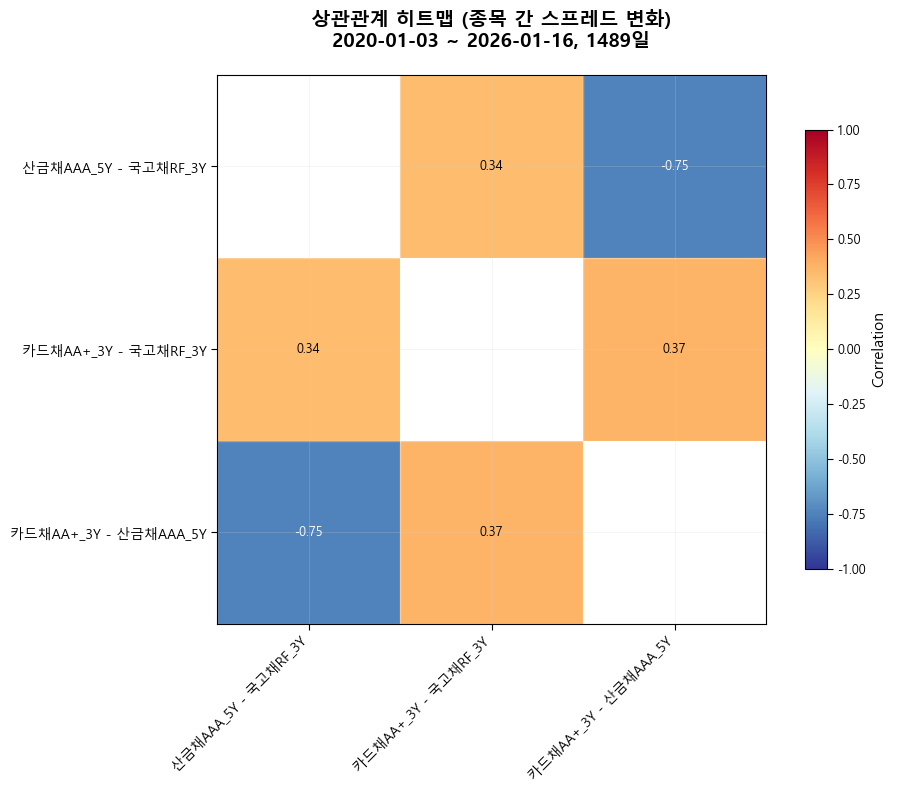


모드: 종목 간 스프레드 변화
기간: 2020-01-03 ~ 2026-01-16 (1489일)
항목: 3개
상관계수: 평균 -0.014, 최소 -0.749, 최대 0.370


In [9]:
# 셀 8: 상관관계 히트맵
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from typing import Optional, List
from itertools import combinations
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

# 분석할 종목 (None = 전체)
COLUMNS = [
    '국고채RF_3Y',
    '산금채AAA_5Y',
    '카드채AA+_3Y',
]

# 분석 모드
# - 'rates'              : 금리 수준
# - 'rates_changes'      : 금리 변화
# - 'spreads'            : 종목 간 스프레드 (B-A, C-A, C-B)
# - 'spreads_changes'    : 종목 간 스프레드 변화
# - 'spreads_vs_ktb'     : 국고채 대비 스프레드 (엑셀 시트)
# - 'spreads_vs_ktb_changes' : 국고채 대비 스프레드 변화
MODE = 'spreads_changes'

# 기간 (None = 전체)
START_DATE = None
END_DATE = None

# 그래프 옵션
TITLE = None
FIGSIZE = (10, 8)
CMAP = 'RdYlBu_r'
MASK_DIAGONAL = True
MASK_UPPER = False

# 폰트
FONT_FAMILY = 'Malgun Gothic'
TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 10
ANNOT_FONTSIZE = 9
SHOW_VALUES = True

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────


def build_spreads(rates: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    종목 쌍별 스프레드 계산
    [A, B, C] → B-A, C-A, C-B
    """
    result = pd.DataFrame(index=rates.index)
    
    for i, j in combinations(range(len(columns)), 2):
        col_a = columns[i]
        col_b = columns[j]
        name = f"{col_b} - {col_a}"
        result[name] = rates[col_b] - rates[col_a]
    
    return result


def build_analysis_data(
    rates: pd.DataFrame,
    spreads_vs_ktb: pd.DataFrame,
    columns: Optional[List[str]],
    mode: str
) -> pd.DataFrame:
    """
    모드에 따른 분석 데이터 생성
    """
    # 데이터 소스 선택
    if mode in ['spreads_vs_ktb', 'spreads_vs_ktb_changes']:
        source = spreads_vs_ktb
    else:
        source = rates
    
    # 컬럼 선택
    if columns is None:
        cols = source.columns.tolist()
    else:
        missing = [c for c in columns if c not in source.columns]
        if missing:
            print(f"⚠️ 존재하지 않는 종목: {missing}")
        cols = [c for c in columns if c in source.columns]
        if not cols:
            raise ValueError("유효한 종목이 없습니다")
    
    # 모드별 처리
    if mode == 'rates':
        return source[cols].dropna()
    
    elif mode == 'rates_changes':
        return source[cols].diff().dropna()
    
    elif mode == 'spreads':
        if len(cols) < 2:
            raise ValueError("spreads 모드는 최소 2개 종목이 필요합니다")
        return build_spreads(source, cols).dropna()
    
    elif mode == 'spreads_changes':
        if len(cols) < 2:
            raise ValueError("spreads_changes 모드는 최소 2개 종목이 필요합니다")
        return build_spreads(source, cols).diff().dropna()
    
    elif mode == 'spreads_vs_ktb':
        return source[cols].dropna()
    
    elif mode == 'spreads_vs_ktb_changes':
        return source[cols].diff().dropna()
    
    else:
        raise ValueError(f"알 수 없는 모드: {mode}")


def plot_correlation_heatmap(data: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """상관관계 히트맵"""
    
    start_date = kwargs.get('start_date')
    end_date = kwargs.get('end_date')
    figsize = kwargs.get('figsize', (10, 8))
    cmap = kwargs.get('cmap', 'RdYlBu_r')
    mask_diagonal = kwargs.get('mask_diagonal', True)
    mask_upper = kwargs.get('mask_upper', False)
    font_family = kwargs.get('font_family', 'Malgun Gothic')
    title_fontsize = kwargs.get('title_fontsize', 14)
    label_fontsize = kwargs.get('label_fontsize', 10)
    annot_fontsize = kwargs.get('annot_fontsize', 9)
    show_values = kwargs.get('show_values', True)
    title = kwargs.get('title')
    mode = kwargs.get('mode', '')
    
    plt.rcParams['font.family'] = font_family
    plt.rcParams['axes.unicode_minus'] = False
    
    df = data.copy()
    
    # 기간 필터링
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]
    
    if df.empty:
        raise ValueError("데이터가 없습니다")
    
    # 상관계수
    corr = df.corr()
    n = len(corr)
    
    # 마스크
    display = corr.copy()
    if mask_diagonal:
        np.fill_diagonal(display.values, np.nan)
    if mask_upper:
        display.values[np.triu_indices(n, k=1)] = np.nan
    
    # 그래프
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(display.values, cmap=cmap,
                   norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1),
                   aspect='equal')
    
    plt.colorbar(im, ax=ax, shrink=0.8, label='Correlation')
    
    # 값 표시
    if show_values:
        for i in range(n):
            for j in range(n):
                val = display.iloc[i, j]
                if not np.isnan(val):
                    color = 'white' if abs(val) > 0.6 else 'black'
                    ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                           fontsize=annot_fontsize, color=color)
    
    # 축
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr.columns, fontsize=label_fontsize, rotation=45, ha='right')
    ax.set_yticklabels(corr.index, fontsize=label_fontsize)
    
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)
    
    # 제목
    start_str = df.index[0].strftime('%Y-%m-%d')
    end_str = df.index[-1].strftime('%Y-%m-%d')
    
    mode_names = {
        'rates': '금리 수준',
        'rates_changes': '금리 변화',
        'spreads': '종목 간 스프레드',
        'spreads_changes': '종목 간 스프레드 변화',
        'spreads_vs_ktb': '국고채 대비 스프레드',
        'spreads_vs_ktb_changes': '국고채 대비 스프레드 변화'
    }
    mode_label = mode_names.get(mode, mode)
    
    if title is None:
        title = f"상관관계 히트맵 ({mode_label})\n{start_str} ~ {end_str}, {len(df)}일"
    
    ax.set_title(title, fontsize=title_fontsize, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # 요약
    print(f"\n{'='*50}")
    print(f"모드: {mode_label}")
    print(f"기간: {start_str} ~ {end_str} ({len(df)}일)")
    print(f"항목: {n}개")
    vals = corr.values[np.triu_indices(n, k=1)]
    if len(vals) > 0:
        print(f"상관계수: 평균 {vals.mean():.3f}, 최소 {vals.min():.3f}, 최대 {vals.max():.3f}")
    
    return corr


# ============================================================
# 종목명 확인
# ============================================================
#print("📋 사용 가능한 종목명:")
#for i, col in enumerate(rates.columns, 1):
#    print(f"  {i:2d}. '{col}'")
#print()
#
# ============================================================
# 실행
# ============================================================
print(f"🔧 모드: {MODE}")
print(f"🔧 선택 종목: {COLUMNS}\n")

analysis_data = build_analysis_data(rates, spreads_vs_ktb, COLUMNS, MODE)

print(f"📊 분석 항목 ({len(analysis_data.columns)}개):")
for col in analysis_data.columns:
    print(f"   • {col}")
print()

corr_matrix = plot_correlation_heatmap(
    analysis_data,
    start_date=START_DATE,
    end_date=END_DATE,
    title=TITLE,
    figsize=FIGSIZE,
    cmap=CMAP,
    mask_diagonal=MASK_DIAGONAL,
    mask_upper=MASK_UPPER,
    font_family=FONT_FAMILY,
    title_fontsize=TITLE_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
    annot_fontsize=ANNOT_FONTSIZE,
    show_values=SHOW_VALUES,
    mode=MODE
)

🔧 설정
   모드: spreads
   종목: ['국고채RF_3Y', '국고채RF_5Y', '국고채RF_10Y']
   롤링 윈도우: 20일
   분석 기간: 2025-01-01 ~ 2026-01-18
   히스토그램 기준: 2022.01~2026.01

📊 분석 대상 (3쌍):
   • (국고채RF_5Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_3Y)
     → 스프레드 = 국고채RF_10Y - 국고채RF_3Y − 국고채RF_5Y - 국고채RF_3Y
   • (국고채RF_5Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_5Y)
     → 스프레드 = 국고채RF_10Y - 국고채RF_5Y − 국고채RF_5Y - 국고채RF_3Y
   • (국고채RF_10Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_5Y)
     → 스프레드 = 국고채RF_10Y - 국고채RF_5Y − 국고채RF_10Y - 국고채RF_3Y



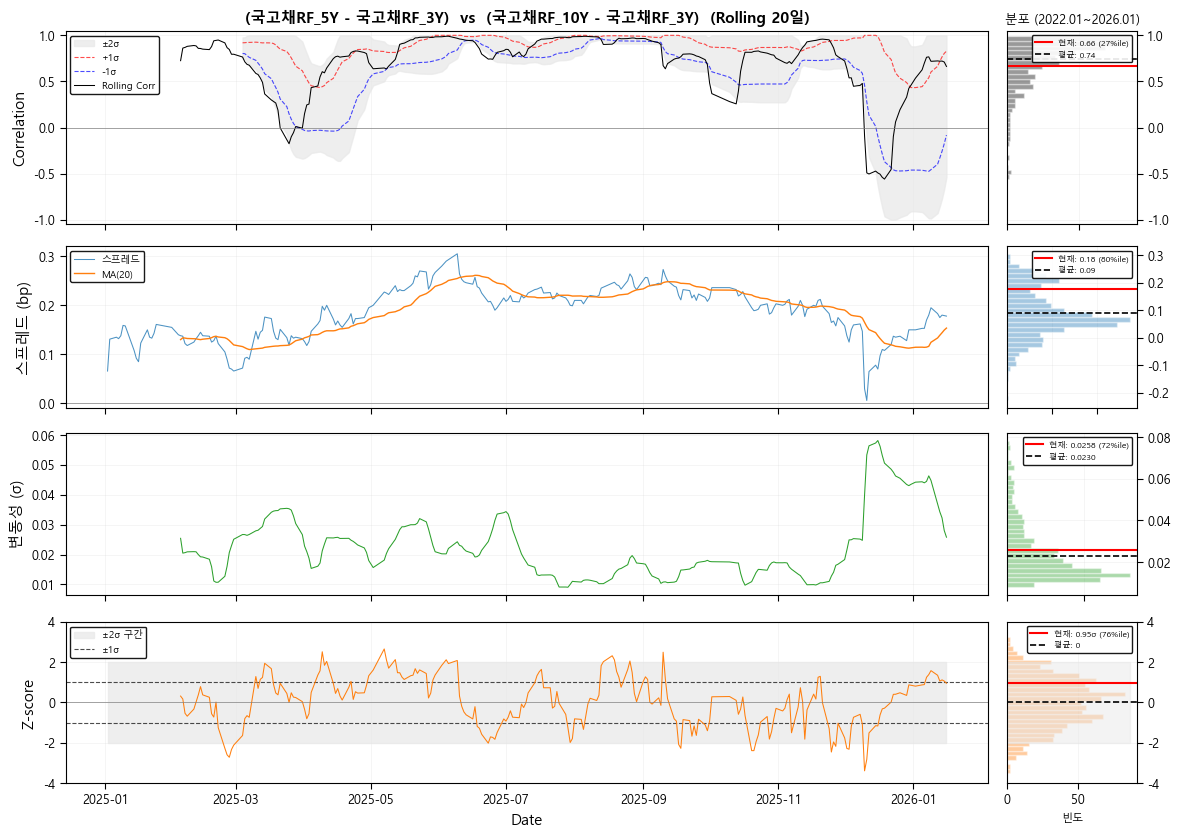


롤링 분석 요약: (국고채RF_5Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_3Y)
롤링 윈도우: 20일
분석 기간: 2025-02-04 ~ 2026-01-16
히스토그램 기준: 2022.01~2026.01

※ 스프레드 계산: 뒤 - 앞 (제목 'A vs B' → 스프레드 = B - A)

[상관계수]  현재: 0.663 (27%ile)
[스프레드]  현재: 0.1780 (80%ile)
[변동성]    현재: 0.0258 (72%ile)
[Z-score]   현재: 0.95σ (76%ile)


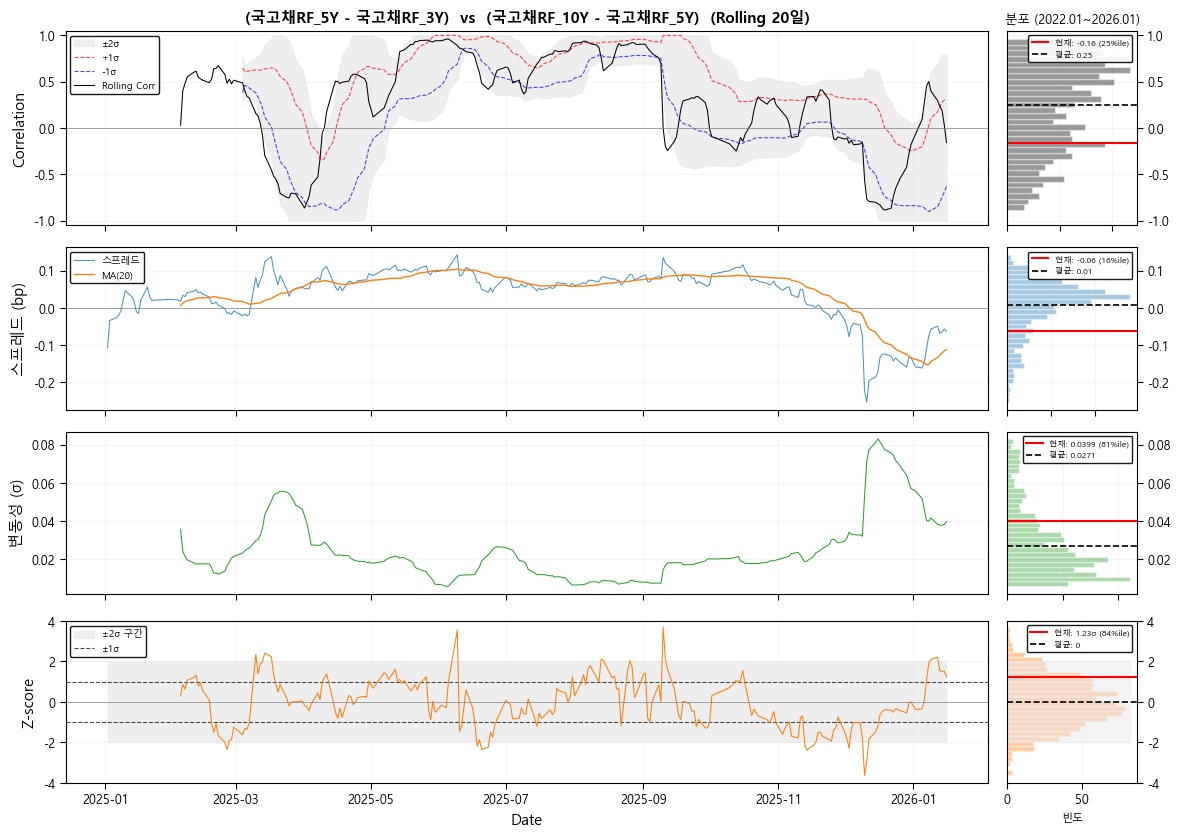


롤링 분석 요약: (국고채RF_5Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_5Y)
롤링 윈도우: 20일
분석 기간: 2025-02-04 ~ 2026-01-16
히스토그램 기준: 2022.01~2026.01

※ 스프레드 계산: 뒤 - 앞 (제목 'A vs B' → 스프레드 = B - A)

[상관계수]  현재: -0.158 (25%ile)
[스프레드]  현재: -0.0630 (16%ile)
[변동성]    현재: 0.0399 (81%ile)
[Z-score]   현재: 1.23σ (84%ile)


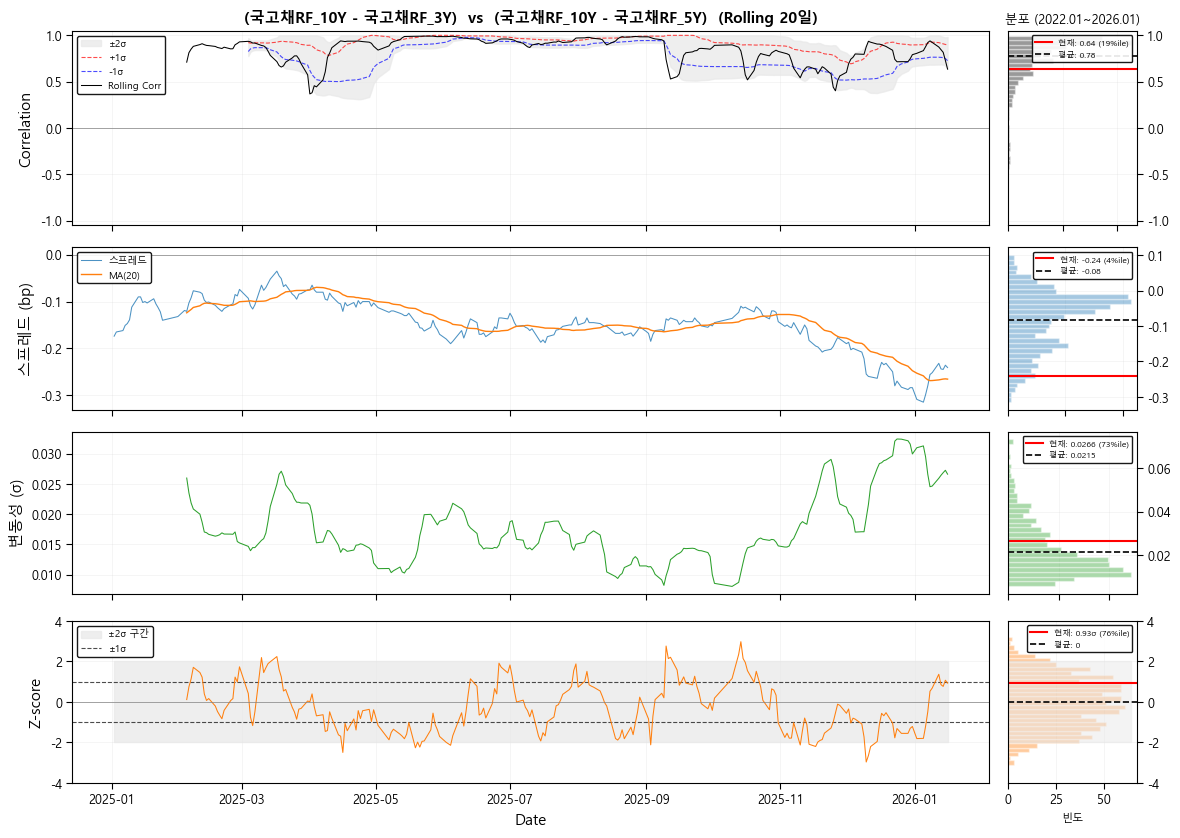


롤링 분석 요약: (국고채RF_10Y - 국고채RF_3Y)  vs  (국고채RF_10Y - 국고채RF_5Y)
롤링 윈도우: 20일
분석 기간: 2025-02-04 ~ 2026-01-16
히스토그램 기준: 2022.01~2026.01

※ 스프레드 계산: 뒤 - 앞 (제목 'A vs B' → 스프레드 = B - A)

[상관계수]  현재: 0.635 (19%ile)
[스프레드]  현재: -0.2410 (4%ile)
[변동성]    현재: 0.0266 (73%ile)
[Z-score]   현재: 0.93σ (76%ile)
📈 상관계수 요약 그래프
   총 3쌍 → 1페이지로 분할


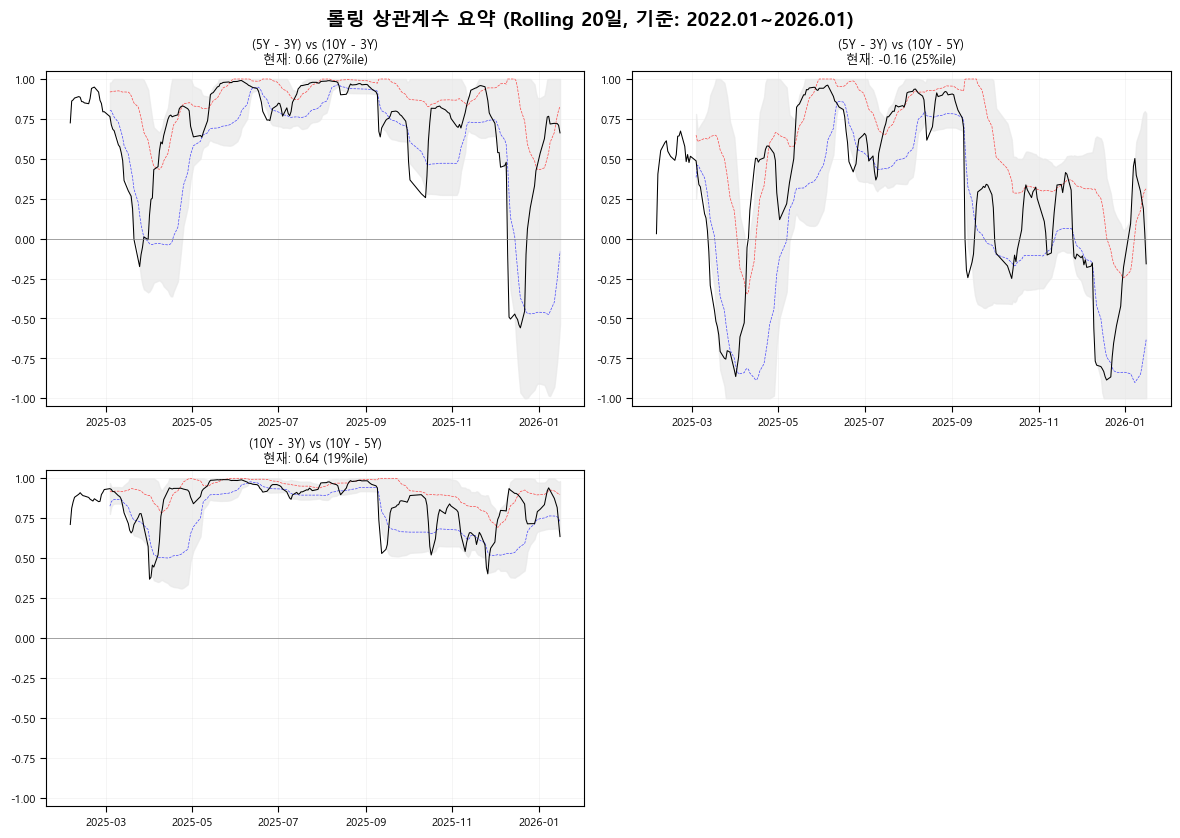


결과 저장 중... → K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Correlation\rolling_analysis_20260120_212534
  ✓ 그래프 저장: 01_국고채RF_5Y_-_국고채RF_3Y__vs__국고채RF_10Y_-_국고채RF_3Y.png
  ✓ 그래프 저장: 02_국고채RF_5Y_-_국고채RF_3Y__vs__국고채RF_10Y_-_국고채RF_5Y.png
  ✓ 그래프 저장: 03_국고채RF_10Y_-_국고채RF_3Y__vs__국고채RF_10Y_-_국고채RF_5Y.png
  ✓ 요약 그래프 저장: 00_correlation_summary.png
  ✓ 엑셀 저장: analysis_data.xlsx

✅ 저장 완료: K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Correlation\rolling_analysis_20260120_212534


In [ ]:
# 셀 9: 롤링 상관계수 시계열 분석
# ============================================================
# 수정 내용:
# 1. 스프레드 계산: col2 - col1 (뒤 - 앞)으로 통일
#    → 제목이 "A vs B"면 계산은 B - A
# 2. 히스토그램 기간 라벨: 월까지 표기 (2022.01~2026.01)
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import combinations
from typing import Optional, List, Tuple
from scipy import stats
import pandas as pd
import numpy as np
import os

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

# 롤링 윈도우 (거래일 기준)
ROLLING_WINDOW = 20

# 종목 (None = 셀 8 설정 따름)
COLUMNS_9 = ['국고채RF_3Y', '국고채RF_5Y', '국고채RF_10Y']

# 분석 모드 (None = 셀 8 설정 따름)
MODE_9 = 'spreads'

# 분석 기간 - 그래프 x축 범위 (None = 셀 8 설정 따름)
START_DATE_9 = '2025-01-01'
END_DATE_9 = '2026-01-18'

# 히스토그램 기준 기간 (None = 데이터 전체 기간)
HIST_START_DATE = '2025-01-01'
HIST_END_DATE = '2026-01-18'

# 저장 설정
SAVE_OUTPUT = True
OUTPUT_PATH = r'K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Correlation'

# 그래프 옵션
FONT_FAMILY_9 = 'Malgun Gothic'
LINE_WIDTH = 0.75

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────


# ============================================================
# 셀 8 설정 상속
# ============================================================
_columns = COLUMNS_9 if COLUMNS_9 is not None else COLUMNS
_mode = MODE_9 if MODE_9 is not None else MODE
_start = START_DATE_9 if START_DATE_9 is not None else START_DATE
_end = END_DATE_9 if END_DATE_9 is not None else END_DATE


def get_pair_names(columns: List[str], mode: str) -> List[Tuple[str, str, str]]:
    """
    분석할 쌍 목록 반환
    
    반환: [(display_name, col1, col2), ...]
    - display_name: "A vs B" 형태
    - 스프레드 계산 시: col2 - col1 (뒤 - 앞)
    """
    if mode in ['spreads', 'spreads_changes']:
        # 1단계: 스프레드 이름 생성 (뒤 - 앞)
        spread_names = []
        for i, j in combinations(range(len(columns)), 2):
            spread_names.append(f"{columns[j]} - {columns[i]}")
        
        # 2단계: 스프레드 쌍 조합
        pairs = []
        for i, j in combinations(range(len(spread_names)), 2):
            # 제목: "첫째 vs 둘째"
            # 계산: 둘째 - 첫째 (col2 - col1)
            display_name = f"({spread_names[i]})  vs  ({spread_names[j]})"
            pairs.append((display_name, spread_names[i], spread_names[j]))
        return pairs
    else:
        # rates, spreads_vs_ktb 등
        pairs = []
        for i, j in combinations(range(len(columns)), 2):
            # 제목: "앞 vs 뒤"
            # 계산: 뒤 - 앞 (col2 - col1)
            pairs.append((f"{columns[i]}  vs  {columns[j]}",
                         columns[i], columns[j]))
        return pairs


def calculate_rolling_corr(data: pd.DataFrame, col1: str, col2: str, window: int) -> pd.Series:
    """롤링 상관계수 계산"""
    return data[col1].rolling(window=window).corr(data[col2])


def calculate_rolling_stats(series: pd.Series, window: int) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """롤링 통계 계산"""
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    z_score = (series - rolling_mean) / rolling_std
    return rolling_mean, rolling_std, z_score


def calculate_percentile(value: float, distribution: pd.Series) -> float:
    """현재값의 백분위 계산"""
    clean_dist = distribution.dropna()
    return stats.percentileofscore(clean_dist, value)


def plot_rolling_analysis(
    data_full: pd.DataFrame,
    data_filtered: pd.DataFrame,
    data_hist: pd.DataFrame,
    col1: str,
    col2: str,
    pair_name: str,
    window: int,
    hist_period_label: str,
    **kwargs
) -> dict:
    """
    단일 쌍에 대한 롤링 분석 그래프
    
    스프레드 계산: col2 - col1 (뒤 - 앞)
    - 제목이 "A vs B"면 → 스프레드 = B - A
    """
    font_family = kwargs.get('font_family', 'Malgun Gothic')
    line_width = kwargs.get('line_width', 1.2)
    
    plt.rcParams['font.family'] = font_family
    plt.rcParams['axes.unicode_minus'] = False
    
    # ─────────────────────────────────────────────────────────
    # 데이터 계산
    # ─────────────────────────────────────────────────────────
    
    # 상관계수 (col1과 col2의 상관관계)
    corr_hist = calculate_rolling_corr(data_hist, col1, col2, window).dropna()
    corr_filtered = calculate_rolling_corr(data_filtered, col1, col2, window).dropna()
    corr_mean = corr_filtered.rolling(window=window).mean()
    corr_std = corr_filtered.rolling(window=window).std()
    
    # ========================================================
    # 핵심 수정: 스프레드 = col2 - col1 (뒤 - 앞)
    # 제목 "A vs B" → 계산 "B - A"
    # ========================================================
    spread_hist = data_hist[col2] - data_hist[col1]
    spread_filtered = data_filtered[col2] - data_filtered[col1]
    
    spread_mean, spread_std, spread_zscore = calculate_rolling_stats(spread_filtered, window)
    _, spread_std_hist, spread_zscore_hist = calculate_rolling_stats(spread_hist, window)
    
    # 백분위 계산
    corr_pct = calculate_percentile(corr_filtered.iloc[-1], corr_hist)
    spread_pct = calculate_percentile(spread_filtered.iloc[-1], spread_hist)
    std_pct = calculate_percentile(spread_std.iloc[-1], spread_std_hist.dropna())
    zscore_pct = calculate_percentile(spread_zscore.iloc[-1], spread_zscore_hist.dropna())
    
    # ─────────────────────────────────────────────────────────
    # 그래프 레이아웃 (A4 가로, 컴팩트)
    # ─────────────────────────────────────────────────────────
    fig = plt.figure(figsize=(11.69, 8.27), constrained_layout=True)
    
    gs = fig.add_gridspec(4, 6, height_ratios=[1.2, 1, 1, 1],
                          width_ratios=[1, 1, 1, 1, 1, 0.7],
                          hspace=0.08, wspace=0.08)
    
    ax_corr = fig.add_subplot(gs[0, :5])
    ax_corr_hist = fig.add_subplot(gs[0, 5])
    
    ax_spread = fig.add_subplot(gs[1, :5], sharex=ax_corr)
    ax_spread_hist = fig.add_subplot(gs[1, 5])
    
    ax_std = fig.add_subplot(gs[2, :5], sharex=ax_corr)
    ax_std_hist = fig.add_subplot(gs[2, 5])
    
    ax_zscore = fig.add_subplot(gs[3, :5], sharex=ax_corr)
    ax_zscore_hist = fig.add_subplot(gs[3, 5])
    
    # 색상
    corr_color = 'black'
    spread_color = '#1f77b4'
    std_color = '#2ca02c'
    zscore_color = '#ff7f0e'
    
    # ─────────────────────────────────────────────────────────
    # 1. 롤링 상관계수
    # ─────────────────────────────────────────────────────────
    upper_2s = (corr_mean + 2 * corr_std).clip(-1, 1)
    lower_2s = (corr_mean - 2 * corr_std).clip(-1, 1)
    ax_corr.fill_between(corr_filtered.index, lower_2s, upper_2s,
                         color='#e8e8e8', alpha=0.7, label='±2σ')
    
    upper_1s = (corr_mean + 1 * corr_std).clip(-1, 1)
    lower_1s = (corr_mean - 1 * corr_std).clip(-1, 1)
    ax_corr.plot(corr_filtered.index, upper_1s,
                 linestyle='--', color='red', linewidth=0.8, alpha=0.7, label='+1σ')
    ax_corr.plot(corr_filtered.index, lower_1s,
                 linestyle='--', color='blue', linewidth=0.8, alpha=0.7, label='-1σ')
    
    ax_corr.plot(corr_filtered.index, corr_filtered,
                 color=corr_color, linewidth=line_width, label='Rolling Corr')
    
    ax_corr.axhline(y=0, color='gray', linewidth=0.5)
    ax_corr.set_ylabel('Correlation')
    ax_corr.set_ylim(-1.05, 1.05)
    ax_corr.legend(loc='upper left', fontsize=7)
    ax_corr.set_title(f'{pair_name}  (Rolling {window}일)', fontsize=11, fontweight='bold')
    ax_corr.tick_params(axis='x', labelbottom=False)
    
    # 상관계수 히스토그램
    ax_corr_hist.hist(corr_hist.dropna(), bins=30, orientation='horizontal',
                      color=corr_color, alpha=0.4, edgecolor='white')
    ax_corr_hist.axhline(y=corr_filtered.iloc[-1], color='red', linewidth=1.5,
                         label=f'현재: {corr_filtered.iloc[-1]:.2f} ({corr_pct:.0f}%ile)')
    ax_corr_hist.axhline(y=corr_hist.mean(), color='black', linewidth=1.2,
                         linestyle='--', label=f'평균: {corr_hist.mean():.2f}')
    ax_corr_hist.set_title(f'분포 ({hist_period_label})', fontsize=9)
    ax_corr_hist.legend(loc='upper right', fontsize=6)
    ax_corr_hist.yaxis.tick_right()
    ax_corr_hist.set_ylim(-1.05, 1.05)
    ax_corr_hist.tick_params(axis='x', labelbottom=False)
    
    # ─────────────────────────────────────────────────────────
    # 2. 스프레드 수준 (col2 - col1)
    # ─────────────────────────────────────────────────────────
    ax_spread.plot(spread_filtered.index, spread_filtered,
                   color=spread_color, linewidth=line_width, alpha=0.8, label='스프레드')
    ax_spread.plot(spread_mean.index, spread_mean,
                   color='#ff7f0e', linewidth=1.0, label=f'MA({window})')
    ax_spread.axhline(y=0, color='gray', linewidth=0.5)
    ax_spread.set_ylabel('스프레드 (bp)')
    ax_spread.legend(loc='upper left', fontsize=7)
    ax_spread.tick_params(axis='x', labelbottom=False)
    
    spread_hist_clean = spread_hist.dropna()
    ax_spread_hist.hist(spread_hist_clean, bins=30, orientation='horizontal',
                        color=spread_color, alpha=0.4, edgecolor='white')
    ax_spread_hist.axhline(y=spread_filtered.iloc[-1], color='red', linewidth=1.5,
                           label=f'현재: {spread_filtered.iloc[-1]:.2f} ({spread_pct:.0f}%ile)')
    ax_spread_hist.axhline(y=spread_hist_clean.mean(), color='black', linewidth=1.2,
                           linestyle='--', label=f'평균: {spread_hist_clean.mean():.2f}')
    ax_spread_hist.legend(loc='upper right', fontsize=6)
    ax_spread_hist.yaxis.tick_right()
    ax_spread_hist.tick_params(axis='x', labelbottom=False)
    
    # ─────────────────────────────────────────────────────────
    # 3. 롤링 표준편차
    # ─────────────────────────────────────────────────────────
    ax_std.plot(spread_std.index, spread_std, color=std_color, linewidth=line_width)
    ax_std.set_ylabel('변동성 (σ)')
    ax_std.tick_params(axis='x', labelbottom=False)
    
    spread_std_hist_clean = spread_std_hist.dropna()
    ax_std_hist.hist(spread_std_hist_clean, bins=30, orientation='horizontal',
                     color=std_color, alpha=0.4, edgecolor='white')
    ax_std_hist.axhline(y=spread_std.iloc[-1], color='red', linewidth=1.5,
                        label=f'현재: {spread_std.iloc[-1]:.4f} ({std_pct:.0f}%ile)')
    ax_std_hist.axhline(y=spread_std_hist_clean.mean(), color='black', linewidth=1.2,
                        linestyle='--', label=f'평균: {spread_std_hist_clean.mean():.4f}')
    ax_std_hist.legend(loc='upper right', fontsize=6)
    ax_std_hist.yaxis.tick_right()
    ax_std_hist.tick_params(axis='x', labelbottom=False)
    
    # ─────────────────────────────────────────────────────────
    # 4. 롤링 Z-score
    # ─────────────────────────────────────────────────────────
    # 2σ 음영 (옅은 회색)
    ax_zscore.fill_between(spread_zscore.index, -2, 2,
                           color='#e8e8e8', alpha=0.7, label='±2σ 구간')
    
    # 1σ 점선 (검정색)
    ax_zscore.axhline(y=1, color='black', linewidth=0.8, linestyle='--', alpha=0.7, label='±1σ')
    ax_zscore.axhline(y=-1, color='black', linewidth=0.8, linestyle='--', alpha=0.7)
    
    ax_zscore.plot(spread_zscore.index, spread_zscore, color=zscore_color, linewidth=line_width)
    ax_zscore.axhline(y=0, color='gray', linewidth=0.5)
    ax_zscore.set_ylabel('Z-score')
    ax_zscore.set_xlabel('Date')
    ax_zscore.set_ylim(-4, 4)
    ax_zscore.legend(loc='upper left', fontsize=7)
    
    spread_zscore_hist_clean = spread_zscore_hist.dropna()
    ax_zscore_hist.hist(spread_zscore_hist_clean, bins=30, orientation='horizontal',
                        color=zscore_color, alpha=0.4, edgecolor='white')
    ax_zscore_hist.axhline(y=spread_zscore.iloc[-1], color='red', linewidth=1.5,
                           label=f'현재: {spread_zscore.iloc[-1]:.2f}σ ({zscore_pct:.0f}%ile)')
    ax_zscore_hist.axhline(y=0, color='black', linewidth=1.2,
                           linestyle='--', label='평균: 0')
    ax_zscore_hist.fill_between([0, ax_zscore_hist.get_xlim()[1] if ax_zscore_hist.get_xlim()[1] > 0 else 100],
                                 -2, 2, color='#e8e8e8', alpha=0.5)
    ax_zscore_hist.legend(loc='upper right', fontsize=6)
    ax_zscore_hist.yaxis.tick_right()
    ax_zscore_hist.set_xlabel('빈도', fontsize=8)
    ax_zscore_hist.set_ylim(-4, 4)
    
    plt.show()
    
    # ─────────────────────────────────────────────────────────
    # 요약 출력
    # ─────────────────────────────────────────────────────────
    print(f"\n{'='*60}")
    print(f"롤링 분석 요약: {pair_name}")
    print(f"{'='*60}")
    print(f"롤링 윈도우: {window}일")
    print(f"분석 기간: {corr_filtered.index[0].strftime('%Y-%m-%d')} ~ {corr_filtered.index[-1].strftime('%Y-%m-%d')}")
    print(f"히스토그램 기준: {hist_period_label}")
    print(f"\n※ 스프레드 계산: 뒤 - 앞 (제목 'A vs B' → 스프레드 = B - A)")
    print(f"\n[상관계수]  현재: {corr_filtered.iloc[-1]:.3f} ({corr_pct:.0f}%ile)")
    print(f"[스프레드]  현재: {spread_filtered.iloc[-1]:.4f} ({spread_pct:.0f}%ile)")
    print(f"[변동성]    현재: {spread_std.iloc[-1]:.4f} ({std_pct:.0f}%ile)")
    print(f"[Z-score]   현재: {spread_zscore.iloc[-1]:.2f}σ ({zscore_pct:.0f}%ile)")
    
    return {
        'pair_name': pair_name,
        'col1': col1,
        'col2': col2,
        'corr_filtered': corr_filtered,
        'corr_mean': corr_mean,
        'corr_std': corr_std,
        'spread_filtered': spread_filtered,
        'spread_std': spread_std,
        'spread_zscore': spread_zscore,
        'corr_pct': corr_pct,
        'spread_pct': spread_pct,
        'std_pct': std_pct,
        'zscore_pct': zscore_pct,
        'fig': fig
    }


def plot_correlation_summary(results: List[dict], hist_period_label: str, window: int, **kwargs) -> List[plt.Figure]:
    """
    상관계수만 모아서 요약 그래프 출력
    """
    font_family = kwargs.get('font_family', 'Malgun Gothic')
    line_width = kwargs.get('line_width', 0.75)
    
    plt.rcParams['font.family'] = font_family
    plt.rcParams['axes.unicode_minus'] = False
    
    n_total = len(results)
    if n_total == 0:
        return []
    
    MAX_PER_PAGE = 12
    n_pages = (n_total + MAX_PER_PAGE - 1) // MAX_PER_PAGE
    
    print(f"   총 {n_total}쌍 → {n_pages}페이지로 분할")
    
    figures = []
    
    for page in range(n_pages):
        start_idx = page * MAX_PER_PAGE
        end_idx = min(start_idx + MAX_PER_PAGE, n_total)
        page_results = results[start_idx:end_idx]
        n_items = len(page_results)
        
        # 개수에 따라 그리드 자동 선택
        if n_items == 1:
            nrows, ncols = 1, 1
        elif n_items == 2:
            nrows, ncols = 1, 2
        elif n_items <= 4:
            nrows, ncols = 2, 2
        elif n_items <= 6:
            nrows, ncols = 2, 3
        elif n_items <= 9:
            nrows, ncols = 3, 3
        else:
            nrows, ncols = 3, 4
        
        # ─────────────────────────────────────────────────────
        # 핵심: constrained_layout=True 사용
        # ─────────────────────────────────────────────────────
        fig, axes = plt.subplots(nrows, ncols, figsize=(11.69, 8.27), 
                                  constrained_layout=True)
        
        # axes 배열 정규화
        if nrows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = axes.reshape(1, -1)
        elif ncols == 1:
            axes = axes.reshape(-1, 1)
        
        # 메인 타이틀
        page_label = f" ({page+1}/{n_pages})" if n_pages > 1 else ""
        fig.suptitle(
            f'롤링 상관계수 요약 (Rolling {window}일, 기준: {hist_period_label}){page_label}',
            fontsize=14, fontweight='bold'
        )
        
        # 각 subplot 그리기
        for idx, result in enumerate(page_results):
            row = idx // ncols
            col = idx % ncols
            ax = axes[row, col]
            
            corr = result['corr_filtered']
            corr_mean = result['corr_mean']
            corr_std = result['corr_std']
            pair_name = result['pair_name']
            corr_pct = result['corr_pct']
            
            # 2σ 음영
            upper_2s = (corr_mean + 2 * corr_std).clip(-1, 1)
            lower_2s = (corr_mean - 2 * corr_std).clip(-1, 1)
            ax.fill_between(corr.index, lower_2s, upper_2s,
                            color='#e8e8e8', alpha=0.7)
            
            # 1σ 점선
            upper_1s = (corr_mean + 1 * corr_std).clip(-1, 1)
            lower_1s = (corr_mean - 1 * corr_std).clip(-1, 1)
            ax.plot(corr.index, upper_1s, linestyle='--', color='red', 
                    linewidth=0.5, alpha=0.7)
            ax.plot(corr.index, lower_1s, linestyle='--', color='blue', 
                    linewidth=0.5, alpha=0.7)
            
            # 상관계수 선
            ax.plot(corr.index, corr, color='black', linewidth=line_width)
            ax.axhline(y=0, color='gray', linewidth=0.5)
            ax.set_ylim(-1.05, 1.05)
            
            # 타이틀 간소화
            short_name = pair_name.replace('국고채RF_', '').replace('  ', ' ')
            if len(short_name) > 30 and ' vs ' in short_name:
                parts = short_name.split(' vs ')
                short_name = f"{parts[0]}\nvs {parts[1]}"
            
            ax.set_title(f"{short_name}\n현재: {corr.iloc[-1]:.2f} ({corr_pct:.0f}%ile)",
                         fontsize=9)
            ax.tick_params(axis='both', labelsize=8)
        
        # 빈 subplot 숨기기
        for idx in range(n_items, nrows * ncols):
            row = idx // ncols
            col = idx % ncols
            axes[row, col].axis('off')
        
        # ─────────────────────────────────────────────────────
        # tight_layout(), subplots_adjust() 사용하지 않음!
        # constrained_layout이 자동으로 처리
        # ─────────────────────────────────────────────────────
        
        figures.append(fig)
        plt.show()
    
    return figures


def save_results(results: List[dict], summary_figs: List[plt.Figure], 
                 output_path: str, hist_period_label: str, window: int, **kwargs):
    """모든 그래프와 분석 결과를 지정 경로에 저장"""
    import datetime
    
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = os.path.join(output_path, f'rolling_analysis_{timestamp}')
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"결과 저장 중... → {save_dir}")
    print(f"{'='*60}")
    
    # 1. 개별 그래프 저장
    for i, result in enumerate(results):
        fig = result.get('fig')
        if fig:
            safe_name = result['pair_name'].replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '')[:50]
            filepath = os.path.join(save_dir, f'{i+1:02d}_{safe_name}.png')
            fig.savefig(filepath, dpi=150, bbox_inches='tight')
            print(f"  ✓ 그래프 저장: {os.path.basename(filepath)}")
    
    # 2. 요약 그래프 저장 (이미 생성된 것 사용)
    for i, fig in enumerate(summary_figs):
        page_label = f'_page{i+1}' if len(summary_figs) > 1 else ''
        filepath = os.path.join(save_dir, f'00_correlation_summary{page_label}.png')
        fig.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"  ✓ 요약 그래프 저장: {os.path.basename(filepath)}")
    
    # 3. 엑셀 저장
    excel_path = os.path.join(save_dir, 'analysis_data.xlsx')
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        summary_data = []
        for result in results:
            summary_data.append({
                '분석 쌍': result['pair_name'],
                '상관계수 (현재)': result['corr_filtered'].iloc[-1],
                '상관계수 (%ile)': result['corr_pct'],
                '스프레드 (현재)': result['spread_filtered'].iloc[-1],
                '스프레드 (%ile)': result['spread_pct'],
                '변동성 (현재)': result['spread_std'].iloc[-1],
                '변동성 (%ile)': result['std_pct'],
                'Z-score (현재)': result['spread_zscore'].iloc[-1],
                'Z-score (%ile)': result['zscore_pct'],
            })
        pd.DataFrame(summary_data).to_excel(writer, sheet_name='요약', index=False)
        
        for result in results:
            safe_name = result['pair_name'][:20].replace('/', '_')
            df = pd.DataFrame({
                '상관계수': result['corr_filtered'],
                '스프레드': result['spread_filtered'],
                '변동성': result['spread_std'],
                'Z-score': result['spread_zscore']
            })
            df.to_excel(writer, sheet_name=safe_name)
    
    print(f"  ✓ 엑셀 저장: {os.path.basename(excel_path)}")
    print(f"\n✅ 저장 완료: {save_dir}")


# ============================================================
# 데이터 준비 및 실행
# ============================================================

data_full = build_analysis_data(rates, spreads_vs_ktb, _columns, _mode)

data_filtered = data_full.copy()
if _start:
    data_filtered = data_filtered[data_filtered.index >= pd.to_datetime(_start)]
if _end:
    data_filtered = data_filtered[data_filtered.index <= pd.to_datetime(_end)]

data_hist = data_full.copy()
if HIST_START_DATE:
    data_hist = data_hist[data_hist.index >= pd.to_datetime(HIST_START_DATE)]
if HIST_END_DATE:
    data_hist = data_hist[data_hist.index <= pd.to_datetime(HIST_END_DATE)]

# ========================================================
# 수정: 히스토그램 기간 라벨을 월까지 표기
# ========================================================
hist_start_str = data_hist.index[0].strftime('%Y.%m')
hist_end_str = data_hist.index[-1].strftime('%Y.%m')
hist_period_label = f"{hist_start_str}~{hist_end_str}"

pairs = get_pair_names(_columns, _mode)

print(f"🔧 설정")
print(f"   모드: {_mode}")
print(f"   종목: {_columns}")
print(f"   롤링 윈도우: {ROLLING_WINDOW}일")
print(f"   분석 기간: {_start or '전체'} ~ {_end or '전체'}")
print(f"   히스토그램 기준: {hist_period_label}")
print(f"\n📊 분석 대상 ({len(pairs)}쌍):")
for name, col1, col2 in pairs:
    print(f"   • {name}")
    print(f"     → 스프레드 = {col2} − {col1}")
print()

all_results = []
for pair_name, col1, col2 in pairs:
    result = plot_rolling_analysis(
        data_full=data_full,
        data_filtered=data_filtered,
        data_hist=data_hist,
        col1=col1,
        col2=col2,
        pair_name=pair_name,
        window=ROLLING_WINDOW,
        hist_period_label=hist_period_label,
        font_family=FONT_FAMILY_9,
        line_width=LINE_WIDTH
    )
    all_results.append(result)

print("📈 상관계수 요약 그래프")
print(f"{'='*60}")
summary_figs = plot_correlation_summary(all_results, hist_period_label, ROLLING_WINDOW,
                                         font_family=FONT_FAMILY_9, line_width=LINE_WIDTH)

if SAVE_OUTPUT:
    # summary_figs를 파라미터로 전달
    save_results(all_results, summary_figs, OUTPUT_PATH, hist_period_label, ROLLING_WINDOW,
                 font_family=FONT_FAMILY_9, line_width=LINE_WIDTH)

📈 종목 간 금리 수준 비교
   종목: ['국고채RF_3Y', '국고채RF_5Y', '국고채RF_10Y', '카드채AA+_1Y', '카드채AA+_2Y', '카드채AA+_3Y', '캐피탈채AA-_1Y']
   기간: 2024-01-01 ~ 2026-01-18
   ±1σ 표시: False
   ±2σ 표시: False

   총 21쌍 → 2페이지


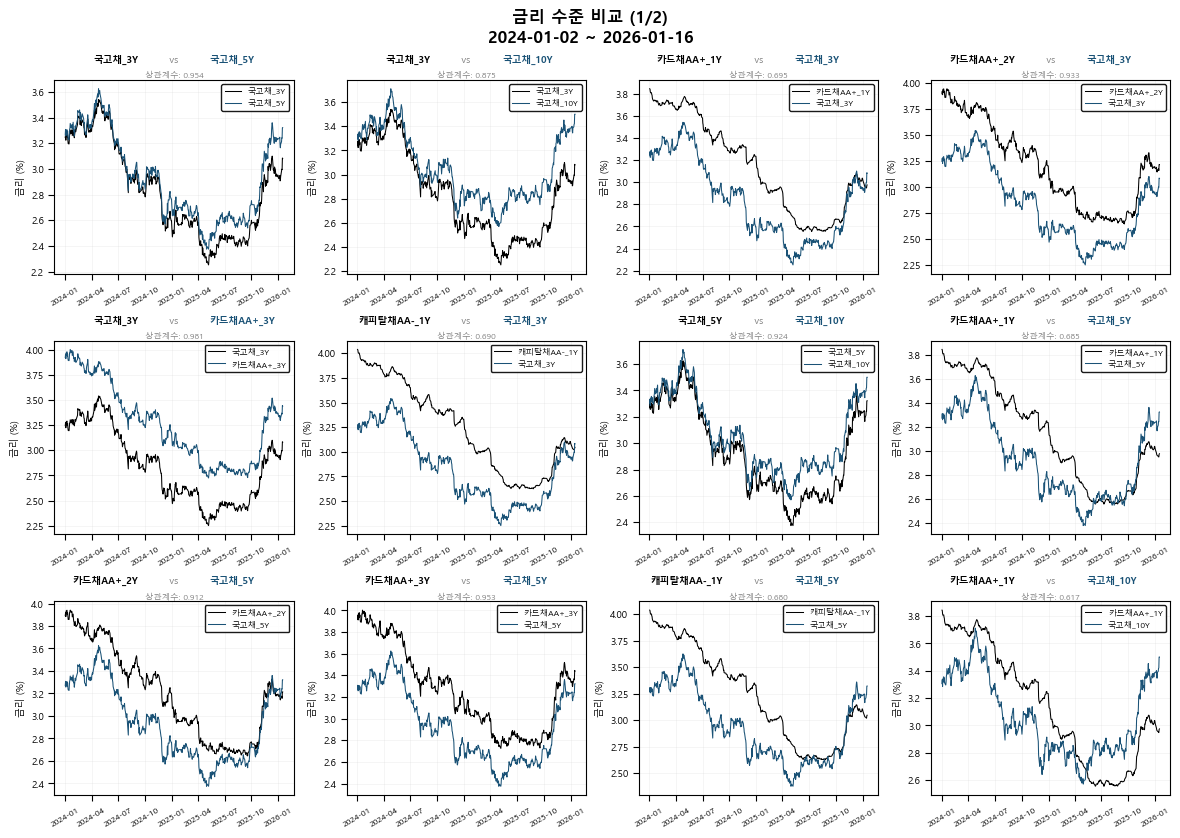

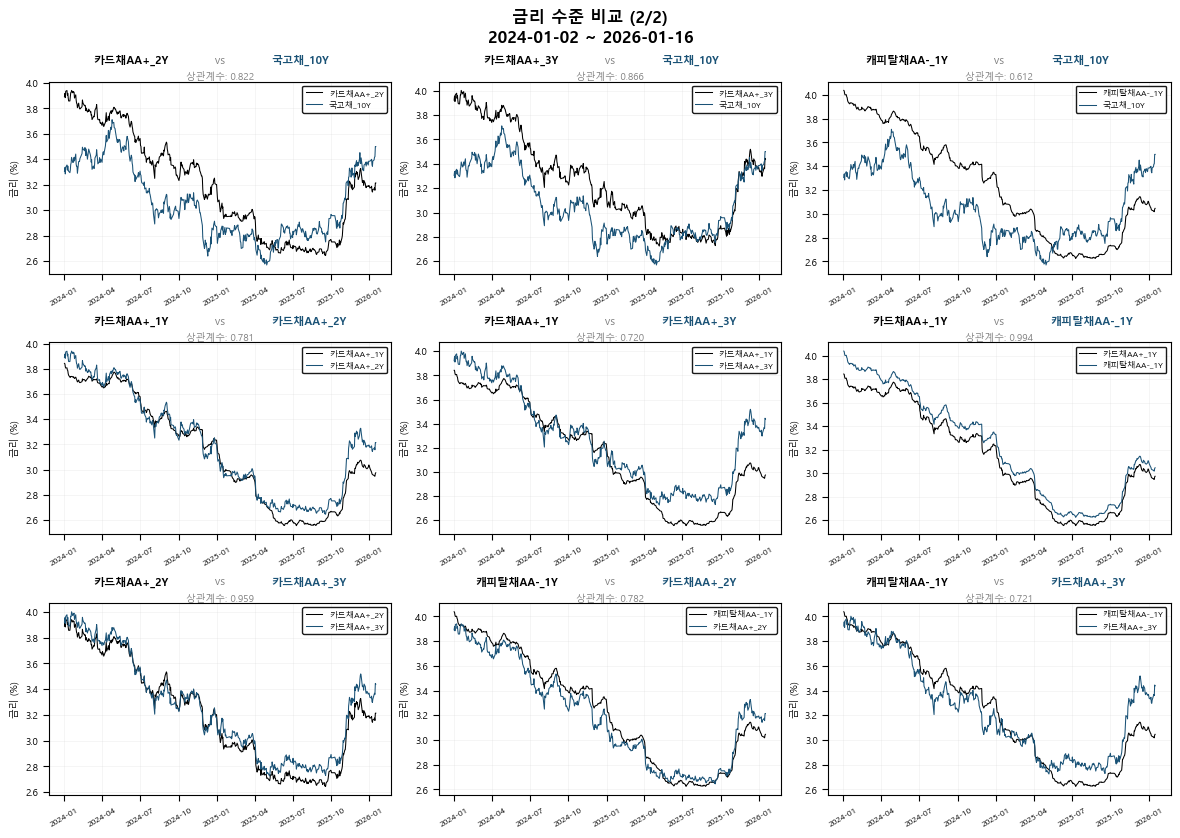


✅ 완료: 2페이지 생성
   📊 그래프 저장: K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Comparison\금리수준비교_p1.png
   📊 그래프 저장: K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Comparison\금리수준비교_p2.png
   📁 엑셀 저장: K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Comparison\금리수준비교_분석결과.xlsx

✅ 저장 완료: K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Comparison


In [18]:
# 셀 10: 종목 간 금리 수준 비교 그래프
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from itertools import combinations
from typing import List, Tuple
import re
import os  # 추가

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

# 비교할 종목들
COMPARE_COLUMNS = [
    '국고채RF_3Y',
    '국고채RF_5Y', 
    '국고채RF_10Y',
    '카드채AA+_1Y',
    '카드채AA+_2Y',
    '카드채AA+_3Y',
    '캐피탈채AA-_1Y',
]

# 분석 기간 (None = 전체)
COMPARE_START = '2024-01-01'
COMPARE_END = '2026-01-18'

# 표준편차 표시 옵션
SHOW_1SIGMA = False     # +1σ/-1σ 점선 (빨강/보라)
SHOW_2SIGMA = False     # ±2σ 음영 (옅은 회색)

# 롤링 윈도우 (표준편차 계산용)
COMPARE_WINDOW = 20

# 그래프 색상
COLOR_PRIMARY = 'black'         # 첫 번째 종목 (만기 짧은 쪽)
COLOR_SECONDARY = '#1a5276'   # 두 번째 종목

# 그래프 옵션
FONT_FAMILY_10 = 'Malgun Gothic'
LINE_WIDTH_10 = 0.75

# ─────────────────────────────────────────────────────────────
# 저장 경로 설정 (추가)
# ─────────────────────────────────────────────────────────────
SAVE_DIR = r'K:\부서 공유\FI운용1부\10. 개인별폴더\김현수\제안\협업\Comparison'
SAVE_GRAPH = True       # 그래프 저장 여부
SAVE_EXCEL = True       # 엑셀 저장 여부

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────


# ============================================================
# 헬퍼 함수
# ============================================================

def parse_bond_name(name: str) -> dict:
    """종목명 파싱: 섹터, 신용등급, 만기 추출"""
    match = re.match(r'(.+?)(AAA|AA\+|AA|AA-|A\+|A|A-|BBB\+|BBB|BBB-|RF)?_(\d+)Y', name)
    
    if match:
        sector = match.group(1)
        rating = match.group(2) if match.group(2) else 'RF'
        maturity = int(match.group(3))
        return {'sector': sector, 'rating': rating, 'maturity': maturity, 'name': name}
    
    return {'sector': name, 'rating': 'ZZZ', 'maturity': 999, 'name': name}


def get_rating_rank(rating: str) -> int:
    """신용등급 순위 (숫자 작을수록 높은 등급)"""
    rating_order = {
        'RF': 0, 'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
        'A+': 5, 'A': 6, 'A-': 7, 'BBB+': 8, 'BBB': 9, 'BBB-': 10,
    }
    return rating_order.get(rating, 99)


def compare_bonds(name1: str, name2: str) -> Tuple[str, str]:
    """두 종목 비교 → (검정색 종목, 파란색 종목) 반환"""
    bond1 = parse_bond_name(name1)
    bond2 = parse_bond_name(name2)
    
    # 1. 만기 비교
    if bond1['maturity'] != bond2['maturity']:
        if bond1['maturity'] < bond2['maturity']:
            return (name1, name2)
        else:
            return (name2, name1)
    
    # 2. 신용등급 비교
    rank1 = get_rating_rank(bond1['rating'])
    rank2 = get_rating_rank(bond2['rating'])
    
    if rank1 != rank2:
        if rank1 < rank2:
            return (name1, name2)
        else:
            return (name2, name1)
    
    # 3. 섹터명 ㄱㄴㄷ순
    if bond1['sector'] <= bond2['sector']:
        return (name1, name2)
    else:
        return (name2, name1)


def get_all_pairs(columns: List[str]) -> List[Tuple[str, str, str]]:
    """모든 조합 생성"""
    pairs = []
    for col1, col2 in combinations(columns, 2):
        black_col, blue_col = compare_bonds(col1, col2)
        display_name = f"{black_col} vs {blue_col}"
        pairs.append((display_name, black_col, blue_col))
    return pairs


def format_label(name: str) -> str:
    """종목명을 라벨용으로 정리 (RF_ → _)"""
    return name.replace('RF_', '_')


# ============================================================
# 그래프 함수
# ============================================================

def plot_rate_comparison(
    data: pd.DataFrame,
    returns: pd.DataFrame,
    pairs: List[Tuple[str, str, str]],
    window: int,
    show_1sigma: bool,
    show_2sigma: bool,
    start_date: str,
    end_date: str,
    **kwargs
) -> List[plt.Figure]:
    """종목 간 금리 수준 비교 그래프"""
    
    font_family = kwargs.get('font_family', 'Malgun Gothic')
    line_width = kwargs.get('line_width', 0.75)
    color_primary = kwargs.get('color_primary', 'black')
    color_secondary = kwargs.get('color_secondary', 'steelblue')
    
    plt.rcParams['font.family'] = font_family
    plt.rcParams['axes.unicode_minus'] = False
    
    n_total = len(pairs)
    if n_total == 0:
        return []
    
    # 기간 필터링
    plot_data = data.copy()
    plot_returns = returns.copy()
    
    if start_date:
        plot_data = plot_data[plot_data.index >= pd.to_datetime(start_date)]
        plot_returns = plot_returns[plot_returns.index >= pd.to_datetime(start_date)]
    if end_date:
        plot_data = plot_data[plot_data.index <= pd.to_datetime(end_date)]
        plot_returns = plot_returns[plot_returns.index <= pd.to_datetime(end_date)]
    
    period_label = f"{plot_data.index[0].strftime('%Y-%m-%d')} ~ {plot_data.index[-1].strftime('%Y-%m-%d')}"
    
    # 페이지 분할
    MAX_PER_PAGE = 12
    n_pages = (n_total + MAX_PER_PAGE - 1) // MAX_PER_PAGE
    
    print(f"   총 {n_total}쌍 → {n_pages}페이지")
    
    figures = []
    
    for page in range(n_pages):
        start_idx = page * MAX_PER_PAGE
        end_idx = min(start_idx + MAX_PER_PAGE, n_total)
        page_pairs = pairs[start_idx:end_idx]
        n_items = len(page_pairs)
        
        # 그리드 자동 선택
        if n_items == 1:
            nrows, ncols = 1, 1
        elif n_items == 2:
            nrows, ncols = 1, 2
        elif n_items <= 4:
            nrows, ncols = 2, 2
        elif n_items <= 6:
            nrows, ncols = 2, 3
        elif n_items <= 9:
            nrows, ncols = 3, 3
        else:
            nrows, ncols = 3, 4
        
        # Figure 생성 (A4 가로)
        fig, axes = plt.subplots(nrows, ncols, figsize=(11.69, 8.27), 
                                  constrained_layout=True)
        
        # axes 정규화
        if nrows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = axes.reshape(1, -1)
        elif ncols == 1:
            axes = axes.reshape(-1, 1)
        
        # 메인 타이틀
        page_label = f" ({page+1}/{n_pages})" if n_pages > 1 else ""
        fig.suptitle(f'금리 수준 비교{page_label}\n{period_label}',
                     fontsize=12, fontweight='bold')
        
        # 타이틀 폰트 크기 (그래프 개수에 따라 자동 조절)
        if n_items <= 4:
            title_fontsize = 9
        elif n_items <= 9:
            title_fontsize = 8
        else:
            title_fontsize = 7
        
        # 각 subplot
        for idx, (display_name, black_col, blue_col) in enumerate(page_pairs):
            row = idx // ncols
            col = idx % ncols
            ax = axes[row, col]
            
            black_data = plot_data[black_col]
            blue_data = plot_data[blue_col]
            
            # 상관계수 계산
            if black_col in plot_returns.columns and blue_col in plot_returns.columns:
                corr = plot_returns[black_col].corr(plot_returns[blue_col])
            else:
                corr = np.nan
            
            # ─────────────────────────────────────────────────
            # 표준편차 밴드
            # ─────────────────────────────────────────────────
            # ─────────────────────────────────────────────────────────────
            # 표준편차 밴드 (검정색 종목)
            # ─────────────────────────────────────────────────────────────
            if show_2sigma or show_1sigma:
                rolling_mean_black = black_data.rolling(window=window).mean()
                rolling_std_black = black_data.rolling(window=window).std()
    
                if show_2sigma:
                    upper_2s_black = rolling_mean_black + 2 * rolling_std_black
                    lower_2s_black = rolling_mean_black - 2 * rolling_std_black
                    ax.fill_between(black_data.index, lower_2s_black, upper_2s_black,
                                    color='#e8e8e8', alpha=0.5, zorder=1)  # 옅은 회색
    
                if show_1sigma:
                    upper_1s = rolling_mean_black + 1 * rolling_std_black
                    lower_1s = rolling_mean_black - 1 * rolling_std_black
                    ax.plot(black_data.index, upper_1s, 
                            linestyle='--', color='red', linewidth=0.5, alpha=0.7, zorder=2)
                    ax.plot(black_data.index, lower_1s, 
                            linestyle='--', color='purple', linewidth=0.5, alpha=0.7, zorder=2)

            # ─────────────────────────────────────────────────────────────
            # 표준편차 밴드 (파란색 종목)
            # ─────────────────────────────────────────────────────────────
            if show_2sigma:
                rolling_mean_blue = blue_data.rolling(window=window).mean()
                rolling_std_blue = blue_data.rolling(window=window).std()
    
                upper_2s_blue = rolling_mean_blue + 2 * rolling_std_blue
                lower_2s_blue = rolling_mean_blue - 2 * rolling_std_blue
                ax.fill_between(blue_data.index, lower_2s_blue, upper_2s_blue,
                                color='#cce5ff', alpha=0.4, zorder=1)
            
            # ─────────────────────────────────────────────────
            # 금리 시계열
            # ─────────────────────────────────────────────────
            black_label = format_label(black_col)
            blue_label = format_label(blue_col)
            
            ax.plot(black_data.index, black_data, 
                    color=color_primary, linewidth=line_width, 
                    label=black_label, zorder=3)
            ax.plot(blue_data.index, blue_data, 
                    color=color_secondary, linewidth=line_width,
                    label=blue_label, zorder=3)
            
            # ─────────────────────────────────────────────────
            # 타이틀: 색상으로 종목 구분
            # ─────────────────────────────────────────────────
            ax.text(0.35, 1.08, black_label, transform=ax.transAxes,
                    fontsize=title_fontsize, fontweight='bold',
                    color=color_primary, ha='right', va='bottom')
            ax.text(0.5, 1.08, ' vs ', transform=ax.transAxes,
                    fontsize=title_fontsize, color='gray', ha='center', va='bottom')
            ax.text(0.65, 1.08, blue_label, transform=ax.transAxes,
                    fontsize=title_fontsize, fontweight='bold',
                    color=color_secondary, ha='left', va='bottom')
            ax.text(0.5, 1.00, f'상관계수: {corr:.3f}', transform=ax.transAxes,
                    fontsize=title_fontsize - 1, color='gray', ha='center', va='bottom')
            
            # ─────────────────────────────────────────────────
            # X축: 자동 조절
            # ─────────────────────────────────────────────────
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.tick_params(axis='x', labelsize=6, rotation=30)
            ax.tick_params(axis='y', labelsize=7)
            
            ax.legend(loc='upper right', fontsize=6)
            ax.set_ylabel('금리 (%)', fontsize=7)
        
        # 빈 subplot 숨기기
        for idx in range(n_items, nrows * ncols):
            row = idx // ncols
            col = idx % ncols
            axes[row, col].axis('off')
        
        figures.append(fig)
        plt.show()
    
    return figures


# ============================================================
# 메인 실행
# ============================================================

print(f"{'='*60}")
print("📈 종목 간 금리 수준 비교")
print(f"{'='*60}")
print(f"   종목: {COMPARE_COLUMNS}")
print(f"   기간: {COMPARE_START or '전체'} ~ {COMPARE_END or '전체'}")
print(f"   ±1σ 표시: {SHOW_1SIGMA}")
print(f"   ±2σ 표시: {SHOW_2SIGMA}")
print()

# 입력 종목 검증
missing_cols = [col for col in COMPARE_COLUMNS if col not in rates.columns]
if missing_cols:
    print(f"⚠️ 존재하지 않는 종목: {missing_cols}")
    print(f"   사용 가능한 종목 예시: {list(rates.columns[:10])}")
else:
    # 비교 쌍 생성
    pairs = get_all_pairs(COMPARE_COLUMNS)
    
    # 일별 변화 계산
    compare_returns = rates[COMPARE_COLUMNS].diff().dropna()
    
    # 그래프 생성
    comparison_figs = plot_rate_comparison(
        data=rates,
        returns=compare_returns,
        pairs=pairs,
        window=COMPARE_WINDOW,
        show_1sigma=SHOW_1SIGMA,
        show_2sigma=SHOW_2SIGMA,
        start_date=COMPARE_START,
        end_date=COMPARE_END,
        font_family=FONT_FAMILY_10,
        line_width=LINE_WIDTH_10,
        color_primary=COLOR_PRIMARY,
        color_secondary=COLOR_SECONDARY
    )
    
    print(f"\n✅ 완료: {len(comparison_figs)}페이지 생성")
    
    # ════════════════════════════════════════════════════════════
    # 결과 저장 (추가)
    # ════════════════════════════════════════════════════════════
    
    # 저장 폴더 생성
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # 기간 필터링된 데이터 준비 (엑셀용)
    plot_data = rates.copy()
    if COMPARE_START:
        plot_data = plot_data[plot_data.index >= pd.to_datetime(COMPARE_START)]
    if COMPARE_END:
        plot_data = plot_data[plot_data.index <= pd.to_datetime(COMPARE_END)]
    
    # ─────────────────────────────────────────────────────────────
    # 그래프 저장
    # ─────────────────────────────────────────────────────────────
    if SAVE_GRAPH and comparison_figs:
        for i, fig in enumerate(comparison_figs):
            page_suffix = f"_p{i+1}" if len(comparison_figs) > 1 else ""
            graph_path = os.path.join(SAVE_DIR, f"금리수준비교{page_suffix}.png")
            fig.savefig(graph_path, dpi=150, bbox_inches='tight', facecolor='white')
            print(f"   📊 그래프 저장: {graph_path}")
    
    # ─────────────────────────────────────────────────────────────
    # 엑셀 저장
    # ─────────────────────────────────────────────────────────────
    if SAVE_EXCEL:
        excel_path = os.path.join(SAVE_DIR, "금리수준비교_분석결과.xlsx")
        
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            
            # Sheet 1: 상관계수 요약
            summary_data = []
            for display_name, black_col, blue_col in pairs:
                corr = compare_returns[black_col].corr(compare_returns[blue_col])
                summary_data.append({
                    '종목1': format_label(black_col),
                    '종목2': format_label(blue_col),
                    '상관계수': round(corr, 4)
                })
            
            df_summary = pd.DataFrame(summary_data)
            df_summary.to_excel(writer, sheet_name='상관계수_요약', index=False)
            
            # Sheet 2: 금리 시계열 데이터
            df_rates = plot_data[COMPARE_COLUMNS].copy()
            df_rates.index.name = '일자'
            df_rates.to_excel(writer, sheet_name='금리_시계열')
            
            # Sheet 3: 상관계수 매트릭스
            corr_matrix = compare_returns[COMPARE_COLUMNS].corr()
            corr_matrix.columns = [format_label(c) for c in corr_matrix.columns]
            corr_matrix.index = [format_label(c) for c in corr_matrix.index]
            corr_matrix.to_excel(writer, sheet_name='상관계수_매트릭스')
        
        print(f"   📁 엑셀 저장: {excel_path}")
    
    print(f"\n✅ 저장 완료: {SAVE_DIR}")

In [ ]:
# 10. 데이터 로더 확장 - OHLCV, 선물, 시장너비
# ============================================================

"""
확장 데이터 로더:
- BondOHLCVLoader: 국고지표정보.xlsx (국채/통안채 수익률 OHLC + 거래량)
- FuturesLoader: 국고선물정보.xlsx (선물 가격 OHLCV + 내재수익률)
- MarketBreadthLoader: 시장너비 데이터 (별도 확보 예정)
- DataTierDetector: 종목별 가용 데이터 티어 판별
"""

import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, Optional, List, Tuple
from pathlib import Path
import openpyxl


# ============================================================================
# 1. 국고지표정보 로더 (국채 수익률 OHLC)
# ============================================================================

class BondOHLCVLoader:
    """
    국고지표정보.xlsx 파서

    파일 구조:
    - Row 1: 메타데이터 (시작/종료/개수 등)
    - Row 2: 종목명 (가로 배치 — 국고 2Y, 국고 3Y, ...)
    - Row 3: 컬럼 헤더 (각 블록당 25~26개)
    - Row 4+: 데이터 (날짜는 첫 블록 col 1에만)

    블록 구조:
    - 블록 1 (col 1~26): 일자 + 25 데이터 컬럼
    - 블록 2+ (각 25컬럼): 데이터만 (일자 공유)
    """

    def __init__(self, config=None):
        self.config = config or OHLCV_CONFIG
        self._data = {}  # {종목명: DataFrame with ohlcv columns}

    def load(self, file_path: Optional[Path] = None) -> Dict[str, pd.DataFrame]:
        """전체 종목 OHLCV 데이터 로딩"""
        path = file_path or self.config.file_path

        if not Path(path).exists():
            print(f"⚠️ 파일 없음: {path}")
            return {}

        wb = openpyxl.load_workbook(str(path), data_only=True, read_only=True)
        ws = wb.active

        # 1. 날짜 추출 (col 1, row 4+)
        dates = []
        for row in ws.iter_rows(min_row=self.config.data_start_row,
                                 max_col=1, values_only=True):
            val = row[0]
            if val is not None:
                dates.append(pd.Timestamp(val))
            else:
                break

        n_rows = len(dates)
        date_index = pd.DatetimeIndex(dates)

        # 2. 전체 데이터를 한 번에 읽기
        all_data = []
        for row in ws.iter_rows(min_row=self.config.data_start_row,
                                 max_row=self.config.data_start_row + n_rows - 1,
                                 values_only=True):
            all_data.append(list(row))

        wb.close()

        # 3. 종목별 파싱
        result = {}
        for name, col_start in self.config.instruments.items():
            is_first = (col_start == 1)
            col_map = self.config.col_map_first if is_first else self.config.col_map_rest

            df = pd.DataFrame(index=date_index)
            df.index.name = '일자'

            for field_name, offset in col_map.items():
                col_idx = (col_start - 1) + offset  # 0-based index into row
                values = []
                for row_data in all_data:
                    if col_idx < len(row_data):
                        values.append(row_data[col_idx])
                    else:
                        values.append(None)
                df[field_name] = pd.to_numeric(pd.Series(values, index=date_index), errors='coerce')

            # close가 NaN이면 close_eval로 폴백
            if 'close' in df.columns and 'close_eval' in df.columns:
                df['close'] = df['close'].fillna(df['close_eval'])

            # volume: net_volume의 절대값 사용 (순매수 → 총거래량 근사)
            if 'net_volume' in df.columns:
                df['volume'] = df['net_volume'].abs()

            result[name] = df

        self._data = result
        print(f"✓ 국고지표 OHLCV 로딩: {len(result)}종목, {n_rows}일")
        return result

    def get(self, name: str) -> Optional[pd.DataFrame]:
        """종목별 데이터 조회"""
        return self._data.get(name)

    def list_instruments(self) -> List[str]:
        """로딩된 종목 목록"""
        return list(self._data.keys())


# ============================================================================
# 2. 국고선물정보 로더 (선물 가격 OHLCV)
# ============================================================================

class FuturesLoader:
    """
    국고선물정보.xlsx 파서

    파일 구조:
    - Row 2: 종목명 (3년국채 연결, 5년국채 연결, ...)
    - Row 3: 컬럼 헤더 (각 블록당 50~51개)
    - Row 4+: 데이터

    블록 구조:
    - 블록 1 (col 1~51): 일자 + 50 데이터 컬럼
    - 블록 2+ (각 50컬럼): 데이터만

    가격↔수익률 모드:
    - price: 시가/고가/저가/현재가 (가격 기준)
    - yield: 선물내재수익률 기준 (OHLC 없음, 단일값)
    """

    def __init__(self, config=None):
        self.config = config or FUTURES_CONFIG
        self._data = {}

    def load(self, file_path: Optional[Path] = None) -> Dict[str, pd.DataFrame]:
        """전체 종목 데이터 로딩"""
        path = file_path or self.config.file_path

        if not Path(path).exists():
            print(f"⚠️ 파일 없음: {path}")
            return {}

        wb = openpyxl.load_workbook(str(path), data_only=True, read_only=True)
        ws = wb.active

        # 1. 날짜 추출
        dates = []
        for row in ws.iter_rows(min_row=self.config.data_start_row,
                                 max_col=1, values_only=True):
            val = row[0]
            if val is not None:
                dates.append(pd.Timestamp(val))
            else:
                break

        n_rows = len(dates)
        date_index = pd.DatetimeIndex(dates)

        # 2. 전체 데이터
        all_data = []
        for row in ws.iter_rows(min_row=self.config.data_start_row,
                                 max_row=self.config.data_start_row + n_rows - 1,
                                 values_only=True):
            all_data.append(list(row))

        wb.close()

        # 3. 종목별 파싱
        result = {}
        for name, col_start in self.config.instruments.items():
            is_first = (col_start == 1)
            col_map = self.config.col_map_first if is_first else self.config.col_map_rest

            df = pd.DataFrame(index=date_index)
            df.index.name = '일자'

            for field_name, offset in col_map.items():
                col_idx = (col_start - 1) + offset
                values = []
                for row_data in all_data:
                    if col_idx < len(row_data):
                        values.append(row_data[col_idx])
                    else:
                        values.append(None)
                df[field_name] = pd.to_numeric(pd.Series(values, index=date_index), errors='coerce')

            # close 폴백: 현재가 없으면 정산가
            if 'close' in df.columns and 'settle' in df.columns:
                df['close'] = df['close'].fillna(df['settle'])

            result[name] = df

        self._data = result
        print(f"✓ 국고선물 OHLCV 로딩: {len(result)}종목, {n_rows}일")
        return result

    def get(self, name: str) -> Optional[pd.DataFrame]:
        return self._data.get(name)

    def list_instruments(self) -> List[str]:
        return list(self._data.keys())


# ============================================================================
# 3. 시장 너비 로더 (별도 확보 예정)
# ============================================================================

class MarketBreadthLoader:
    """
    시장 너비 데이터 로더 (데이터 확보 후 활성화)

    필요 데이터:
    - 일별 상승/하락 종목수
    - 일별 상승/하락 거래량
    """

    def __init__(self, config=None):
        self.config = config or BREADTH_CONFIG
        self._data = None

    def load(self, file_path: Optional[Path] = None) -> Optional[pd.DataFrame]:
        path = file_path or self.config.file_path

        if not self.config.available or not Path(path).exists():
            print("ℹ️ 시장 너비 데이터 미확보 — 해당 지표 비활성")
            return None

        df = pd.read_excel(str(path))
        df[self.config.date_col] = pd.to_datetime(df[self.config.date_col])
        df = df.set_index(self.config.date_col).sort_index()

        self._data = df
        print(f"✓ 시장 너비 로딩: {len(df)}일")
        return df

    def get(self) -> Optional[pd.DataFrame]:
        return self._data


# ============================================================================
# 4. 데이터 티어 판별기
# ============================================================================

@dataclass
class DataTier:
    """종목의 데이터 가용성 티어"""
    tier: str           # '1a', '1b', '2'
    has_ohlc: bool
    has_volume: bool
    has_breadth: bool
    source: str          # 'futures', 'bond_ohlcv', 'bond_close'
    available_indicators: int  # 사용 가능한 지표 수


class DataTierDetector:
    """
    종목별 데이터 가용성 판별

    Tier 1a: 국채선물 — 가격 OHLCV + 내재수익률 → 32개 지표
    Tier 1b: 국고채/통안채 지표 — 수익률 OHLC + 거래량(제한) → ~28개
    Tier 2:  크레딧 채권 — 종가(일별 금리)만 → 13개
    """

    def __init__(self, bond_ohlcv_loader: BondOHLCVLoader,
                 futures_loader: FuturesLoader,
                 breadth_loader: MarketBreadthLoader):
        self.bond_ohlcv = bond_ohlcv_loader
        self.futures = futures_loader
        self.breadth = breadth_loader

        # 선물 종목명 → 표준 키 매핑
        self.futures_map = {
            '3년국채 연결': '국고 3Y', '5년국채 연결': '국고 5Y',
            '10년국채 연결': '국고 10Y', '30년국채 연결': '국고 30Y',
        }

    def detect(self, name: str) -> DataTier:
        """종목명으로 데이터 티어 판별"""
        has_breadth = self.breadth.get() is not None

        # Tier 1a: 선물 데이터 존재?
        for fut_name in self.futures.list_instruments():
            if fut_name == name or self.futures_map.get(fut_name) == name:
                return DataTier(
                    tier='1a', has_ohlc=True, has_volume=True,
                    has_breadth=has_breadth, source='futures',
                    available_indicators=32 if has_breadth else 29
                )

        # Tier 1b: OHLCV 데이터 존재?
        if name in self.bond_ohlcv.list_instruments():
            return DataTier(
                tier='1b', has_ohlc=True, has_volume=True,
                has_breadth=has_breadth, source='bond_ohlcv',
                available_indicators=28 if has_breadth else 25
            )

        # Tier 2: 종가만 (rates DataFrame에 있는 크레딧 채권)
        return DataTier(
            tier='2', has_ohlc=False, has_volume=False,
            has_breadth=has_breadth, source='bond_close',
            available_indicators=13
        )

    def get_ohlcv(self, name: str, mode: str = 'auto') -> Optional[pd.DataFrame]:
        """
        종목의 OHLCV 데이터 반환 (통합 인터페이스)

        mode: 'auto' | 'price' | 'yield'
        - auto: 선물은 가격, 채권은 수익률
        - price: 선물 가격 데이터
        - yield: 수익률 데이터 (선물은 내재수익률)

        Returns: DataFrame with columns [open, high, low, close, volume]
        """
        tier = self.detect(name)

        if tier.source == 'futures':
            # 선물명 찾기
            fut_name = name
            for fn, sn in self.futures_map.items():
                if sn == name:
                    fut_name = fn
                    break

            raw = self.futures.get(fut_name)
            if raw is None:
                return None

            if mode == 'yield':
                # 수익률 모드: 내재수익률만 close로
                df = pd.DataFrame(index=raw.index)
                df['close'] = raw['yield']
                df['open'] = df['close']  # OHLC 없음
                df['high'] = df['close']
                df['low'] = df['close']
                df['volume'] = raw.get('volume', pd.Series(dtype=float))
                return df
            else:
                # 가격 모드 (기본)
                df = pd.DataFrame(index=raw.index)
                df['open'] = raw['open']
                df['high'] = raw['high']
                df['low'] = raw['low']
                df['close'] = raw['close']
                df['volume'] = raw.get('volume', pd.Series(dtype=float))
                return df

        elif tier.source == 'bond_ohlcv':
            raw = self.bond_ohlcv.get(name)
            if raw is None:
                return None

            df = pd.DataFrame(index=raw.index)
            df['open'] = raw['open']
            df['high'] = raw['high']
            df['low'] = raw['low']
            df['close'] = raw['close']
            df['volume'] = raw.get('volume', pd.Series(dtype=float))
            return df

        else:
            # Tier 2: 종가만 — rates에서 가져옴
            return None  # 호출부에서 rates DataFrame으로 처리

    def summary(self) -> pd.DataFrame:
        """전체 종목 티어 요약"""
        rows = []
        all_names = list(self.bond_ohlcv.list_instruments())
        for fn in self.futures.list_instruments():
            mapped = self.futures_map.get(fn, fn)
            if mapped not in all_names:
                all_names.append(mapped)

        for name in sorted(all_names):
            t = self.detect(name)
            rows.append({
                '종목': name, '티어': t.tier, 'OHLC': t.has_ohlc,
                '거래량': t.has_volume, '시장너비': t.has_breadth,
                '소스': t.source, '지표수': t.available_indicators
            })

        return pd.DataFrame(rows)


print("✓ 확장 데이터 로더 모듈 로딩 완료")


In [ ]:
# 11. 가격 + 추세 지표 엔진
# ============================================================

"""
Part 2 — 가격지표 (8개):
  SMA, VWMA, Ichimoku, Bollinger Bands, DEMA, Parabolic SAR, T3, VIDYA

Part 3 — 추세지표 (4개):
  DMI/ADX, CCI, MACD, SONAR
"""

import pandas as pd
import numpy as np
from typing import Optional, Dict


class PriceTrendEngine:
    """가격 및 추세 지표 계산 엔진"""

    def __init__(self, config=None):
        self.cfg = config or INDICATOR_CONFIG

    # ================================================================
    # Part 2: 가격지표
    # ================================================================

    def sma(self, series: pd.Series, period: int = None) -> pd.Series:
        """단순이동평균 (Simple Moving Average)"""
        n = period or self.cfg.sma_periods[2]  # default 20
        return series.rolling(window=n, min_periods=1).mean()

    def ema(self, series: pd.Series, period: int = 20) -> pd.Series:
        """지수이동평균 (Exponential Moving Average)"""
        return series.ewm(span=period, adjust=False).mean()

    def dema(self, series: pd.Series, period: int = None) -> pd.Series:
        """이중지수이동평균 (Double EMA): DEMA = 2*EMA - EMA(EMA)"""
        n = period or self.cfg.dema_period
        ema1 = self.ema(series, n)
        ema2 = self.ema(ema1, n)
        return 2 * ema1 - ema2

    def t3(self, series: pd.Series, period: int = None, vfactor: float = None) -> pd.Series:
        """T3 이동평균: GD(GD(GD)), GD = EMA*(1+v) - EMA(EMA)*v"""
        n = period or self.cfg.t3_period
        v = vfactor or self.cfg.t3_vfactor

        def _gd(s):
            e1 = self.ema(s, n)
            e2 = self.ema(e1, n)
            return e1 * (1 + v) - e2 * v

        return _gd(_gd(_gd(series)))

    def vidya(self, series: pd.Series, period: int = None) -> pd.Series:
        """VIDYA (Variable Index Dynamic Average)"""
        n = period or self.cfg.vidya_period
        # CMO (Chande Momentum Oscillator)를 변동성 지표로 사용
        diff = series.diff()
        up = diff.clip(lower=0).rolling(n).sum()
        down = (-diff.clip(upper=0)).rolling(n).sum()
        cmo = ((up - down) / (up + down)).abs()
        # VIDYA: 적응형 EMA
        sc = 2.0 / (n + 1)  # EMA smoothing constant
        result = series.copy()
        for i in range(n, len(series)):
            if pd.notna(cmo.iloc[i]):
                alpha = sc * cmo.iloc[i]
                result.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * result.iloc[i - 1]
        return result

    def vwma(self, close: pd.Series, volume: pd.Series, period: int = None) -> pd.Series:
        """거래량조정 이동평균 (Volume-Weighted MA)"""
        n = period or self.cfg.sma_periods[2]
        vol_price = (close * volume).rolling(n, min_periods=1).sum()
        vol_sum = volume.rolling(n, min_periods=1).sum()
        return vol_price / vol_sum.replace(0, np.nan)

    def bollinger_bands(self, series: pd.Series, period: int = None,
                        std_mult: float = None) -> Dict[str, pd.Series]:
        """볼린저 밴드"""
        n = period or self.cfg.bb_period
        k = std_mult or self.cfg.bb_std
        mid = series.rolling(n, min_periods=1).mean()
        std = series.rolling(n, min_periods=1).std()
        return {
            'middle': mid,
            'upper': mid + k * std,
            'lower': mid - k * std,
            'bandwidth': (2 * k * std) / mid * 100,  # %
            'pctb': (series - (mid - k * std)) / (2 * k * std),  # %B
        }

    def ichimoku(self, high: pd.Series, low: pd.Series,
                 close: pd.Series) -> Dict[str, pd.Series]:
        """일목균형표"""
        t = self.cfg.ichimoku_tenkan
        k = self.cfg.ichimoku_kijun
        sb = self.cfg.ichimoku_senkou_b

        tenkan = (high.rolling(t).max() + low.rolling(t).min()) / 2
        kijun = (high.rolling(k).max() + low.rolling(k).min()) / 2
        senkou_a = ((tenkan + kijun) / 2).shift(k)
        senkou_b = ((high.rolling(sb).max() + low.rolling(sb).min()) / 2).shift(k)
        chikou = close.shift(-k)

        return {
            'tenkan': tenkan,       # 전환선
            'kijun': kijun,         # 기준선
            'senkou_a': senkou_a,   # 선행스팬 A
            'senkou_b': senkou_b,   # 선행스팬 B
            'chikou': chikou,       # 후행스팬
        }

    def parabolic_sar(self, high: pd.Series, low: pd.Series) -> pd.Series:
        """파라볼릭 SAR"""
        af_init = self.cfg.sar_af_init
        af_step = self.cfg.sar_af_step
        af_max = self.cfg.sar_af_max

        n = len(high)
        sar = pd.Series(np.nan, index=high.index)
        af = af_init
        is_long = True
        ep = low.iloc[0]
        sar_val = high.iloc[0]

        for i in range(2, n):
            if is_long:
                sar_val = sar_val + af * (ep - sar_val)
                sar_val = min(sar_val, low.iloc[i - 1], low.iloc[i - 2])
                if low.iloc[i] < sar_val:
                    is_long = False
                    sar_val = ep
                    ep = low.iloc[i]
                    af = af_init
                else:
                    if high.iloc[i] > ep:
                        ep = high.iloc[i]
                        af = min(af + af_step, af_max)
            else:
                sar_val = sar_val + af * (ep - sar_val)
                sar_val = max(sar_val, high.iloc[i - 1], high.iloc[i - 2])
                if high.iloc[i] > sar_val:
                    is_long = True
                    sar_val = ep
                    ep = high.iloc[i]
                    af = af_init
                else:
                    if low.iloc[i] < ep:
                        ep = low.iloc[i]
                        af = min(af + af_step, af_max)

            sar.iloc[i] = sar_val

        return sar

    # ================================================================
    # Part 3: 추세지표
    # ================================================================

    def dmi(self, high: pd.Series, low: pd.Series,
            close: pd.Series, period: int = None) -> Dict[str, pd.Series]:
        """DMI (Directional Movement Index) + ADX"""
        n = period or self.cfg.dmi_period

        # True Range
        tr1 = high - low
        tr2 = (high - close.shift(1)).abs()
        tr3 = (low - close.shift(1)).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

        # +DM / -DM
        up_move = high - high.shift(1)
        down_move = low.shift(1) - low
        plus_dm = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0),
                            index=high.index)
        minus_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0),
                             index=high.index)

        # Smoothed (Wilder's smoothing = EMA with span=2n-1)
        atr = tr.ewm(alpha=1/n, adjust=False).mean()
        plus_di = 100 * plus_dm.ewm(alpha=1/n, adjust=False).mean() / atr
        minus_di = 100 * minus_dm.ewm(alpha=1/n, adjust=False).mean() / atr

        # DX → ADX
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan)
        adx = dx.ewm(alpha=1/n, adjust=False).mean()

        return {
            'plus_di': plus_di,    # +DI
            'minus_di': minus_di,  # -DI
            'adx': adx,            # ADX
            'dx': dx,              # DX
        }

    def cci(self, high: pd.Series, low: pd.Series,
            close: pd.Series, period: int = None) -> pd.Series:
        """CCI (Commodity Channel Index)"""
        n = period or self.cfg.cci_period
        tp = (high + low + close) / 3
        ma = tp.rolling(n).mean()
        md = tp.rolling(n).apply(lambda x: np.abs(x - x.mean()).mean(), raw=True)
        return (tp - ma) / (0.015 * md)

    def macd(self, series: pd.Series, fast: int = None, slow: int = None,
             signal: int = None) -> Dict[str, pd.Series]:
        """MACD"""
        f = fast or self.cfg.macd_fast
        s = slow or self.cfg.macd_slow
        sig = signal or self.cfg.macd_signal

        ema_fast = self.ema(series, f)
        ema_slow = self.ema(series, s)
        macd_line = ema_fast - ema_slow
        signal_line = self.ema(macd_line, sig)
        histogram = macd_line - signal_line

        return {
            'macd': macd_line,
            'signal': signal_line,
            'histogram': histogram,
        }

    def sonar(self, series: pd.Series, period: int = None) -> pd.Series:
        """SONAR: 현재 EMA - n일 전 EMA"""
        n = period or self.cfg.sonar_period
        e = self.ema(series, n)
        return e - e.shift(n)

    # ================================================================
    # 통합 계산
    # ================================================================

    def compute_all(self, df: pd.DataFrame, tier: str = '1a') -> Dict[str, object]:
        """
        DataFrame(open, high, low, close, volume)에서 모든 지표 계산

        tier: '1a' (OHLCV), '1b' (OHLCV), '2' (close only)
        """
        result = {}
        close = df['close']

        # --- 종가 기반 (Tier 2 이상) ---
        for n in self.cfg.sma_periods:
            result[f'SMA_{n}'] = self.sma(close, n)

        result['DEMA'] = self.dema(close)
        result['T3'] = self.t3(close)
        result['VIDYA'] = self.vidya(close)

        macd_r = self.macd(close)
        result['MACD'] = macd_r['macd']
        result['MACD_signal'] = macd_r['signal']
        result['MACD_hist'] = macd_r['histogram']

        result['SONAR'] = self.sonar(close)

        bb = self.bollinger_bands(close)
        result['BB_upper'] = bb['upper']
        result['BB_middle'] = bb['middle']
        result['BB_lower'] = bb['lower']
        result['BB_bandwidth'] = bb['bandwidth']
        result['BB_pctb'] = bb['pctb']

        if tier in ('1a', '1b'):
            # --- OHLC 기반 ---
            high, low = df['high'], df['low']

            ichi = self.ichimoku(high, low, close)
            for k, v in ichi.items():
                result[f'Ichimoku_{k}'] = v

            result['Parabolic_SAR'] = self.parabolic_sar(high, low)

            dmi_r = self.dmi(high, low, close)
            for k, v in dmi_r.items():
                result[f'DMI_{k}'] = v

            result['CCI'] = self.cci(high, low, close)

            # VWMA (거래량 필요)
            if 'volume' in df.columns and df['volume'].notna().any():
                result['VWMA'] = self.vwma(close, df['volume'])

        return result


# 전역 인스턴스
price_trend_engine = PriceTrendEngine()

print("✓ 가격 + 추세 지표 엔진 로딩 완료 (12개 지표)")


In [ ]:
# 12. 변동성 + 모멘텀 지표 엔진
# ============================================================

"""
Part 4 — 변동성지표 (2개): ATR, Chaikin Volatility
Part 5 — 모멘텀지표 (3개): Stochastic, RSI, Williams %R
"""

import pandas as pd
import numpy as np
from typing import Dict


class VolatilityMomentumEngine:
    """변동성 및 모멘텀 지표 계산 엔진"""

    def __init__(self, config=None):
        self.cfg = config or INDICATOR_CONFIG

    # ================================================================
    # Part 4: 변동성지표
    # ================================================================

    def true_range(self, high: pd.Series, low: pd.Series,
                   close: pd.Series) -> pd.Series:
        """True Range"""
        tr1 = high - low
        tr2 = (high - close.shift(1)).abs()
        tr3 = (low - close.shift(1)).abs()
        return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    def atr(self, high: pd.Series, low: pd.Series,
            close: pd.Series, period: int = None) -> pd.Series:
        """ATR (Average True Range)"""
        n = period or self.cfg.atr_period
        tr = self.true_range(high, low, close)
        return tr.ewm(alpha=1/n, adjust=False).mean()

    def chaikin_volatility(self, high: pd.Series, low: pd.Series,
                           ema_period: int = None,
                           roc_period: int = None) -> pd.Series:
        """
        Chaikin Volatility
        = [EMA(H-L) - EMA(H-L, n일전)] / EMA(H-L, n일전) * 100
        """
        ep = ema_period or self.cfg.chaikin_ema_period
        rp = roc_period or self.cfg.chaikin_roc_period
        hl_ema = (high - low).ewm(span=ep, adjust=False).mean()
        return ((hl_ema - hl_ema.shift(rp)) / hl_ema.shift(rp).replace(0, np.nan)) * 100

    # ================================================================
    # Part 5: 모멘텀지표
    # ================================================================

    def stochastic(self, high: pd.Series, low: pd.Series,
                   close: pd.Series, k_period: int = None,
                   d_period: int = None,
                   smooth: int = None) -> Dict[str, pd.Series]:
        """
        Stochastic Oscillator (Slow)

        %K = SMA(Fast%K, smooth)
        %D = SMA(%K, d_period)
        """
        kp = k_period or self.cfg.stoch_k
        dp = d_period or self.cfg.stoch_d
        sm = smooth or self.cfg.stoch_smooth

        lowest = low.rolling(kp).min()
        highest = high.rolling(kp).max()
        fast_k = ((close - lowest) / (highest - lowest).replace(0, np.nan)) * 100
        k = fast_k.rolling(sm).mean()  # Slow %K
        d = k.rolling(dp).mean()       # Slow %D

        return {'k': k, 'd': d, 'fast_k': fast_k}

    def rsi(self, series: pd.Series, period: int = None) -> pd.Series:
        """RSI (Relative Strength Index)"""
        n = period or self.cfg.rsi_period
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = (-delta.clip(upper=0))

        avg_gain = gain.ewm(alpha=1/n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/n, adjust=False).mean()

        rs = avg_gain / avg_loss.replace(0, np.nan)
        return 100 - (100 / (1 + rs))

    def williams_r(self, high: pd.Series, low: pd.Series,
                   close: pd.Series, period: int = None) -> pd.Series:
        """Williams %R"""
        n = period or self.cfg.williams_period
        highest = high.rolling(n).max()
        lowest = low.rolling(n).min()
        return ((highest - close) / (highest - lowest).replace(0, np.nan)) * -100

    # ================================================================
    # 종가 전용 대체 계산 (Tier 2)
    # ================================================================

    def stochastic_close_only(self, close: pd.Series,
                               k_period: int = None) -> Dict[str, pd.Series]:
        """종가 기반 Stochastic (OHLC 없을 때)"""
        kp = k_period or self.cfg.stoch_k
        dp = self.cfg.stoch_d
        sm = self.cfg.stoch_smooth

        lowest = close.rolling(kp).min()
        highest = close.rolling(kp).max()
        fast_k = ((close - lowest) / (highest - lowest).replace(0, np.nan)) * 100
        k = fast_k.rolling(sm).mean()
        d = k.rolling(dp).mean()
        return {'k': k, 'd': d, 'fast_k': fast_k}

    def williams_r_close_only(self, close: pd.Series,
                               period: int = None) -> pd.Series:
        """종가 기반 Williams %R"""
        n = period or self.cfg.williams_period
        highest = close.rolling(n).max()
        lowest = close.rolling(n).min()
        return ((highest - close) / (highest - lowest).replace(0, np.nan)) * -100

    # ================================================================
    # 통합 계산
    # ================================================================

    def compute_all(self, df: pd.DataFrame, tier: str = '1a') -> Dict[str, object]:
        """모든 변동성+모멘텀 지표 계산"""
        result = {}
        close = df['close']

        # RSI — 모든 티어
        result['RSI'] = self.rsi(close)

        if tier in ('1a', '1b'):
            high, low = df['high'], df['low']

            # 변동성
            result['ATR'] = self.atr(high, low, close)
            result['Chaikin_Vol'] = self.chaikin_volatility(high, low)

            # 모멘텀
            stoch = self.stochastic(high, low, close)
            result['Stoch_K'] = stoch['k']
            result['Stoch_D'] = stoch['d']

            result['Williams_R'] = self.williams_r(high, low, close)
        else:
            # Tier 2: 종가 기반 대체
            stoch = self.stochastic_close_only(close)
            result['Stoch_K'] = stoch['k']
            result['Stoch_D'] = stoch['d']

            result['Williams_R'] = self.williams_r_close_only(close)

        return result


# 전역 인스턴스
vol_momentum_engine = VolatilityMomentumEngine()

print("✓ 변동성 + 모멘텀 지표 엔진 로딩 완료 (5개 지표)")


In [ ]:
# 13. 거래량 + 시장강도 지표 엔진
# ============================================================

"""
Part 6 — 거래량/시장강도 (3개): OBV, A/D Line, Chaikin Money Flow
"""

import pandas as pd
import numpy as np
from typing import Dict, Optional


class VolumeStrengthEngine:
    """거래량 및 시장강도 지표 계산 엔진"""

    def __init__(self, config=None):
        self.cfg = config or INDICATOR_CONFIG

    def obv(self, close: pd.Series, volume: pd.Series) -> pd.Series:
        """
        OBV (On Balance Volume)
        Close > Prev: OBV += Volume
        Close < Prev: OBV -= Volume
        """
        direction = np.sign(close.diff())
        return (direction * volume).fillna(0).cumsum()

    def ad_line(self, high: pd.Series, low: pd.Series,
                close: pd.Series, volume: pd.Series) -> pd.Series:
        """
        Accumulation/Distribution Line
        CLV = [(Close-Low) - (High-Close)] / (High-Low)
        AD = cumsum(CLV * Volume)
        """
        hl_range = (high - low).replace(0, np.nan)
        clv = ((close - low) - (high - close)) / hl_range
        return (clv * volume).fillna(0).cumsum()

    def chaikin_mf(self, high: pd.Series, low: pd.Series,
                   close: pd.Series, volume: pd.Series,
                   period: int = None) -> pd.Series:
        """
        Chaikin Money Flow
        CMF = sum(CLV * Volume, n) / sum(Volume, n)
        """
        n = period or self.cfg.cmf_period
        hl_range = (high - low).replace(0, np.nan)
        clv = ((close - low) - (high - close)) / hl_range
        mfv = clv * volume
        return mfv.rolling(n).sum() / volume.rolling(n).sum().replace(0, np.nan)

    def compute_all(self, df: pd.DataFrame, tier: str = '1a') -> Dict[str, pd.Series]:
        """모든 거래량 지표 계산 (거래량 필수)"""
        result = {}

        if 'volume' not in df.columns or df['volume'].isna().all():
            return result  # 거래량 없으면 빈 딕셔너리

        close = df['close']
        volume = df['volume']

        # OBV: 종가+거래량만 필요
        result['OBV'] = self.obv(close, volume)

        if tier in ('1a', '1b') and 'high' in df.columns:
            high, low = df['high'], df['low']

            result['AD_Line'] = self.ad_line(high, low, close, volume)
            result['CMF'] = self.chaikin_mf(high, low, close, volume)

        return result


# 전역 인스턴스
volume_engine = VolumeStrengthEngine()

print("✓ 거래량 + 시장강도 지표 엔진 로딩 완료 (3개 지표)")


In [ ]:
# 14. 시장 너비 지표 엔진
# ============================================================

"""
Part 7 — 업종분석/시장너비 (3개): 등락주선(A/D Line), TRIN, McClellan Oscillator
※ 시장 너비 데이터 별도 확보 필요 — 미확보 시 비활성
"""

import pandas as pd
import numpy as np
from typing import Dict, Optional


class MarketBreadthEngine:
    """시장 너비 지표 계산 엔진"""

    def __init__(self, config=None):
        self.cfg = config or INDICATOR_CONFIG

    def advance_decline_line(self, advancing: pd.Series,
                              declining: pd.Series) -> pd.Series:
        """
        등락주선 (Advance-Decline Line)
        AD = cumsum(상승종목수 - 하락종목수)
        """
        return (advancing - declining).cumsum()

    def trin(self, advancing: pd.Series, declining: pd.Series,
             adv_volume: pd.Series, dec_volume: pd.Series) -> pd.Series:
        """
        TRIN (Arms Index)
        TRIN = (상승종목수/하락종목수) / (상승거래량/하락거래량)
        > 1.0: 약세 (하락종목에 거래량 집중)
        < 1.0: 강세
        """
        issue_ratio = advancing / declining.replace(0, np.nan)
        volume_ratio = adv_volume / dec_volume.replace(0, np.nan)
        return issue_ratio / volume_ratio.replace(0, np.nan)

    def mcclellan(self, advancing: pd.Series, declining: pd.Series,
                  short_period: int = None,
                  long_period: int = None) -> Dict[str, pd.Series]:
        """
        McClellan Oscillator
        = EMA(A-D, short) - EMA(A-D, long)
        """
        sp = short_period or self.cfg.mcclellan_short
        lp = long_period or self.cfg.mcclellan_long

        ad = advancing - declining
        ema_short = ad.ewm(span=sp, adjust=False).mean()
        ema_long = ad.ewm(span=lp, adjust=False).mean()
        oscillator = ema_short - ema_long

        # McClellan Summation Index = cumsum(oscillator)
        summation = oscillator.cumsum()

        return {
            'oscillator': oscillator,
            'summation': summation,
        }

    def compute_all(self, breadth_df: Optional[pd.DataFrame]) -> Dict[str, pd.Series]:
        """시장 너비 지표 계산"""
        if breadth_df is None:
            return {}

        result = {}
        cfg = BREADTH_CONFIG

        adv = breadth_df[cfg.advancing_col]
        dec = breadth_df[cfg.declining_col]

        result['AD_Breadth'] = self.advance_decline_line(adv, dec)

        if cfg.advancing_volume_col in breadth_df.columns:
            adv_vol = breadth_df[cfg.advancing_volume_col]
            dec_vol = breadth_df[cfg.declining_volume_col]
            result['TRIN'] = self.trin(adv, dec, adv_vol, dec_vol)

        mcc = self.mcclellan(adv, dec)
        result['McClellan_Osc'] = mcc['oscillator']
        result['McClellan_Sum'] = mcc['summation']

        return result


# 전역 인스턴스
breadth_engine = MarketBreadthEngine()

print("✓ 시장 너비 지표 엔진 로딩 완료 (3개 지표)")


In [ ]:
# 15. 차트 렌더러 — 특수차트 + 지표 오버레이 + CompositeDashboard
# ============================================================

"""
Part 1 — 특수차트 9종:
  캔들차트, 바차트, P&F, 삼선전환도, 역시계곡선,
  캔들볼륨, 이퀴볼륨, 볼륨프로파일, 마켓프로파일

지표 오버레이:
  가격 패널 위에 이동평균/볼린저/일목 등 겹쳐 그리기

CompositeDashboard:
  메인 패널(가격+오버레이) + 자유선택 서브패널 조합
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
from typing import List, Dict, Optional, Tuple
from datetime import datetime


class SpecialChartRenderer:
    """특수 차트 렌더러"""

    def __init__(self):
        self.viz = VIZ_CONFIG

    def candlestick(self, df: pd.DataFrame, ax: plt.Axes = None,
                    title: str = '', is_yield: bool = True):
        """
        캔들차트

        is_yield: True이면 금리 기준 (하락=양봉=녹색)
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 7))

        dates = mdates.date2num(df.index.to_pydatetime())
        o, h, l, c = df['open'], df['high'], df['low'], df['close']

        for i in range(len(df)):
            if pd.isna(o.iloc[i]) or pd.isna(c.iloc[i]):
                continue
            # 금리 기준: 하락(c<o)=양봉(녹), 상승(c>o)=음봉(빨)
            if is_yield:
                color = self.viz.colors['positive'] if c.iloc[i] < o.iloc[i] else self.viz.colors['negative']
            else:
                color = self.viz.colors['positive'] if c.iloc[i] > o.iloc[i] else self.viz.colors['negative']

            # 몸통
            body_bottom = min(o.iloc[i], c.iloc[i])
            body_height = abs(c.iloc[i] - o.iloc[i])
            rect = mpatches.FancyBboxPatch((dates[i] - 0.3, body_bottom), 0.6, body_height or 0.001,
                                            boxstyle="square,pad=0", facecolor=color, edgecolor='black',
                                            linewidth=0.5)
            ax.add_patch(rect)
            # 꼬리
            if not pd.isna(h.iloc[i]):
                ax.plot([dates[i], dates[i]], [body_bottom + body_height, h.iloc[i]],
                        color='black', linewidth=0.5)
            if not pd.isna(l.iloc[i]):
                ax.plot([dates[i], dates[i]], [body_bottom, l.iloc[i]],
                        color='black', linewidth=0.5)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        ax.set_xlim(dates[0] - 1, dates[-1] + 1)
        ax.set_ylim(l.min() * 0.999, h.max() * 1.001)
        ax.set_title(title, fontsize=self.viz.font_size_title)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def bar_chart(self, df: pd.DataFrame, ax: plt.Axes = None,
                  title: str = '', is_yield: bool = True):
        """바차트 (OHLC bar)"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 7))

        dates = mdates.date2num(df.index.to_pydatetime())
        o, h, l, c = df['open'], df['high'], df['low'], df['close']

        for i in range(len(df)):
            if any(pd.isna(v) for v in [o.iloc[i], h.iloc[i], l.iloc[i], c.iloc[i]]):
                continue
            if is_yield:
                color = self.viz.colors['positive'] if c.iloc[i] < o.iloc[i] else self.viz.colors['negative']
            else:
                color = self.viz.colors['positive'] if c.iloc[i] > o.iloc[i] else self.viz.colors['negative']

            ax.plot([dates[i], dates[i]], [l.iloc[i], h.iloc[i]], color=color, linewidth=0.8)
            ax.plot([dates[i] - 0.2, dates[i]], [o.iloc[i], o.iloc[i]], color=color, linewidth=0.8)
            ax.plot([dates[i], dates[i] + 0.2], [c.iloc[i], c.iloc[i]], color=color, linewidth=0.8)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.set_title(title, fontsize=self.viz.font_size_title)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def point_and_figure(self, close: pd.Series, box_size: float = None,
                         reversal: int = None, ax: plt.Axes = None,
                         title: str = ''):
        """포인트 & 피겨 차트"""
        bs = box_size or INDICATOR_CONFIG.pnf_box_size
        rev = reversal or INDICATOR_CONFIG.pnf_reversal

        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 7))

        # P&F 계산
        columns = []  # [(start_price, end_price, 'X' or 'O')]
        prices = close.dropna().values
        if len(prices) < 2:
            return ax

        # 초기화
        direction = 'X' if prices[1] > prices[0] else 'O'
        col_start = prices[0]
        col_end = prices[0]

        for p in prices[1:]:
            if direction == 'X':
                if p >= col_end + bs:
                    col_end = p
                elif p <= col_end - bs * rev:
                    columns.append((col_start, col_end, 'X'))
                    direction = 'O'
                    col_start = col_end
                    col_end = p
            else:
                if p <= col_end - bs:
                    col_end = p
                elif p >= col_end + bs * rev:
                    columns.append((col_start, col_end, 'O'))
                    direction = 'X'
                    col_start = col_end
                    col_end = p

        columns.append((col_start, col_end, direction))

        # 그리기
        for i, (start, end, dtype) in enumerate(columns):
            n_boxes = int(abs(end - start) / bs) + 1
            base = min(start, end)
            for j in range(n_boxes):
                y = base + j * bs
                if dtype == 'X':
                    ax.plot(i, y, 'x', color=self.viz.colors['positive'], markersize=8)
                else:
                    ax.plot(i, y, 'o', color=self.viz.colors['negative'],
                            markersize=6, markerfacecolor='none')

        ax.set_xlabel('Column')
        ax.set_title(title or 'Point & Figure', fontsize=self.viz.font_size_title)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def three_line_break(self, close: pd.Series, n_lines: int = None,
                         ax: plt.Axes = None, title: str = ''):
        """삼선전환도"""
        n = n_lines or INDICATOR_CONFIG.three_line_break_lines
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 7))

        prices = close.dropna().values
        if len(prices) < 2:
            return ax

        lines = []  # [(open, close, color)]
        lines.append((prices[0], prices[1],
                      'up' if prices[1] > prices[0] else 'down'))

        for p in prices[2:]:
            last = lines[-1]
            if last[2] == 'up':
                if p > last[1]:
                    lines.append((last[1], p, 'up'))
                else:
                    lookback = [l for l in lines[-n:] if l[2] == 'up']
                    if lookback and p < min(l[0] for l in lookback):
                        lines.append((last[1], p, 'down'))
            else:
                if p < last[1]:
                    lines.append((last[1], p, 'down'))
                else:
                    lookback = [l for l in lines[-n:] if l[2] == 'down']
                    if lookback and p > max(l[0] for l in lookback):
                        lines.append((last[1], p, 'up'))

        # 그리기 — 금리 기준: down(금리하락)=녹색
        for i, (o_val, c_val, d) in enumerate(lines):
            color = self.viz.colors['positive'] if d == 'down' else self.viz.colors['negative']
            bottom = min(o_val, c_val)
            height = abs(c_val - o_val)
            rect = mpatches.Rectangle((i - 0.4, bottom), 0.8, height or 0.001,
                                       facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

        ax.set_xlim(-1, len(lines))
        if lines:
            all_prices = [v for l in lines for v in [l[0], l[1]]]
            ax.set_ylim(min(all_prices) * 0.999, max(all_prices) * 1.001)
        ax.set_title(title or '삼선전환도', fontsize=self.viz.font_size_title)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def counter_clockwise(self, close: pd.Series, volume: pd.Series,
                          ax: plt.Axes = None, title: str = ''):
        """역시계곡선 (Volume vs Price)"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        valid = pd.DataFrame({'price': close, 'volume': volume}).dropna()
        if len(valid) < 3:
            return ax

        # 이동평균으로 스무딩
        p_ma = valid['price'].rolling(5, min_periods=1).mean()
        v_ma = valid['volume'].rolling(5, min_periods=1).mean()

        # 색상 그라데이션 (시간 순서)
        colors = plt.cm.viridis(np.linspace(0, 1, len(p_ma)))
        ax.scatter(v_ma, p_ma, c=colors, s=10, zorder=3)
        ax.plot(v_ma, p_ma, color='gray', alpha=0.3, linewidth=0.5)

        # 시작/끝 마커
        ax.scatter(v_ma.iloc[0], p_ma.iloc[0], color='blue', s=80,
                   marker='^', zorder=4, label='시작')
        ax.scatter(v_ma.iloc[-1], p_ma.iloc[-1], color='red', s=80,
                   marker='v', zorder=4, label='현재')

        ax.set_xlabel('거래량 (MA5)', fontsize=self.viz.font_size_label)
        ax.set_ylabel('가격/수익률 (MA5)', fontsize=self.viz.font_size_label)
        ax.set_title(title or '역시계곡선', fontsize=self.viz.font_size_title)
        ax.legend(fontsize=self.viz.font_size_legend)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def volume_profile(self, close: pd.Series, volume: pd.Series,
                       n_bins: int = 30, ax: plt.Axes = None, title: str = ''):
        """볼륨프로파일 (가격대별 거래량 분포)"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 7))

        valid = pd.DataFrame({'close': close, 'volume': volume}).dropna()
        if len(valid) < 5:
            return ax

        bins = np.linspace(valid['close'].min(), valid['close'].max(), n_bins + 1)
        vol_by_price = []
        centers = []

        for i in range(len(bins) - 1):
            mask = (valid['close'] >= bins[i]) & (valid['close'] < bins[i + 1])
            vol_by_price.append(valid.loc[mask, 'volume'].sum())
            centers.append((bins[i] + bins[i + 1]) / 2)

        ax.barh(centers, vol_by_price, height=(bins[1] - bins[0]) * 0.8,
                color=self.viz.colors['primary'], alpha=0.6, edgecolor='black', linewidth=0.3)

        # POC (최다 거래 가격대)
        poc_idx = np.argmax(vol_by_price)
        ax.barh(centers[poc_idx], vol_by_price[poc_idx],
                height=(bins[1] - bins[0]) * 0.8,
                color=self.viz.colors['negative'], alpha=0.8, label=f'POC: {centers[poc_idx]:.3f}')

        ax.set_ylabel('가격/수익률', fontsize=self.viz.font_size_label)
        ax.set_xlabel('거래량', fontsize=self.viz.font_size_label)
        ax.set_title(title or '볼륨 프로파일', fontsize=self.viz.font_size_title)
        ax.legend(fontsize=self.viz.font_size_legend)
        ax.grid(alpha=self.viz.grid_alpha)
        return ax

    def candle_volume(self, df: pd.DataFrame, ax_price: plt.Axes = None,
                      ax_vol: plt.Axes = None, title: str = '',
                      is_yield: bool = True):
        """캔들 차트 + 거래량 바 (2패널)"""
        if ax_price is None:
            fig, (ax_price, ax_vol) = plt.subplots(2, 1, figsize=(14, 9),
                                                     height_ratios=[3, 1],
                                                     sharex=True)
        self.candlestick(df, ax=ax_price, title=title, is_yield=is_yield)

        if 'volume' in df.columns:
            colors = []
            for i in range(len(df)):
                if pd.isna(df['close'].iloc[i]) or pd.isna(df['open'].iloc[i]):
                    colors.append('gray')
                elif (is_yield and df['close'].iloc[i] < df['open'].iloc[i]) or \
                     (not is_yield and df['close'].iloc[i] > df['open'].iloc[i]):
                    colors.append(self.viz.colors['positive'])
                else:
                    colors.append(self.viz.colors['negative'])

            dates = mdates.date2num(df.index.to_pydatetime())
            ax_vol.bar(dates, df['volume'], width=0.6, color=colors, alpha=0.7)
            ax_vol.set_ylabel('거래량', fontsize=self.viz.font_size_label)
            ax_vol.grid(alpha=self.viz.grid_alpha)

        return ax_price, ax_vol


class IndicatorOverlay:
    """지표 오버레이 렌더러"""

    def __init__(self):
        self.viz = VIZ_CONFIG

    def overlay_ma(self, ax: plt.Axes, ma_series: pd.Series,
                   label: str, color: str = None, linestyle: str = '-'):
        """이동평균 오버레이"""
        dates = mdates.date2num(ma_series.index.to_pydatetime())
        ax.plot(dates, ma_series, label=label,
                color=color or self.viz.colors['primary'],
                linewidth=self.viz.linewidth_secondary, linestyle=linestyle)

    def overlay_bollinger(self, ax: plt.Axes, bb: Dict[str, pd.Series]):
        """볼린저 밴드 오버레이"""
        dates = mdates.date2num(bb['middle'].index.to_pydatetime())
        ax.plot(dates, bb['middle'], label='BB Mid', color='gray',
                linewidth=0.8, linestyle='--')
        ax.fill_between(dates, bb['lower'], bb['upper'],
                        alpha=0.1, color=self.viz.colors['primary'], label='BB Band')

    def overlay_ichimoku(self, ax: plt.Axes, ichi: Dict[str, pd.Series]):
        """일목균형표 오버레이"""
        dates = mdates.date2num(ichi['tenkan'].index.to_pydatetime())
        ax.plot(dates, ichi['tenkan'], label='전환선', color='blue', linewidth=0.8)
        ax.plot(dates, ichi['kijun'], label='기준선', color='red', linewidth=0.8)

        # 구름 (선행스팬)
        sa = ichi['senkou_a'].dropna()
        sb = ichi['senkou_b'].dropna()
        common = sa.index.intersection(sb.index)
        if len(common) > 0:
            d = mdates.date2num(common.to_pydatetime())
            ax.fill_between(d, sa[common], sb[common],
                            where=sa[common] >= sb[common],
                            alpha=0.15, color='green', label='양운')
            ax.fill_between(d, sa[common], sb[common],
                            where=sa[common] < sb[common],
                            alpha=0.15, color='red', label='음운')

    def overlay_sar(self, ax: plt.Axes, sar: pd.Series):
        """파라볼릭 SAR 오버레이"""
        dates = mdates.date2num(sar.index.to_pydatetime())
        ax.scatter(dates, sar, s=5, color='purple', alpha=0.6, label='SAR', zorder=3)


class CompositeDashboard:
    """
    종합 멀티패널 대시보드

    구성:
    - 메인 패널: 가격/수익률 + 오버레이 (SMA, BB, Ichimoku, SAR)
    - 서브 패널: 자유 선택 지표 (MACD, RSI, Stochastic, ...)
    - 높이 비율 자동 계산
    """

    def __init__(self):
        self.viz = VIZ_CONFIG
        self.chart = SpecialChartRenderer()
        self.overlay = IndicatorOverlay()

    def render(self, df: pd.DataFrame, indicators: Dict,
               overlays: List[str], subpanels: List[str],
               title: str = '', is_yield: bool = True,
               figsize: Tuple[float, float] = None):
        """
        멀티패널 대시보드 렌더링

        Args:
            df: OHLCV DataFrame
            indicators: 계산된 지표 딕셔너리
            overlays: 메인 패널 오버레이 목록
            subpanels: 서브 패널 지표 목록
            title: 차트 제목
            is_yield: 수익률 기준 여부
        """
        n_panels = 1 + len(subpanels)
        if 'volume' in df.columns and df['volume'].notna().any():
            n_panels += 1
            has_volume_panel = True
        else:
            has_volume_panel = False

        # 높이 비율: 메인 40%, 볼륨 10%, 서브 균등분배
        heights = [4]
        if has_volume_panel:
            heights.append(1)
        for _ in subpanels:
            heights.append(2)

        total_height = max(10, 3 * n_panels)
        fig_w = figsize[0] if figsize else 14
        fig_h = figsize[1] if figsize else total_height

        fig, axes = plt.subplots(n_panels, 1, figsize=(fig_w, fig_h),
                                  height_ratios=heights, sharex=True)
        if n_panels == 1:
            axes = [axes]

        ax_idx = 0

        # ── 메인 패널: 가격/수익률 ──
        ax_main = axes[ax_idx]
        dates = mdates.date2num(df.index.to_pydatetime())

        # 종가 라인 (메인)
        ax_main.plot(dates, df['close'], color='black', linewidth=1.2, label='Close')

        # 오버레이
        ma_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        ci = 0
        for ov in overlays:
            if ov.startswith('SMA_'):
                key = ov
                if key in indicators:
                    self.overlay.overlay_ma(ax_main, indicators[key], ov, ma_colors[ci % len(ma_colors)])
                    ci += 1
            elif ov.startswith('DEMA'):
                if 'DEMA' in indicators:
                    self.overlay.overlay_ma(ax_main, indicators['DEMA'], 'DEMA', ma_colors[ci % len(ma_colors)], '--')
                    ci += 1
            elif ov == 'T3':
                if 'T3' in indicators:
                    self.overlay.overlay_ma(ax_main, indicators['T3'], 'T3', ma_colors[ci % len(ma_colors)], '-.')
                    ci += 1
            elif ov == 'VIDYA':
                if 'VIDYA' in indicators:
                    self.overlay.overlay_ma(ax_main, indicators['VIDYA'], 'VIDYA', ma_colors[ci % len(ma_colors)], ':')
                    ci += 1
            elif ov == 'VWMA':
                if 'VWMA' in indicators:
                    self.overlay.overlay_ma(ax_main, indicators['VWMA'], 'VWMA', ma_colors[ci % len(ma_colors)])
                    ci += 1
            elif ov == 'Bollinger':
                bb = {k.replace('BB_', ''): indicators[k] for k in indicators if k.startswith('BB_')}
                if bb:
                    self.overlay.overlay_bollinger(ax_main, bb)
            elif ov == 'Ichimoku':
                ichi = {k.replace('Ichimoku_', ''): indicators[k] for k in indicators if k.startswith('Ichimoku_')}
                if ichi:
                    self.overlay.overlay_ichimoku(ax_main, ichi)
            elif ov == 'Parabolic_SAR':
                if 'Parabolic_SAR' in indicators:
                    self.overlay.overlay_sar(ax_main, indicators['Parabolic_SAR'])

        ax_main.set_title(title, fontsize=self.viz.font_size_title, fontweight='bold')
        ax_main.set_ylabel('수익률 (%)' if is_yield else '가격', fontsize=self.viz.font_size_label)
        ax_main.legend(loc='upper left', fontsize=7, ncol=3)
        ax_main.grid(alpha=self.viz.grid_alpha)
        ax_idx += 1

        # ── 거래량 패널 ──
        if has_volume_panel:
            ax_vol = axes[ax_idx]
            colors = []
            for i in range(len(df)):
                if i == 0 or pd.isna(df['close'].iloc[i]):
                    colors.append('gray')
                elif df['close'].iloc[i] < df['close'].iloc[i-1]:
                    colors.append(self.viz.colors['positive'])
                else:
                    colors.append(self.viz.colors['negative'])
            ax_vol.bar(dates, df['volume'].fillna(0), width=0.6, color=colors, alpha=0.7)
            ax_vol.set_ylabel('거래량', fontsize=8)
            ax_vol.grid(alpha=self.viz.grid_alpha)
            ax_idx += 1

        # ── 서브 패널들 ──
        for panel_name in subpanels:
            ax = axes[ax_idx]
            self._render_subpanel(ax, panel_name, indicators, dates)
            ax_idx += 1

        # 공통 X축
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

        fig.tight_layout()
        return fig, axes

    def _render_subpanel(self, ax: plt.Axes, name: str,
                         indicators: Dict, dates):
        """서브 패널 개별 렌더링"""

        if name == 'MACD':
            if all(k in indicators for k in ['MACD', 'MACD_signal', 'MACD_hist']):
                ax.plot(dates, indicators['MACD'], label='MACD', color='blue', linewidth=1)
                ax.plot(dates, indicators['MACD_signal'], label='Signal', color='red', linewidth=1)
                colors = ['green' if v >= 0 else 'red' for v in indicators['MACD_hist']]
                ax.bar(dates, indicators['MACD_hist'], width=0.6, color=colors, alpha=0.5)
                ax.axhline(0, color='black', linewidth=0.5)
                ax.legend(loc='upper left', fontsize=7)
            ax.set_ylabel('MACD', fontsize=8)

        elif name == 'RSI':
            if 'RSI' in indicators:
                ax.plot(dates, indicators['RSI'], color='purple', linewidth=1)
                ax.axhline(INDICATOR_CONFIG.rsi_overbought, color='red',
                           linestyle='--', linewidth=0.5, label=f'{INDICATOR_CONFIG.rsi_overbought} (금리과매수→채권매수)')
                ax.axhline(INDICATOR_CONFIG.rsi_oversold, color='green',
                           linestyle='--', linewidth=0.5, label=f'{INDICATOR_CONFIG.rsi_oversold} (금리과매도→채권매도)')
                ax.fill_between(dates, INDICATOR_CONFIG.rsi_oversold,
                                INDICATOR_CONFIG.rsi_overbought, alpha=0.05, color='gray')
                ax.set_ylim(0, 100)
                ax.legend(loc='upper left', fontsize=6)
            ax.set_ylabel('RSI', fontsize=8)

        elif name == 'Stochastic':
            if 'Stoch_K' in indicators:
                ax.plot(dates, indicators['Stoch_K'], label='%K', color='blue', linewidth=1)
                ax.plot(dates, indicators['Stoch_D'], label='%D', color='red', linewidth=1)
                ax.axhline(80, color='red', linestyle='--', linewidth=0.5)
                ax.axhline(20, color='green', linestyle='--', linewidth=0.5)
                ax.set_ylim(0, 100)
                ax.legend(loc='upper left', fontsize=7)
            ax.set_ylabel('Stochastic', fontsize=8)

        elif name == 'Williams_R':
            if 'Williams_R' in indicators:
                ax.plot(dates, indicators['Williams_R'], color='brown', linewidth=1)
                ax.axhline(-20, color='red', linestyle='--', linewidth=0.5)
                ax.axhline(-80, color='green', linestyle='--', linewidth=0.5)
                ax.set_ylim(-100, 0)
            ax.set_ylabel('Williams %R', fontsize=8)

        elif name == 'DMI':
            if all(k in indicators for k in ['DMI_plus_di', 'DMI_minus_di', 'DMI_adx']):
                ax.plot(dates, indicators['DMI_plus_di'], label='+DI', color='green', linewidth=1)
                ax.plot(dates, indicators['DMI_minus_di'], label='-DI', color='red', linewidth=1)
                ax.plot(dates, indicators['DMI_adx'], label='ADX', color='black', linewidth=1.2)
                ax.axhline(25, color='gray', linestyle='--', linewidth=0.5)
                ax.legend(loc='upper left', fontsize=7)
            ax.set_ylabel('DMI', fontsize=8)

        elif name == 'CCI':
            if 'CCI' in indicators:
                ax.plot(dates, indicators['CCI'], color='teal', linewidth=1)
                ax.axhline(100, color='red', linestyle='--', linewidth=0.5)
                ax.axhline(-100, color='green', linestyle='--', linewidth=0.5)
                ax.axhline(0, color='black', linewidth=0.5)
            ax.set_ylabel('CCI', fontsize=8)

        elif name == 'SONAR':
            if 'SONAR' in indicators:
                ax.plot(dates, indicators['SONAR'], color='navy', linewidth=1)
                ax.axhline(0, color='black', linewidth=0.5)
            ax.set_ylabel('SONAR', fontsize=8)

        elif name == 'ATR':
            if 'ATR' in indicators:
                ax.plot(dates, indicators['ATR'], color='orange', linewidth=1)
            ax.set_ylabel('ATR', fontsize=8)

        elif name == 'Chaikin_Vol':
            if 'Chaikin_Vol' in indicators:
                ax.plot(dates, indicators['Chaikin_Vol'], color='brown', linewidth=1)
                ax.axhline(0, color='black', linewidth=0.5)
            ax.set_ylabel('Chaikin Vol', fontsize=8)

        elif name == 'OBV':
            if 'OBV' in indicators:
                ax.plot(dates, indicators['OBV'], color='teal', linewidth=1)
            ax.set_ylabel('OBV', fontsize=8)

        elif name == 'AD_Line':
            if 'AD_Line' in indicators:
                ax.plot(dates, indicators['AD_Line'], color='purple', linewidth=1)
            ax.set_ylabel('A/D Line', fontsize=8)

        elif name == 'CMF':
            if 'CMF' in indicators:
                colors = ['green' if v >= 0 else 'red' for v in indicators['CMF']]
                ax.bar(dates, indicators['CMF'], width=0.6, color=colors, alpha=0.6)
                ax.axhline(0, color='black', linewidth=0.5)
            ax.set_ylabel('CMF', fontsize=8)

        elif name == 'Bollinger_BW':
            if 'BB_bandwidth' in indicators:
                ax.plot(dates, indicators['BB_bandwidth'], color='gray', linewidth=1)
            ax.set_ylabel('BB Width', fontsize=8)

        ax.grid(alpha=self.viz.grid_alpha)


# 전역 인스턴스
chart_renderer = SpecialChartRenderer()
indicator_overlay = IndicatorOverlay()
composite_dashboard = CompositeDashboard()

print("✓ 차트 렌더러 모듈 로딩 완료 (특수차트 9종 + CompositeDashboard)")


In [ ]:
# 16. 시그널 분류 엔진
# ============================================================

"""
채권 관점 시그널 분류기
- 채권: 금리 하락 = 매수 기회 → 전통 주식 시그널 방향 반전
- 절대 게이지: 이론적 범위 내 위치
- 상대 게이지: 기간별 백분위(percentile) 위치
"""

import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple


@dataclass
class IndicatorSignal:
    """개별 지표 시그널"""
    name: str
    category: str         # 'trend', 'momentum', 'volatility', 'volume'
    value: float
    signal: str           # 'buy', 'sell', 'neutral', 'n/a'
    description: str
    abs_gauge: float      # 절대 게이지 (0=매수 ~ 1=매도, 채권 관점)
    rel_gauges: Dict[str, float]  # {'short': 0~1, 'medium': 0~1, 'long': 0~1}
    direction: str        # 'strengthening', 'weakening', 'stable'
    divergence: bool      # 가격과의 다이버전스 여부


class SignalClassifier:
    """
    채권 관점 시그널 분류 엔진

    핵심 원칙: 금리 기준으로 판단 → 금리 과매수(↑) = 채권 매수 기회
    - RSI > 70 (금리 과매수) → 매수 시그널 (금리 하락 예상)
    - MACD 데드크로스 (금리 하락 추세) → 매수 시그널
    - Bollinger 상한 돌파 (금리 과도 상승) → 매수 시그널
    """

    def __init__(self, config=None):
        self.cfg = config or INDICATOR_CONFIG

    def classify_rsi(self, rsi: pd.Series, close: pd.Series) -> IndicatorSignal:
        """RSI 시그널 분류 (채권 방향 반전)"""
        val = rsi.iloc[-1]
        prev = rsi.iloc[-2] if len(rsi) > 1 else val

        if np.isnan(val):
            return self._na_signal('RSI', 'momentum')

        # 채권 반전: 금리 과매수(>70) → 채권 매수
        if val > self.cfg.rsi_overbought:
            sig, desc = 'buy', f'{val:.1f} 금리과매수→매수'
        elif val < self.cfg.rsi_oversold:
            sig, desc = 'sell', f'{val:.1f} 금리과매도→매도'
        else:
            sig, desc = 'neutral', f'{val:.1f} 중립'

        # 절대 게이지: RSI 0~100 → 0(매수)~1(매도), 채권 반전
        abs_gauge = 1.0 - val / 100.0  # 반전: 높을수록 매수

        return IndicatorSignal(
            name='RSI', category='momentum', value=val, signal=sig,
            description=desc, abs_gauge=abs_gauge,
            rel_gauges=self._percentile_gauges(rsi),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(rsi, close)
        )

    def classify_stochastic(self, k: pd.Series, d: pd.Series,
                             close: pd.Series) -> IndicatorSignal:
        """Stochastic 시그널 분류"""
        val = k.iloc[-1]
        prev = k.iloc[-2] if len(k) > 1 else val

        if np.isnan(val):
            return self._na_signal('Stochastic', 'momentum')

        # 채권 반전: %K > 80 (금리 과매수) → 채권 매수
        if val > self.cfg.stoch_overbought:
            sig, desc = 'buy', f'%K={val:.0f} 금리과매수'
        elif val < self.cfg.stoch_oversold:
            sig, desc = 'sell', f'%K={val:.0f} 금리과매도'
        else:
            sig, desc = 'neutral', f'%K={val:.0f} 중립'

        abs_gauge = 1.0 - val / 100.0

        return IndicatorSignal(
            name='Stochastic', category='momentum', value=val, signal=sig,
            description=desc, abs_gauge=abs_gauge,
            rel_gauges=self._percentile_gauges(k),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(k, close)
        )

    def classify_williams(self, wr: pd.Series, close: pd.Series) -> IndicatorSignal:
        """Williams %R 시그널 분류"""
        val = wr.iloc[-1]
        prev = wr.iloc[-2] if len(wr) > 1 else val

        if np.isnan(val):
            return self._na_signal('Williams %R', 'momentum')

        # 채권 반전: %R > -20 (금리 과매수) → 채권 매수
        if val > self.cfg.williams_overbought:
            sig, desc = 'buy', f'{val:.0f} 금리과매수→매수'
        elif val < self.cfg.williams_oversold:
            sig, desc = 'sell', f'{val:.0f} 금리과매도→매도'
        else:
            sig, desc = 'neutral', f'{val:.0f} 중립'

        # %R 범위: -100~0 → 게이지: -100=매도, 0=매수 (채권 반전)
        abs_gauge = (val + 100) / 100.0  # -100→0(매도), 0→1 ... 반전: 0→매수
        abs_gauge = abs_gauge  # 높을수록 매수 (이미 반전됨)

        return IndicatorSignal(
            name='Williams %R', category='momentum', value=val, signal=sig,
            description=desc, abs_gauge=abs_gauge,
            rel_gauges=self._percentile_gauges(wr),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(wr, close)
        )

    def classify_macd(self, macd: pd.Series, signal: pd.Series,
                      hist: pd.Series, close: pd.Series) -> IndicatorSignal:
        """MACD 시그널 분류"""
        val = hist.iloc[-1]
        prev = hist.iloc[-2] if len(hist) > 1 else val
        macd_val = macd.iloc[-1]

        if np.isnan(val):
            return self._na_signal('MACD', 'trend')

        # 채권 반전: 데드크로스(MACD < Signal, hist < 0) = 금리 하락 추세 → 매수
        if val < 0 and (len(hist) < 2 or hist.iloc[-2] >= 0):
            sig, desc = 'buy', f'{macd_val:.4f} 데드크로스'
        elif val > 0 and (len(hist) < 2 or hist.iloc[-2] <= 0):
            sig, desc = 'sell', f'{macd_val:.4f} 골든크로스'
        elif val < 0:
            sig, desc = 'buy', f'{macd_val:.4f} 하락추세'
        elif val > 0:
            sig, desc = 'sell', f'{macd_val:.4f} 상승추세'
        else:
            sig, desc = 'neutral', f'{macd_val:.4f} 중립'

        # MACD는 범위 없음 → 상대 게이지만 유의미
        abs_gauge = 0.5  # 절대 게이지 중립

        return IndicatorSignal(
            name='MACD', category='trend', value=macd_val, signal=sig,
            description=desc, abs_gauge=abs_gauge,
            rel_gauges=self._percentile_gauges(hist),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(macd, close)
        )

    def classify_dmi(self, plus_di: pd.Series, minus_di: pd.Series,
                     adx: pd.Series) -> IndicatorSignal:
        """DMI/ADX 시그널 분류"""
        pdi = plus_di.iloc[-1]
        mdi = minus_di.iloc[-1]
        adx_val = adx.iloc[-1]
        prev_adx = adx.iloc[-2] if len(adx) > 1 else adx_val

        if any(np.isnan(v) for v in [pdi, mdi, adx_val]):
            return self._na_signal('DMI', 'trend')

        # 채권 반전: -DI > +DI (금리 하락 추세) → 매수
        if mdi > pdi and adx_val > 25:
            sig, desc = 'buy', f'ADX {adx_val:.0f} 금리하락추세'
        elif pdi > mdi and adx_val > 25:
            sig, desc = 'sell', f'ADX {adx_val:.0f} 금리상승추세'
        else:
            trend = '추세 강화중' if adx_val > 20 else '비추세'
            sig, desc = 'neutral', f'ADX {adx_val:.0f} {trend}'

        # 절대 게이지: (+DI - -DI) 기준, 반전
        di_diff = pdi - mdi
        abs_gauge = 0.5 - di_diff / 100.0  # +DI 우세→매도쪽, 반전

        return IndicatorSignal(
            name='DMI', category='trend', value=adx_val, signal=sig,
            description=desc, abs_gauge=max(0, min(1, abs_gauge)),
            rel_gauges=self._percentile_gauges(adx),
            direction=self._direction(adx_val, prev_adx),
            divergence=False
        )

    def classify_cci(self, cci: pd.Series, close: pd.Series) -> IndicatorSignal:
        """CCI 시그널 분류"""
        val = cci.iloc[-1]
        prev = cci.iloc[-2] if len(cci) > 1 else val

        if np.isnan(val):
            return self._na_signal('CCI', 'trend')

        # 채권 반전: CCI > 100 (금리 과매수) → 매수
        if val > self.cfg.cci_overbought:
            sig, desc = 'buy', f'{val:.0f} 금리과매수→매수'
        elif val < self.cfg.cci_oversold:
            sig, desc = 'sell', f'{val:.0f} 금리과매도→매도'
        else:
            sig, desc = 'neutral', f'{val:.0f} 중립'

        # 절대 게이지: -300~+300 범위 가정, 반전
        norm = (val + 300) / 600.0
        abs_gauge = norm  # CCI 높을수록 (금리 과매수) = 매수

        return IndicatorSignal(
            name='CCI', category='trend', value=val, signal=sig,
            description=desc, abs_gauge=max(0, min(1, abs_gauge)),
            rel_gauges=self._percentile_gauges(cci),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(cci, close)
        )

    def classify_bollinger(self, close: pd.Series, pctb: pd.Series,
                           bw: pd.Series) -> IndicatorSignal:
        """볼린저 밴드 시그널 분류"""
        val = pctb.iloc[-1]
        bw_val = bw.iloc[-1]
        prev = pctb.iloc[-2] if len(pctb) > 1 else val

        if np.isnan(val):
            return self._na_signal('Bollinger', 'volatility')

        # 채권 반전: %B > 1 (상한 돌파, 금리 과도 상승) → 매수
        if val > 1.0:
            sig, desc = 'buy', f'%B={val:.2f} 상한돌파→매수'
        elif val < 0.0:
            sig, desc = 'sell', f'%B={val:.2f} 하한돌파→매도'
        elif val > 0.8:
            sig, desc = 'buy', f'%B={val:.2f} 상한근접'
        elif val < 0.2:
            sig, desc = 'sell', f'%B={val:.2f} 하한근접'
        else:
            sig, desc = 'neutral', f'%B={val:.2f} 중립'

        # 절대 게이지: %B 0~1, 반전은 아님 (높을수록 매수 — 채권 관점)
        abs_gauge = val  # %B 높을수록 금리 상단 → 매수

        return IndicatorSignal(
            name='Bollinger', category='volatility', value=val, signal=sig,
            description=desc, abs_gauge=max(0, min(1, abs_gauge)),
            rel_gauges=self._percentile_gauges(pctb),
            direction=self._direction(val, prev),
            divergence=False
        )

    def classify_atr(self, atr: pd.Series) -> IndicatorSignal:
        """ATR 시그널 분류 (방향 없음, 변동성만)"""
        val = atr.iloc[-1]
        prev = atr.iloc[-2] if len(atr) > 1 else val

        if np.isnan(val):
            return self._na_signal('ATR', 'volatility')

        return IndicatorSignal(
            name='ATR', category='volatility', value=val, signal='neutral',
            description=f'{val:.4f} {"고변동" if val > atr.quantile(0.75) else "보통"}',
            abs_gauge=0.5,  # ATR은 방향 없음
            rel_gauges=self._percentile_gauges(atr),
            direction=self._direction(val, prev),
            divergence=False
        )

    def classify_obv(self, obv: pd.Series, close: pd.Series) -> IndicatorSignal:
        """OBV 시그널 분류"""
        val = obv.iloc[-1]
        prev = obv.iloc[-2] if len(obv) > 1 else val

        if np.isnan(val):
            return self._na_signal('OBV', 'volume')

        # OBV 추세 방향
        obv_ma = obv.rolling(20).mean()
        obv_trend = 'rising' if val > obv_ma.iloc[-1] else 'falling'

        # 채권 반전: OBV 상승 (거래량 유입, 금리 상승 방향) → 매도
        if obv_trend == 'rising':
            sig, desc = 'sell', '▲ 상승 추세'
        else:
            sig, desc = 'buy', '▼ 하락 추세'

        return IndicatorSignal(
            name='OBV', category='volume', value=val, signal=sig,
            description=desc, abs_gauge=0.5,
            rel_gauges=self._percentile_gauges(obv),
            direction=self._direction(val, prev),
            divergence=self._check_divergence(obv, close)
        )

    def classify_cmf(self, cmf: pd.Series) -> IndicatorSignal:
        """CMF 시그널 분류"""
        val = cmf.iloc[-1]
        prev = cmf.iloc[-2] if len(cmf) > 1 else val

        if np.isnan(val):
            return self._na_signal('CMF', 'volume')

        # 채권 반전: CMF > 0 (자금 유입, 금리 상승 방향) → 매도
        if val > 0.1:
            sig, desc = 'sell', f'+{val:.2f} 강한 유입'
        elif val > 0:
            sig, desc = 'neutral', f'+{val:.2f} 약한 유입'
        elif val > -0.1:
            sig, desc = 'neutral', f'{val:.2f} 약한 유출'
        else:
            sig, desc = 'buy', f'{val:.2f} 강한 유출'

        # 절대 게이지: -1~+1, 반전
        abs_gauge = 0.5 - val / 2.0  # +면 매도(우측), -면 매수(좌측)

        return IndicatorSignal(
            name='CMF', category='volume', value=val, signal=sig,
            description=desc, abs_gauge=max(0, min(1, abs_gauge)),
            rel_gauges=self._percentile_gauges(cmf),
            direction=self._direction(val, prev),
            divergence=False
        )

    # ================================================================
    # 유틸리티
    # ================================================================

    def _na_signal(self, name: str, category: str) -> IndicatorSignal:
        return IndicatorSignal(
            name=name, category=category, value=np.nan,
            signal='n/a', description='데이터 부족',
            abs_gauge=0.5,
            rel_gauges={'short': 0.5, 'medium': 0.5, 'long': 0.5},
            direction='stable', divergence=False
        )

    def _percentile_gauges(self, series: pd.Series) -> Dict[str, float]:
        """기간별 백분위 게이지 계산"""
        val = series.iloc[-1]
        if np.isnan(val):
            return {'short': 0.5, 'medium': 0.5, 'long': 0.5}

        result = {}
        for label, window in [('short', self.cfg.gauge_short),
                               ('medium', self.cfg.gauge_medium),
                               ('long', self.cfg.gauge_long)]:
            subset = series.iloc[-window:].dropna()
            if len(subset) < 5:
                result[label] = 0.5
            else:
                result[label] = (subset < val).sum() / len(subset)
        return result

    def _direction(self, current: float, previous: float) -> str:
        if np.isnan(current) or np.isnan(previous):
            return 'stable'
        diff = current - previous
        if abs(diff) < 1e-8:
            return 'stable'
        return 'strengthening' if diff > 0 else 'weakening'

    def _check_divergence(self, indicator: pd.Series,
                          price: pd.Series, lookback: int = 20) -> bool:
        """가격과 지표 방향 괴리 확인"""
        if len(indicator) < lookback or len(price) < lookback:
            return False
        ind_tail = indicator.iloc[-lookback:]
        price_tail = price.iloc[-lookback:]
        if ind_tail.isna().all() or price_tail.isna().all():
            return False

        ind_trend = np.polyfit(range(len(ind_tail.dropna())), ind_tail.dropna(), 1)[0]
        price_trend = np.polyfit(range(len(price_tail.dropna())), price_tail.dropna(), 1)[0]

        # 다이버전스: 방향이 반대
        return (ind_trend > 0 and price_trend < 0) or (ind_trend < 0 and price_trend > 0)

    # ================================================================
    # 종합 분류
    # ================================================================

    def classify_all(self, indicators: Dict[str, object],
                     close: pd.Series) -> List[IndicatorSignal]:
        """모든 가용 지표의 시그널 분류"""
        signals = []

        # RSI
        if 'RSI' in indicators:
            signals.append(self.classify_rsi(indicators['RSI'], close))

        # Stochastic
        if 'Stoch_K' in indicators and 'Stoch_D' in indicators:
            signals.append(self.classify_stochastic(
                indicators['Stoch_K'], indicators['Stoch_D'], close))

        # Williams %R
        if 'Williams_R' in indicators:
            signals.append(self.classify_williams(indicators['Williams_R'], close))

        # MACD
        if all(k in indicators for k in ['MACD', 'MACD_signal', 'MACD_hist']):
            signals.append(self.classify_macd(
                indicators['MACD'], indicators['MACD_signal'],
                indicators['MACD_hist'], close))

        # DMI
        if all(k in indicators for k in ['DMI_plus_di', 'DMI_minus_di', 'DMI_adx']):
            signals.append(self.classify_dmi(
                indicators['DMI_plus_di'], indicators['DMI_minus_di'],
                indicators['DMI_adx']))

        # CCI
        if 'CCI' in indicators:
            signals.append(self.classify_cci(indicators['CCI'], close))

        # Bollinger
        if 'BB_pctb' in indicators and 'BB_bandwidth' in indicators:
            signals.append(self.classify_bollinger(
                close, indicators['BB_pctb'], indicators['BB_bandwidth']))

        # ATR
        if 'ATR' in indicators:
            signals.append(self.classify_atr(indicators['ATR']))

        # OBV
        if 'OBV' in indicators:
            signals.append(self.classify_obv(indicators['OBV'], close))

        # CMF
        if 'CMF' in indicators:
            signals.append(self.classify_cmf(indicators['CMF']))

        return signals

    def composite_score(self, signals: List[IndicatorSignal]) -> Dict:
        """종합 스코어 계산"""
        valid = [s for s in signals if s.signal != 'n/a']
        if not valid:
            return {'score': 0, 'buy': 0, 'sell': 0, 'neutral': 0, 'na': len(signals)}

        buy_count = sum(1 for s in valid if s.signal == 'buy')
        sell_count = sum(1 for s in valid if s.signal == 'sell')
        neutral_count = sum(1 for s in valid if s.signal == 'neutral')
        na_count = sum(1 for s in signals if s.signal == 'n/a')

        # 스코어: -1(매도) ~ +1(매수)
        score = (buy_count - sell_count) / len(valid) if valid else 0

        return {
            'score': round(score, 2),
            'buy': buy_count,
            'sell': sell_count,
            'neutral': neutral_count,
            'na': na_count,
            'total': len(signals),
            'valid': len(valid),
        }


# 전역 인스턴스
signal_classifier = SignalClassifier()

print("✓ 시그널 분류 엔진 로딩 완료 (채권 방향 반전 적용)")


In [ ]:
# 셀 17: 이동평균 비교
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

# 데이터 소스
DATA_SOURCE_17 = 'bond_ohlcv'  # 'bond_close' | 'bond_ohlcv' | 'futures_price' | 'futures_yield'
TARGET_17 = '국고 3Y'

# 기간
START_DATE_17 = None   # None = 전체
END_DATE_17 = None

# 비교할 이동평균 선택
MA_LIST = [
    ('SMA', 20),
    ('SMA', 60),
    ('DEMA', 20),
    ('T3', 5),
    # ('VIDYA', 20),
    # ('VWMA', 20),   # 거래량 필요
]

# 그래프 옵션
FIGSIZE_17 = (14, 8)
SAVE_17 = False
SAVE_PATH_17 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_17)

if DATA_SOURCE_17 == 'bond_close':
    # Tier 2: rates에서 종가만
    col_name = [c for c in rates.columns if TARGET_17.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        close_series = rates[col_name[0]].dropna()
        ohlcv_df = pd.DataFrame({'close': close_series})
    else:
        raise ValueError(f"종목 '{TARGET_17}' not found in rates")
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_17,
        mode='yield' if DATA_SOURCE_17 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"종목 '{TARGET_17}'에 대한 OHLCV 데이터 없음 (소스: {DATA_SOURCE_17})")

# 기간 필터
if START_DATE_17:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_17]
if END_DATE_17:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_17]

close = ohlcv_df['close']
volume = ohlcv_df.get('volume')

# 2. 이동평균 계산
engine = price_trend_engine
ma_results = {}

for ma_type, period in MA_LIST:
    label = f'{ma_type}_{period}'
    if ma_type == 'SMA':
        ma_results[label] = engine.sma(close, period)
    elif ma_type == 'DEMA':
        ma_results[label] = engine.dema(close, period)
    elif ma_type == 'T3':
        ma_results[label] = engine.t3(close, period)
    elif ma_type == 'VIDYA':
        ma_results[label] = engine.vidya(close, period)
    elif ma_type == 'VWMA':
        if volume is not None and volume.notna().any():
            ma_results[label] = engine.vwma(close, volume, period)
        else:
            print(f"⚠️ VWMA 계산 불가: 거래량 데이터 없음")
    elif ma_type == 'EMA':
        ma_results[label] = engine.ema(close, period)

# 3. 시각화
fig, ax = plt.subplots(figsize=FIGSIZE_17)
dates = mdates.date2num(close.index.to_pydatetime())

# 종가
ax.plot(dates, close, color='black', linewidth=1.5, label='Close', zorder=3)

# 이동평균들
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

for i, (label, ma) in enumerate(ma_results.items()):
    ax.plot(dates, ma, color=colors[i % len(colors)],
            linestyle=linestyles[i % len(linestyles)],
            linewidth=1.0, label=label, alpha=0.8)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

is_yield = DATA_SOURCE_17 in ('bond_close', 'bond_ohlcv', 'futures_yield')
ax.set_ylabel('수익률 (%)' if is_yield else '가격', fontsize=VIZ_CONFIG.font_size_label)
ax.set_title(f'{TARGET_17} — 이동평균 비교', fontsize=VIZ_CONFIG.font_size_title, fontweight='bold')
ax.legend(loc='best', fontsize=VIZ_CONFIG.font_size_legend)
ax.grid(alpha=VIZ_CONFIG.grid_alpha)

fig.tight_layout()

if SAVE_17 and SAVE_PATH_17:
    fig.savefig(SAVE_PATH_17, dpi=150, bbox_inches='tight')
    print(f"✓ 저장: {SAVE_PATH_17}")

plt.show()
print("✓ 이동평균 비교 완료")


In [ ]:
# 셀 18: 종합 멀티패널 대시보드
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

# 데이터 소스
DATA_SOURCE_18 = 'bond_ohlcv'  # 'bond_close' | 'bond_ohlcv' | 'futures_price' | 'futures_yield'
TARGET_18 = '국고 3Y'

# 기간
START_DATE_18 = None
END_DATE_18 = None

# 메인 패널 오버레이 — 리스트에서 자유 조합
OVERLAYS_18 = ['SMA_20', 'SMA_60', 'Bollinger']
# 가능: 'SMA_N', 'DEMA', 'T3', 'VIDYA', 'VWMA', 'Bollinger', 'Ichimoku', 'Parabolic_SAR'

# 서브 패널 — 리스트에서 자유 조합, 원하는 만큼 추가/제거
SUBPANELS_18 = ['MACD', 'RSI', 'Stochastic']
# 가능: 'MACD', 'DMI', 'CCI', 'SONAR', 'RSI', 'Stochastic', 'Williams_R',
#        'ATR', 'Chaikin_Vol', 'OBV', 'AD_Line', 'CMF', 'Bollinger_BW'

# 그래프 옵션
FIGSIZE_18 = (14, None)  # None = 자동 계산
SAVE_18 = False
SAVE_PATH_18 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_18)
is_yield = DATA_SOURCE_18 in ('bond_close', 'bond_ohlcv', 'futures_yield')

if DATA_SOURCE_18 == 'bond_close':
    col_name = [c for c in rates.columns if TARGET_18.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        close_series = rates[col_name[0]].dropna()
        ohlcv_df = pd.DataFrame({'close': close_series})
    else:
        raise ValueError(f"종목 '{TARGET_18}' not found in rates")
    current_tier = '2'
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_18,
        mode='yield' if DATA_SOURCE_18 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"종목 '{TARGET_18}'에 대한 OHLCV 데이터 없음")
    current_tier = tier.tier

# 기간 필터
if START_DATE_18:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_18]
if END_DATE_18:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_18]

# 2. 지표 계산
indicators = {}
indicators.update(price_trend_engine.compute_all(ohlcv_df, current_tier))
indicators.update(vol_momentum_engine.compute_all(ohlcv_df, current_tier))
indicators.update(volume_engine.compute_all(ohlcv_df, current_tier))

# 3. 대시보드 렌더링
fig_h = FIGSIZE_18[1]
if fig_h is None:
    fig_h = 6 + 2.5 * len(SUBPANELS_18)
    if 'volume' in ohlcv_df.columns and ohlcv_df['volume'].notna().any():
        fig_h += 1.5

fig, axes = composite_dashboard.render(
    df=ohlcv_df,
    indicators=indicators,
    overlays=OVERLAYS_18,
    subpanels=SUBPANELS_18,
    title=f'{TARGET_18} — 종합 대시보드 ({DATA_SOURCE_18})',
    is_yield=is_yield,
    figsize=(FIGSIZE_18[0], fig_h),
)

if SAVE_18 and SAVE_PATH_18:
    fig.savefig(SAVE_PATH_18, dpi=150, bbox_inches='tight')
    print(f"✓ 저장: {SAVE_PATH_18}")

plt.show()

# 4. 요약 통계
print(f"\n{'='*60}")
print(f"종목: {TARGET_18} | 티어: {current_tier} | 소스: {DATA_SOURCE_18}")
print(f"기간: {ohlcv_df.index[0].date()} ~ {ohlcv_df.index[-1].date()}")
print(f"오버레이: {OVERLAYS_18}")
print(f"서브패널: {SUBPANELS_18}")
print(f"산출 지표 수: {len(indicators)}")
print(f"{'='*60}")


In [ ]:
# 셀 19: 변동성 + 모멘텀 분석
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

DATA_SOURCE_19 = 'bond_ohlcv'
TARGET_19 = '국고 3Y'
START_DATE_19 = None
END_DATE_19 = None

# 표시할 지표
SHOW_ATR = True
SHOW_CHAIKIN_VOL = True
SHOW_STOCHASTIC = True
SHOW_RSI = True
SHOW_WILLIAMS = True

FIGSIZE_19 = (14, None)  # 높이 자동
SAVE_19 = False
SAVE_PATH_19 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_19)
is_yield = DATA_SOURCE_19 in ('bond_close', 'bond_ohlcv', 'futures_yield')

if DATA_SOURCE_19 == 'bond_close':
    col_name = [c for c in rates.columns if TARGET_19.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        ohlcv_df = pd.DataFrame({'close': rates[col_name[0]].dropna()})
    else:
        raise ValueError(f"종목 '{TARGET_19}' not found")
    current_tier = '2'
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_19,
        mode='yield' if DATA_SOURCE_19 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"OHLCV 데이터 없음")
    current_tier = tier.tier

if START_DATE_19:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_19]
if END_DATE_19:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_19]

# 2. 지표 계산
indicators = vol_momentum_engine.compute_all(ohlcv_df, current_tier)

# 3. 패널 결정
panels = []
if SHOW_ATR and 'ATR' in indicators:
    panels.append(('ATR', indicators['ATR']))
if SHOW_CHAIKIN_VOL and 'Chaikin_Vol' in indicators:
    panels.append(('Chaikin Vol', indicators['Chaikin_Vol']))
if SHOW_STOCHASTIC and 'Stoch_K' in indicators:
    panels.append(('Stochastic', None))  # 복합
if SHOW_RSI and 'RSI' in indicators:
    panels.append(('RSI', indicators['RSI']))
if SHOW_WILLIAMS and 'Williams_R' in indicators:
    panels.append(('Williams %R', indicators['Williams_R']))

n_panels = 1 + len(panels)  # 가격 + 지표들
fig_h = FIGSIZE_19[1] or (3 * n_panels)
fig, axes = plt.subplots(n_panels, 1, figsize=(FIGSIZE_19[0], fig_h),
                          height_ratios=[3] + [2] * len(panels), sharex=True)
if n_panels == 1:
    axes = [axes]

dates = mdates.date2num(ohlcv_df.index.to_pydatetime())

# 가격 패널
ax0 = axes[0]
ax0.plot(dates, ohlcv_df['close'], color='black', linewidth=1.2, label='Close')
ax0.set_title(f'{TARGET_19} — 변동성 + 모멘텀 분석', fontsize=VIZ_CONFIG.font_size_title, fontweight='bold')
ax0.set_ylabel('수익률 (%)' if is_yield else '가격')
ax0.legend(loc='upper left', fontsize=7)
ax0.grid(alpha=VIZ_CONFIG.grid_alpha)

# 지표 패널
for idx, (name, data) in enumerate(panels):
    ax = axes[idx + 1]
    cfg = INDICATOR_CONFIG

    if name == 'ATR':
        ax.plot(dates, data, color='orange', linewidth=1)
        ax.set_ylabel('ATR', fontsize=8)

    elif name == 'Chaikin Vol':
        ax.plot(dates, data, color='brown', linewidth=1)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_ylabel('Chaikin Vol', fontsize=8)

    elif name == 'Stochastic':
        ax.plot(dates, indicators['Stoch_K'], label='%K', color='blue', linewidth=1)
        ax.plot(dates, indicators['Stoch_D'], label='%D', color='red', linewidth=1)
        ax.axhline(80, color='red', linestyle='--', linewidth=0.5)
        ax.axhline(20, color='green', linestyle='--', linewidth=0.5)
        ax.fill_between(dates, 20, 80, alpha=0.05, color='gray')
        ax.set_ylim(0, 100)
        ax.legend(loc='upper left', fontsize=7)
        ax.set_ylabel('Stochastic', fontsize=8)

    elif name == 'RSI':
        ax.plot(dates, data, color='purple', linewidth=1)
        ax.axhline(cfg.rsi_overbought, color='red', linestyle='--', linewidth=0.5)
        ax.axhline(cfg.rsi_oversold, color='green', linestyle='--', linewidth=0.5)
        ax.fill_between(dates, cfg.rsi_oversold, cfg.rsi_overbought, alpha=0.05, color='gray')
        ax.set_ylim(0, 100)
        ax.set_ylabel('RSI', fontsize=8)

    elif name == 'Williams %R':
        ax.plot(dates, data, color='brown', linewidth=1)
        ax.axhline(-20, color='red', linestyle='--', linewidth=0.5)
        ax.axhline(-80, color='green', linestyle='--', linewidth=0.5)
        ax.set_ylim(-100, 0)
        ax.set_ylabel('Williams %R', fontsize=8)

    ax.grid(alpha=VIZ_CONFIG.grid_alpha)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()

if SAVE_19 and SAVE_PATH_19:
    fig.savefig(SAVE_PATH_19, dpi=150, bbox_inches='tight')

plt.show()
print("✓ 변동성 + 모멘텀 분석 완료")


In [ ]:
# 셀 20: 거래량 + 시장강도 + 시장 너비
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

DATA_SOURCE_20 = 'bond_ohlcv'
TARGET_20 = '국고 3Y'
START_DATE_20 = None
END_DATE_20 = None

# 거래량 지표
SHOW_OBV = True
SHOW_AD_LINE = True
SHOW_CMF = True

# 시장 너비 (데이터 확보 시 True)
SHOW_AD_BREADTH = True
SHOW_TRIN = True
SHOW_MCCLELLAN = True

FIGSIZE_20 = (14, None)
SAVE_20 = False
SAVE_PATH_20 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_20)
is_yield = DATA_SOURCE_20 in ('bond_close', 'bond_ohlcv', 'futures_yield')

if DATA_SOURCE_20 == 'bond_close':
    col_name = [c for c in rates.columns if TARGET_20.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        ohlcv_df = pd.DataFrame({'close': rates[col_name[0]].dropna()})
    else:
        raise ValueError(f"종목 '{TARGET_20}' not found")
    current_tier = '2'
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_20,
        mode='yield' if DATA_SOURCE_20 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"OHLCV 데이터 없음")
    current_tier = tier.tier

if START_DATE_20:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_20]
if END_DATE_20:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_20]

# 2. 거래량 지표 계산
vol_indicators = volume_engine.compute_all(ohlcv_df, current_tier)

# 시장 너비 지표
breadth_data = breadth_loader.get()
breadth_indicators = breadth_engine.compute_all(breadth_data)

# 3. 패널 결정
panels = []
if SHOW_OBV and 'OBV' in vol_indicators:
    panels.append(('OBV', vol_indicators['OBV'], 'volume'))
if SHOW_AD_LINE and 'AD_Line' in vol_indicators:
    panels.append(('A/D Line', vol_indicators['AD_Line'], 'volume'))
if SHOW_CMF and 'CMF' in vol_indicators:
    panels.append(('CMF', vol_indicators['CMF'], 'volume'))
if SHOW_AD_BREADTH and 'AD_Breadth' in breadth_indicators:
    panels.append(('등락주선', breadth_indicators['AD_Breadth'], 'breadth'))
if SHOW_TRIN and 'TRIN' in breadth_indicators:
    panels.append(('TRIN', breadth_indicators['TRIN'], 'breadth'))
if SHOW_MCCLELLAN and 'McClellan_Osc' in breadth_indicators:
    panels.append(('McClellan', breadth_indicators['McClellan_Osc'], 'breadth'))

if not panels:
    print("⚠️ 표시할 지표 없음 (거래량 또는 시장 너비 데이터 필요)")
else:
    n_panels = 1 + len(panels)
    fig_h = FIGSIZE_20[1] or (3 * n_panels)
    fig, axes = plt.subplots(n_panels, 1, figsize=(FIGSIZE_20[0], fig_h),
                              height_ratios=[3] + [2] * len(panels), sharex=True)
    if n_panels == 1:
        axes = [axes]

    dates = mdates.date2num(ohlcv_df.index.to_pydatetime())

    # 가격 패널
    ax0 = axes[0]
    ax0.plot(dates, ohlcv_df['close'], color='black', linewidth=1.2, label='Close')
    ax0.set_title(f'{TARGET_20} — 거래량/시장강도/시장너비', fontsize=VIZ_CONFIG.font_size_title, fontweight='bold')
    ax0.set_ylabel('수익률 (%)' if is_yield else '가격')
    ax0.legend(loc='upper left', fontsize=7)
    ax0.grid(alpha=VIZ_CONFIG.grid_alpha)

    # 지표 패널
    for idx, (name, data, category) in enumerate(panels):
        ax = axes[idx + 1]

        if category == 'breadth':
            # 시장 너비: 자체 인덱스 사용
            bd = mdates.date2num(data.index.to_pydatetime())
        else:
            bd = dates

        if name == 'OBV':
            ax.plot(bd, data, color='teal', linewidth=1)
        elif name == 'A/D Line':
            ax.plot(bd, data, color='purple', linewidth=1)
        elif name == 'CMF':
            colors = ['green' if v >= 0 else 'red' for v in data]
            ax.bar(bd, data, width=0.6, color=colors, alpha=0.6)
            ax.axhline(0, color='black', linewidth=0.5)
        elif name == '등락주선':
            ax.plot(bd, data, color='navy', linewidth=1)
        elif name == 'TRIN':
            ax.plot(bd, data, color='brown', linewidth=1)
            ax.axhline(1.0, color='red', linestyle='--', linewidth=0.5, label='1.0')
            ax.legend(fontsize=7)
        elif name == 'McClellan':
            colors = ['green' if v >= 0 else 'red' for v in data]
            ax.bar(bd, data, width=0.6, color=colors, alpha=0.6)
            ax.axhline(0, color='black', linewidth=0.5)

        ax.set_ylabel(name, fontsize=8)
        ax.grid(alpha=VIZ_CONFIG.grid_alpha)

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

    fig.tight_layout()

    if SAVE_20 and SAVE_PATH_20:
        fig.savefig(SAVE_PATH_20, dpi=150, bbox_inches='tight')

    plt.show()
    print("✓ 거래량/시장강도/시장너비 분석 완료")


In [ ]:
# 셀 21: 특수 차트 갤러리
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

DATA_SOURCE_21 = 'bond_ohlcv'
TARGET_21 = '국고 3Y'
START_DATE_21 = None
END_DATE_21 = None

# 표시할 차트 선택
SHOW_CANDLE = True
SHOW_BAR = False
SHOW_PNF = True
SHOW_THREE_LINE = True
SHOW_COUNTER_CLOCK = True
SHOW_VOLUME_PROFILE = True
SHOW_CANDLE_VOLUME = False

# P&F 설정
PNF_BOX_SIZE = None   # None = 기본 (0.01 = 1bp)
PNF_REVERSAL = None   # None = 기본 (3)

SAVE_21 = False
SAVE_PATH_21 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_21)
is_yield = DATA_SOURCE_21 in ('bond_close', 'bond_ohlcv', 'futures_yield')

if DATA_SOURCE_21 == 'bond_close':
    col_name = [c for c in rates.columns if TARGET_21.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        ohlcv_df = pd.DataFrame({'close': rates[col_name[0]].dropna()})
    else:
        raise ValueError(f"종목 '{TARGET_21}' not found")
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_21,
        mode='yield' if DATA_SOURCE_21 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"OHLCV 데이터 없음")

if START_DATE_21:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_21]
if END_DATE_21:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_21]

has_ohlc = all(c in ohlcv_df.columns for c in ['open', 'high', 'low', 'close'])
has_volume = 'volume' in ohlcv_df.columns and ohlcv_df['volume'].notna().any()

# 2. 차트 목록 결정
charts = []
if SHOW_CANDLE and has_ohlc:
    charts.append('candle')
if SHOW_BAR and has_ohlc:
    charts.append('bar')
if SHOW_PNF:
    charts.append('pnf')
if SHOW_THREE_LINE:
    charts.append('three_line')
if SHOW_COUNTER_CLOCK and has_volume:
    charts.append('counter_clock')
if SHOW_VOLUME_PROFILE and has_volume:
    charts.append('volume_profile')
if SHOW_CANDLE_VOLUME and has_ohlc and has_volume:
    charts.append('candle_volume')

if not charts:
    print("⚠️ 표시할 차트 없음")
else:
    # 레이아웃 계산
    n = len(charts)
    if n <= 2:
        nrows, ncols = 1, n
    elif n <= 4:
        nrows, ncols = 2, 2
    elif n <= 6:
        nrows, ncols = 2, 3
    else:
        nrows, ncols = 3, 3

    # candle_volume은 별도 처리 (2패널)
    if 'candle_volume' in charts:
        charts_single = [c for c in charts if c != 'candle_volume']
        # candle_volume은 별도 figure
        fig_cv, (ax_p, ax_v) = plt.subplots(2, 1, figsize=(14, 9), height_ratios=[3, 1], sharex=True)
        chart_renderer.candle_volume(ohlcv_df, ax_price=ax_p, ax_vol=ax_v,
                                      title=f'{TARGET_21} — 캔들 + 거래량', is_yield=is_yield)
        fig_cv.tight_layout()
        plt.show()
    else:
        charts_single = charts

    if charts_single:
        fig, axes_flat = plt.subplots(nrows, ncols, figsize=(7 * ncols, 6 * nrows))
        if nrows * ncols == 1:
            axes_flat = np.array([axes_flat])
        axes_list = axes_flat.flatten()

        for idx, chart_type in enumerate(charts_single):
            ax = axes_list[idx]

            if chart_type == 'candle':
                chart_renderer.candlestick(ohlcv_df, ax=ax,
                                           title=f'{TARGET_21} — 캔들차트', is_yield=is_yield)
            elif chart_type == 'bar':
                chart_renderer.bar_chart(ohlcv_df, ax=ax,
                                          title=f'{TARGET_21} — 바차트', is_yield=is_yield)
            elif chart_type == 'pnf':
                chart_renderer.point_and_figure(ohlcv_df['close'], ax=ax,
                                                 box_size=PNF_BOX_SIZE,
                                                 reversal=PNF_REVERSAL,
                                                 title=f'{TARGET_21} — P&F')
            elif chart_type == 'three_line':
                chart_renderer.three_line_break(ohlcv_df['close'], ax=ax,
                                                 title=f'{TARGET_21} — 삼선전환도')
            elif chart_type == 'counter_clock':
                chart_renderer.counter_clockwise(ohlcv_df['close'], ohlcv_df['volume'],
                                                  ax=ax, title=f'{TARGET_21} — 역시계곡선')
            elif chart_type == 'volume_profile':
                chart_renderer.volume_profile(ohlcv_df['close'], ohlcv_df['volume'],
                                               ax=ax, title=f'{TARGET_21} — 볼륨프로파일')

        # 빈 축 숨기기
        for idx in range(len(charts_single), len(axes_list)):
            axes_list[idx].set_visible(False)

        fig.suptitle(f'{TARGET_21} — 특수 차트 갤러리', fontsize=14, fontweight='bold', y=1.01)
        fig.tight_layout()

        if SAVE_21 and SAVE_PATH_21:
            fig.savefig(SAVE_PATH_21, dpi=150, bbox_inches='tight')

        plt.show()

    print("✓ 특수 차트 갤러리 완료")


In [ ]:
# 셀 22: 시그널 종합 대시보드
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# ┌────────────────────────────────────────────────────────────┐
# │                    ⚙️ 설정 영역                            │
# └────────────────────────────────────────────────────────────┘

DATA_SOURCE_22 = 'bond_ohlcv'  # 'bond_close' | 'bond_ohlcv' | 'futures_price' | 'futures_yield'
TARGET_22 = '국고 3Y'
START_DATE_22 = None   # 지표 계산에 사용할 전체 기간 시작
END_DATE_22 = None

# 상대 게이지 기간 (영업일) — 설정에서 자유 변경
GAUGE_SHORT = 20     # 약 1개월
GAUGE_MEDIUM = 120   # 약 6개월
GAUGE_LONG = 250     # 약 1년

# 출력 옵션
FIGSIZE_22 = (16, 10)
SAVE_22 = False
SAVE_PATH_22 = None

# ────────────────────────────────────────────────────────────
#                    설정 영역 끝
# ────────────────────────────────────────────────────────────

# 게이지 기간 설정 업데이트
INDICATOR_CONFIG.gauge_short = GAUGE_SHORT
INDICATOR_CONFIG.gauge_medium = GAUGE_MEDIUM
INDICATOR_CONFIG.gauge_long = GAUGE_LONG

# 1. 데이터 준비
tier = tier_detector.detect(TARGET_22)
is_yield = DATA_SOURCE_22 in ('bond_close', 'bond_ohlcv', 'futures_yield')

if DATA_SOURCE_22 == 'bond_close':
    col_name = [c for c in rates.columns if TARGET_22.replace(' ', '') in c.replace(' ', '')]
    if col_name:
        ohlcv_df = pd.DataFrame({'close': rates[col_name[0]].dropna()})
    else:
        raise ValueError(f"종목 '{TARGET_22}' not found")
    current_tier = '2'
else:
    ohlcv_df = tier_detector.get_ohlcv(
        TARGET_22,
        mode='yield' if DATA_SOURCE_22 == 'futures_yield' else 'price'
    )
    if ohlcv_df is None:
        raise ValueError(f"OHLCV 데이터 없음")
    current_tier = tier.tier

if START_DATE_22:
    ohlcv_df = ohlcv_df[ohlcv_df.index >= START_DATE_22]
if END_DATE_22:
    ohlcv_df = ohlcv_df[ohlcv_df.index <= END_DATE_22]

# 2. 지표 계산
indicators = {}
indicators.update(price_trend_engine.compute_all(ohlcv_df, current_tier))
indicators.update(vol_momentum_engine.compute_all(ohlcv_df, current_tier))
indicators.update(volume_engine.compute_all(ohlcv_df, current_tier))

close = ohlcv_df['close']

# 3. 시그널 분류
signals = signal_classifier.classify_all(indicators, close)
composite = signal_classifier.composite_score(signals)

# 4. 시그널 대시보드 시각화
fig, ax = plt.subplots(figsize=FIGSIZE_22)
ax.axis('off')

# 색상 정의
COLOR_BUY = '#2ca02c'
COLOR_SELL = '#d62728'
COLOR_NEUTRAL = '#7f7f7f'
COLOR_NA = '#d0d0d0'
COLOR_HEADER = '#2c3e50'
COLOR_SUBHEADER = '#34495e'

def signal_color(sig):
    if sig == 'buy': return COLOR_BUY
    if sig == 'sell': return COLOR_SELL
    if sig == 'neutral': return COLOR_NEUTRAL
    return COLOR_NA

def draw_gauge(ax_g, position, width, y, height, label, abs_val, rel_vals, signal):
    """미니 게이지 바 그리기"""
    x0, y0 = position, y

    # 절대 게이지
    ax_g.add_patch(mpatches.Rectangle((x0, y0), width, height, facecolor='#f0f0f0',
                                       edgecolor='gray', linewidth=0.5))
    marker_x = x0 + abs_val * width
    ax_g.plot(marker_x, y0 + height/2, 'o', color=signal_color(signal),
              markersize=5, zorder=5)

    # 상대 게이지들
    rel_labels = ['short', 'medium', 'long']
    for i, rl in enumerate(rel_labels):
        ry = y0 - (i + 1) * (height + 0.002)
        ax_g.add_patch(mpatches.Rectangle((x0, ry), width, height, facecolor='#f8f8f8',
                                           edgecolor='#d0d0d0', linewidth=0.3))
        rv = rel_vals.get(rl, 0.5)
        mx = x0 + rv * width
        ax_g.plot(mx, ry + height/2, 'o', color=signal_color(signal),
                  markersize=4, zorder=5)

# 레이아웃 설정
y_start = 0.92
y_step = 0.055
row_h = 0.01
col_positions = {
    'category': 0.02,
    'name': 0.06,
    'abs_gauge': 0.18,
    'short_gauge': 0.33,
    'medium_gauge': 0.45,
    'long_gauge': 0.57,
    'value_desc': 0.70,
}
gauge_width = 0.12

# ── 헤더 ──
date_str = ohlcv_df.index[-1].strftime('%Y-%m-%d')
score_str = f'+{composite["score"]:.2f}' if composite["score"] >= 0 else f'{composite["score"]:.2f}'

ax.text(0.02, 0.98, f'종목: {TARGET_22} ({"수익률" if is_yield else "가격"} 기준)',
        fontsize=13, fontweight='bold', transform=ax.transAxes, va='top')
ax.text(0.02, 0.95, f'기준일: {date_str}    |    티어: {current_tier}    |    소스: {DATA_SOURCE_22}',
        fontsize=9, color='gray', transform=ax.transAxes, va='top')
ax.text(0.55, 0.98,
        f'종합 스코어: {score_str} ({composite["valid"]}개 지표 중 {composite["valid"]}개 산출)',
        fontsize=11, fontweight='bold', transform=ax.transAxes, va='top')
ax.text(0.55, 0.95,
        f'매수 {composite["buy"]} | 중립 {composite["neutral"]} | 매도 {composite["sell"]} | N/A {composite["na"]}',
        fontsize=9, transform=ax.transAxes, va='top',
        color=COLOR_BUY if composite["score"] > 0 else COLOR_SELL if composite["score"] < 0 else COLOR_NEUTRAL)

# ── 컬럼 헤더 ──
y = y_start
headers = [
    (col_positions['name'], '지표'),
    (col_positions['abs_gauge'], '절대 게이지'),
    (col_positions['short_gauge'], f'단기({GAUGE_SHORT}d)'),
    (col_positions['medium_gauge'], f'중기({GAUGE_MEDIUM}d)'),
    (col_positions['long_gauge'], f'장기({GAUGE_LONG}d)'),
    (col_positions['value_desc'], '값 / 해석'),
]
for hx, htext in headers:
    ax.text(hx, y, htext, fontsize=8, fontweight='bold', color=COLOR_HEADER,
            transform=ax.transAxes, va='top')

ax.axhline(y=y - 0.01, xmin=0.02, xmax=0.98, color=COLOR_HEADER, linewidth=0.8,
           transform=ax.transAxes)
y -= 0.025

# ── 지표 행들 ──
# 카테고리별 그룹핑
categories = {'trend': '추세', 'momentum': '모멘텀', 'volatility': '변동성', 'volume': '거래량'}
cat_order = ['trend', 'momentum', 'volatility', 'volume']

for cat in cat_order:
    cat_signals = [s for s in signals if s.category == cat]
    if not cat_signals:
        continue

    # 카테고리 헤더
    ax.text(col_positions['category'], y, f'▼{categories[cat]}',
            fontsize=8, fontweight='bold', color=COLOR_SUBHEADER,
            transform=ax.transAxes, va='top')
    y -= y_step * 0.6

    for sig in cat_signals:
        # 시그널 색상 마커
        marker_color = signal_color(sig.signal)

        # 이름
        ax.text(col_positions['name'], y, sig.name, fontsize=8,
                transform=ax.transAxes, va='top')

        # 게이지들
        for gx, gkey in [(col_positions['abs_gauge'], 'abs'),
                          (col_positions['short_gauge'], 'short'),
                          (col_positions['medium_gauge'], 'medium'),
                          (col_positions['long_gauge'], 'long')]:
            # 배경 바
            bar_y = y - 0.005
            ax.add_patch(mpatches.FancyBboxPatch(
                (gx, bar_y - row_h), gauge_width, row_h * 2,
                boxstyle="round,pad=0.002", facecolor='#f0f0f0',
                edgecolor='#d0d0d0', linewidth=0.3,
                transform=ax.transAxes))

            # 마커 위치
            if gkey == 'abs':
                pos = sig.abs_gauge
            else:
                pos = sig.rel_gauges.get(gkey, 0.5)

            marker_x_pos = gx + pos * gauge_width
            ax.plot(marker_x_pos, bar_y, 'o', color=marker_color,
                    markersize=5, transform=ax.transAxes, zorder=5)

        # 방향 화살표
        dir_symbol = '▲' if sig.direction == 'strengthening' else '▼' if sig.direction == 'weakening' else '─'
        div_mark = ' ★' if sig.divergence else ''

        # 값 + 해석
        value_text = f'{dir_symbol} {sig.description}{div_mark}'
        ax.text(col_positions['value_desc'], y, value_text, fontsize=7.5,
                color=marker_color, transform=ax.transAxes, va='top')

        y -= y_step

# ── 범례 ──
y -= 0.01
ax.axhline(y=y, xmin=0.02, xmax=0.98, color='gray', linewidth=0.5,
           transform=ax.transAxes)
y -= 0.02

legend_text = (
    f'범례:  ● = 현재위치      '
    f'매수 ← ─────○───── → 매도  (채권 관점: 금리 하락=매수)      '
    f'▲=강화  ▼=약화  ★=다이버전스'
)
ax.text(0.02, y, legend_text, fontsize=7, color='gray',
        transform=ax.transAxes, va='top', style='italic')

y -= 0.015
rel_legend = (
    f'절대 게이지: 이론적 범위 내 위치 (채권 방향 반전)      '
    f'상대 게이지: 해당 기간 백분위 — 좌측(하위)=매수 → 우측(상위)=매도'
)
ax.text(0.02, y, rel_legend, fontsize=7, color='gray',
        transform=ax.transAxes, va='top', style='italic')

fig.tight_layout()

if SAVE_22 and SAVE_PATH_22:
    fig.savefig(SAVE_PATH_22, dpi=150, bbox_inches='tight')
    print(f"✓ 저장: {SAVE_PATH_22}")

plt.show()

# 5. 텍스트 요약
print(f"\n{'='*70}")
print(f"  시그널 종합 대시보드: {TARGET_22}")
print(f"  기준일: {date_str}  |  티어: {current_tier}  |  종합: {score_str}")
print(f"  매수 {composite['buy']} | 중립 {composite['neutral']} | 매도 {composite['sell']} | N/A {composite['na']}")
print(f"{'='*70}")
for sig in signals:
    status = {'buy': '🟢', 'sell': '🔴', 'neutral': '⚪', 'n/a': '⬜'}
    dir_sym = {'strengthening': '▲', 'weakening': '▼', 'stable': '─'}
    div_mark = ' ★DIV' if sig.divergence else ''
    print(f"  {status.get(sig.signal, '?')} {sig.name:12s}  "
          f"절대={sig.abs_gauge:.2f}  "
          f"단기={sig.rel_gauges['short']:.2f}  "
          f"중기={sig.rel_gauges['medium']:.2f}  "
          f"장기={sig.rel_gauges['long']:.2f}  "
          f"{dir_sym.get(sig.direction, '?')} {sig.description}{div_mark}")
print(f"{'='*70}")
